## ewf-wfp-02-02-01 - Snow Cover Characterization Time Series

Snow Cover Characterization Time Series

---

### <a name="service">Service definition

In [12]:
service = dict([('title', 'Snow Cover Characterization Time Series'),
                ('abstract', 'Snow Cover Characterization Time Series'),
                ('id', 'ewf-wfp-02-02-01')])

In [13]:
modisSatellite = dict([('id', 'modisSatellite'),
                     ('value', 'Terra'),
                     ('title', 'Modis Terra or Aqua'),
                     ('abstract', 'Modis Terra or Aqua'),
                     ('minOccurs', '1')])

In [14]:
#regionOfInterest = dict([('id', 'regionOfInterest'),
                         #('value', 'POLYGON((25.0 48.0, 94.0 48.0, 94.0 23.1, 25.0 23.1, 25.0 48.0))'),
                        # ('title', 'WKT Polygon for the Region of Interest'),
                        # ('abstract', 'Set the value of WKT Polygon')])

In [15]:
#nameOfRegion = dict([('id', 'nameOfRegion'),
#                     ('value', 'CentralAsia'),
 #                    ('title', 'Name of Region'),
 #                    ('abstract', 'Name of the region of interest'),
 #                    ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [16]:
#input_identifiers = ('MOD10A2.A2015217.h19v04.006.2016181040203','MOD10A2.A2015217.h19v05.006.2016181041147','MOD10A2.A2015217.h20v04.006.2016181040703','MOD10A2.A2015217.h20v05.006.2016181041352','MOD10A2.A2015225.h19v04.006.2016181061932','MOD10A2.A2015225.h19v05.006.2016181061952','MOD10A2.A2015225.h20v04.006.2016181061951','MOD10A2.A2015225.h20v05.006.2016181061109','MOD10A2.A2015233.h19v04.006.2016181065423','MOD10A2.A2015233.h19v05.006.2016181071440','MOD10A2.A2015233.h20v04.006.2016181070735','MOD10A2.A2015233.h20v05.006.2016181065807','MOD10A2.A2015241.h19v04.006.2016181062033','MOD10A2.A2015241.h19v05.006.2016181051646','MOD10A2.A2015241.h20v04.006.2016181053544','MOD10A2.A2015241.h20v05.006.2016181053542','MOD10A2.A2015249.h19v04.006.2016181080505','MOD10A2.A2015249.h19v05.006.2016181070522','MOD10A2.A2015249.h20v04.006.2016181070456','MOD10A2.A2015249.h20v05.006.2016181071344','MOD10A2.A2015257.h19v04.006.2016181065140','MOD10A2.A2015257.h19v05.006.2016181064608','MOD10A2.A2015257.h20v04.006.2016181070354','MOD10A2.A2015257.h20v05.006.2016181064104','MOD10A2.A2015265.h19v04.006.2016181065815','MOD10A2.A2015265.h19v05.006.2016181064618','MOD10A2.A2015265.h20v04.006.2016181072259','MOD10A2.A2015265.h20v05.006.2016181070932','MOD10A2.A2015273.h19v04.006.2016181062047','MOD10A2.A2015273.h19v05.006.2016181062026','MOD10A2.A2015273.h20v04.006.2016181062930','MOD10A2.A2015273.h20v05.006.2016181061637','MOD10A2.A2015281.h19v04.006.2016181201907','MOD10A2.A2015281.h19v05.006.2016181202801','MOD10A2.A2015281.h20v04.006.2016181201807','MOD10A2.A2015281.h20v05.006.2016181202922','MOD10A2.A2015289.h19v04.006.2016182032251','MOD10A2.A2015289.h19v05.006.2016182030630','MOD10A2.A2015289.h20v04.006.2016182032143','MOD10A2.A2015289.h20v05.006.2016182031542','MOD10A2.A2015297.h19v04.006.2016182032350','MOD10A2.A2015297.h19v05.006.2016182031829','MOD10A2.A2015297.h20v04.006.2016182032348','MOD10A2.A2015297.h20v05.006.2016182024408','MOD10A2.A2015305.h19v04.006.2016182033801','MOD10A2.A2015305.h19v05.006.2016182033426','MOD10A2.A2015305.h20v04.006.2016182034126','MOD10A2.A2015305.h20v05.006.2016182034127','MOD10A2.A2015313.h19v04.006.2016182040147','MOD10A2.A2015313.h19v05.006.2016182040153','MOD10A2.A2015313.h20v04.006.2016182033808','MOD10A2.A2015313.h20v05.006.2016182034309','MOD10A2.A2015321.h19v04.006.2016182042502','MOD10A2.A2015321.h19v05.006.2016182042459','MOD10A2.A2015321.h20v04.006.2016182042501','MOD10A2.A2015321.h20v05.006.2016182042344','MOD10A2.A2015329.h19v04.006.2016182041522','MOD10A2.A2015329.h19v05.006.2016182040439','MOD10A2.A2015329.h20v04.006.2016182043811','MOD10A2.A2015329.h20v05.006.2016182042612','MOD10A2.A2015337.h19v04.006.2016182044041','MOD10A2.A2015337.h19v05.006.2016182042222','MOD10A2.A2015337.h20v04.006.2016182042340','MOD10A2.A2015337.h20v05.006.2016182041747','MOD10A2.A2015345.h19v04.006.2016182155822','MOD10A2.A2015345.h19v05.006.2016182155815','MOD10A2.A2015345.h20v04.006.2016182160042','MOD10A2.A2015345.h20v05.006.2016182155452','MOD10A2.A2015353.h19v04.006.2016182205041','MOD10A2.A2015353.h19v05.006.2016182205255','MOD10A2.A2015353.h20v04.006.2016182204052','MOD10A2.A2015353.h20v05.006.2016182204052','MOD10A2.A2015361.h19v04.006.2016183124258','MOD10A2.A2015361.h19v05.006.2016183123821','MOD10A2.A2015361.h20v04.006.2016183124250','MOD10A2.A2015361.h20v05.006.2016183124103','MOD10A2.A2016001.h19v04.006.2016183134249','MOD10A2.A2016001.h19v05.006.2016183134250','MOD10A2.A2016001.h20v04.006.2016183134934','MOD10A2.A2016001.h20v05.006.2016183134219','MOD10A2.A2016009.h19v04.006.2016182225710','MOD10A2.A2016009.h19v05.006.2016182225713','MOD10A2.A2016009.h20v04.006.2016182230041','MOD10A2.A2016009.h20v05.006.2016182230038','MOD10A2.A2016017.h19v04.006.2016026072835','MOD10A2.A2016017.h19v05.006.2016026072809','MOD10A2.A2016017.h20v04.006.2016026072827','MOD10A2.A2016017.h20v05.006.2016026072830','MOD10A2.A2016025.h19v04.006.2016035164135','MOD10A2.A2016025.h19v05.006.2016035161920','MOD10A2.A2016025.h20v04.006.2016035161812','MOD10A2.A2016025.h20v05.006.2016035162249','MOD10A2.A2016033.h19v04.006.2016043141801','MOD10A2.A2016033.h19v05.006.2016043142308','MOD10A2.A2016033.h20v04.006.2016043141936','MOD10A2.A2016033.h20v05.006.2016043141732','MOD10A2.A2016041.h19v04.006.2016050071609','MOD10A2.A2016041.h19v05.006.2016050071329','MOD10A2.A2016041.h20v04.006.2016050072409','MOD10A2.A2016041.h20v05.006.2016050072227','MOD10A2.A2016065.h19v04.006.2016110192134','MOD10A2.A2016065.h19v05.006.2016110191744','MOD10A2.A2016065.h20v04.006.2016110192217','MOD10A2.A2016065.h20v05.006.2016110191835','MOD10A2.A2016073.h19v04.006.2016110194154','MOD10A2.A2016073.h19v05.006.2016110193845','MOD10A2.A2016073.h20v04.006.2016110194056','MOD10A2.A2016073.h20v05.006.2016110193919','MOD10A2.A2016081.h19v04.006.2016110200007','MOD10A2.A2016081.h19v05.006.2016110195736','MOD10A2.A2016081.h20v04.006.2016110200229','MOD10A2.A2016081.h20v05.006.2016110195910','MOD10A2.A2016089.h19v04.006.2016110203223','MOD10A2.A2016089.h19v05.006.2016110202008','MOD10A2.A2016089.h20v04.006.2016110205818','MOD10A2.A2016089.h20v05.006.2016110204545','MOD10A2.A2016097.h19v04.006.2016106221629','MOD10A2.A2016097.h19v05.006.2016106221517','MOD10A2.A2016097.h20v04.006.2016106221639','MOD10A2.A2016097.h20v05.006.2016106221302','MOD10A2.A2016105.h19v04.006.2016114082452','MOD10A2.A2016105.h19v05.006.2016114082255','MOD10A2.A2016105.h20v04.006.2016114075955','MOD10A2.A2016105.h20v05.006.2016114074736','MOD10A2.A2016113.h19v04.006.2016123132422','MOD10A2.A2016113.h19v05.006.2016123133639','MOD10A2.A2016113.h20v04.006.2016123132424','MOD10A2.A2016113.h20v05.006.2016123132417','MOD10A2.A2016121.h19v04.006.2016130154408','MOD10A2.A2016121.h19v05.006.2016130152344','MOD10A2.A2016121.h20v04.006.2016130151711','MOD10A2.A2016121.h20v05.006.2016130152048','MOD10A2.A2016129.h19v04.006.2016140154151','MOD10A2.A2016129.h19v05.006.2016140153820','MOD10A2.A2016129.h20v04.006.2016140154121','MOD10A2.A2016129.h20v05.006.2016140153448','MOD10A2.A2016137.h19v04.006.2016147150819','MOD10A2.A2016137.h19v05.006.2016147151208','MOD10A2.A2016137.h20v04.006.2016147144543','MOD10A2.A2016137.h20v05.006.2016147145117','MOD10A2.A2016145.h19v04.006.2016155181856','MOD10A2.A2016145.h19v05.006.2016155181506','MOD10A2.A2016145.h20v04.006.2016155181651','MOD10A2.A2016145.h20v05.006.2016155181433','MOD10A2.A2016153.h19v04.006.2016166184550','MOD10A2.A2016153.h19v05.006.2016166184317','MOD10A2.A2016153.h20v04.006.2016166184434','MOD10A2.A2016153.h20v05.006.2016166184550','MOD10A2.A2016161.h19v04.006.2016170072859','MOD10A2.A2016161.h19v05.006.2016170072607','MOD10A2.A2016161.h20v04.006.2016170073849','MOD10A2.A2016161.h20v05.006.2016170073611','MOD10A2.A2016169.h19v04.006.2016184041911','MOD10A2.A2016169.h19v05.006.2016184040300','MOD10A2.A2016169.h20v04.006.2016184041926','MOD10A2.A2016169.h20v05.006.2016184041852','MOD10A2.A2016177.h19v04.006.2016188012837','MOD10A2.A2016177.h19v05.006.2016188012519','MOD10A2.A2016177.h20v04.006.2016188012552','MOD10A2.A2016177.h20v05.006.2016188012443','MOD10A2.A2016185.h19v04.006.2016194193853','MOD10A2.A2016185.h19v05.006.2016194193610','MOD10A2.A2016185.h20v04.006.2016194194258','MOD10A2.A2016185.h20v05.006.2016194194306','MOD10A2.A2016193.h19v04.006.2016202083932','MOD10A2.A2016193.h19v05.006.2016202085128','MOD10A2.A2016193.h20v04.006.2016202083722','MOD10A2.A2016193.h20v05.006.2016202083631','MOD10A2.A2016201.h19v04.006.2016215123536','MOD10A2.A2016201.h19v05.006.2016215123748','MOD10A2.A2016201.h20v04.006.2016215123826','MOD10A2.A2016201.h20v05.006.2016215123656','MOD10A2.A2016209.h19v04.006.2016222123114','MOD10A2.A2016209.h19v05.006.2016222122928','MOD10A2.A2016209.h20v04.006.2016222123118','MOD10A2.A2016209.h20v05.006.2016222122820')

# 2015 - 2016
#input_identifiers = ('MOD10A2.A2015217.h19v04.006.2016181040203','MOD10A2.A2015217.h19v05.006.2016181041147','MOD10A2.A2015217.h19v06.006.2016181040715','MOD10A2.A2015217.h20v04.006.2016181040703','MOD10A2.A2015217.h20v05.006.2016181041352','MOD10A2.A2015217.h20v06.006.2016181040837','MOD10A2.A2015217.h21v04.006.2016181041034','MOD10A2.A2015217.h21v05.006.2016181041138','MOD10A2.A2015217.h21v06.006.2016181040827','MOD10A2.A2015217.h22v04.006.2016181040947','MOD10A2.A2015217.h22v05.006.2016181040649','MOD10A2.A2015217.h22v06.006.2016181041144','MOD10A2.A2015217.h23v04.006.2016181040838','MOD10A2.A2015217.h23v05.006.2016181040144','MOD10A2.A2015217.h23v06.006.2016181040701','MOD10A2.A2015217.h24v04.006.2016181041335','MOD10A2.A2015217.h24v05.006.2016181040701','MOD10A2.A2015217.h24v06.006.2016181040041','MOD10A2.A2015217.h25v04.006.2016181055100','MOD10A2.A2015217.h25v05.006.2016181054517','MOD10A2.A2015217.h25v06.006.2016181054519','MOD10A2.A2015217.h26v04.006.2016181064607','MOD10A2.A2015217.h26v05.006.2016181055010','MOD10A2.A2015217.h26v06.006.2016181064357','MOD10A2.A2015225.h19v04.006.2016181061932','MOD10A2.A2015225.h19v05.006.2016181061952','MOD10A2.A2015225.h19v06.006.2016181060846','MOD10A2.A2015225.h20v04.006.2016181061951','MOD10A2.A2015225.h20v05.006.2016181061109','MOD10A2.A2015225.h20v06.006.2016181060736','MOD10A2.A2015225.h21v04.006.2016181061050','MOD10A2.A2015225.h21v05.006.2016181061837','MOD10A2.A2015225.h21v06.006.2016181061006','MOD10A2.A2015225.h22v04.006.2016181061859','MOD10A2.A2015225.h22v05.006.2016181060757','MOD10A2.A2015225.h22v06.006.2016181060431','MOD10A2.A2015225.h23v04.006.2016181061005','MOD10A2.A2015225.h23v05.006.2016181061615','MOD10A2.A2015225.h23v06.006.2016181061948','MOD10A2.A2015225.h24v04.006.2016181061744','MOD10A2.A2015225.h24v05.006.2016181061129','MOD10A2.A2015225.h24v06.006.2016181063120','MOD10A2.A2015225.h25v04.006.2016181061819','MOD10A2.A2015225.h25v05.006.2016181063733','MOD10A2.A2015225.h25v06.006.2016181061336','MOD10A2.A2015225.h26v04.006.2016181064601','MOD10A2.A2015225.h26v05.006.2016181064540','MOD10A2.A2015225.h26v06.006.2016181061047','MOD10A2.A2015233.h19v04.006.2016181065423','MOD10A2.A2015233.h19v05.006.2016181071440','MOD10A2.A2015233.h19v06.006.2016181065032','MOD10A2.A2015233.h20v04.006.2016181070735','MOD10A2.A2015233.h20v05.006.2016181065807','MOD10A2.A2015233.h20v06.006.2016181064830','MOD10A2.A2015233.h21v04.006.2016181065608','MOD10A2.A2015233.h21v05.006.2016181065057','MOD10A2.A2015233.h21v06.006.2016181065050','MOD10A2.A2015233.h22v04.006.2016181065432','MOD10A2.A2015233.h22v05.006.2016181065750','MOD10A2.A2015233.h22v06.006.2016181073044','MOD10A2.A2015233.h23v04.006.2016181065614','MOD10A2.A2015233.h23v05.006.2016181070149','MOD10A2.A2015233.h23v06.006.2016181065811','MOD10A2.A2015233.h24v04.006.2016181065532','MOD10A2.A2015233.h24v05.006.2016181065613','MOD10A2.A2015233.h24v06.006.2016181065436','MOD10A2.A2015233.h25v04.006.2016181070538','MOD10A2.A2015233.h25v05.006.2016181065740','MOD10A2.A2015233.h25v06.006.2016181065122','MOD10A2.A2015233.h26v04.006.2016181070258','MOD10A2.A2015233.h26v05.006.2016181070110','MOD10A2.A2015233.h26v06.006.2016181065524','MOD10A2.A2015241.h19v04.006.2016181062033','MOD10A2.A2015241.h19v05.006.2016181051646','MOD10A2.A2015241.h19v06.006.2016181061054','MOD10A2.A2015241.h20v04.006.2016181053544','MOD10A2.A2015241.h20v05.006.2016181053542','MOD10A2.A2015241.h20v06.006.2016181052201','MOD10A2.A2015241.h21v04.006.2016181052323','MOD10A2.A2015241.h21v05.006.2016181051329','MOD10A2.A2015241.h21v06.006.2016181051304','MOD10A2.A2015241.h22v04.006.2016181052425','MOD10A2.A2015241.h22v05.006.2016181052509','MOD10A2.A2015241.h22v06.006.2016181052249','MOD10A2.A2015241.h23v04.006.2016181052504','MOD10A2.A2015241.h23v05.006.2016181052519','MOD10A2.A2015241.h23v06.006.2016181052450','MOD10A2.A2015241.h24v04.006.2016181052501','MOD10A2.A2015241.h24v05.006.2016181052350','MOD10A2.A2015241.h24v06.006.2016181051425','MOD10A2.A2015241.h25v04.006.2016181052514','MOD10A2.A2015241.h25v05.006.2016181060722','MOD10A2.A2015241.h25v06.006.2016181051258','MOD10A2.A2015241.h26v04.006.2016181052503','MOD10A2.A2015241.h26v05.006.2016181052458','MOD10A2.A2015241.h26v06.006.2016181052444','MOD10A2.A2015249.h19v04.006.2016181080505','MOD10A2.A2015249.h19v05.006.2016181070522','MOD10A2.A2015249.h19v06.006.2016181071439','MOD10A2.A2015249.h20v04.006.2016181070456','MOD10A2.A2015249.h20v05.006.2016181071344','MOD10A2.A2015249.h20v06.006.2016181072506','MOD10A2.A2015249.h21v04.006.2016181071836','MOD10A2.A2015249.h21v05.006.2016181070618','MOD10A2.A2015249.h21v06.006.2016181070349','MOD10A2.A2015249.h22v04.006.2016181070232','MOD10A2.A2015249.h22v05.006.2016181070536','MOD10A2.A2015249.h22v06.006.2016181070707','MOD10A2.A2015249.h23v04.006.2016181074008','MOD10A2.A2015249.h23v05.006.2016181071313','MOD10A2.A2015249.h23v06.006.2016181071631','MOD10A2.A2015249.h24v04.006.2016181070729','MOD10A2.A2015249.h24v05.006.2016181071256','MOD10A2.A2015249.h24v06.006.2016181071255','MOD10A2.A2015249.h25v04.006.2016181071625','MOD10A2.A2015249.h25v05.006.2016181071333','MOD10A2.A2015249.h25v06.006.2016181070538','MOD10A2.A2015249.h26v04.006.2016181071308','MOD10A2.A2015249.h26v05.006.2016181071310','MOD10A2.A2015249.h26v06.006.2016181071358','MOD10A2.A2015257.h19v04.006.2016181065140','MOD10A2.A2015257.h19v05.006.2016181064608','MOD10A2.A2015257.h19v06.006.2016181063728','MOD10A2.A2015257.h20v04.006.2016181070354','MOD10A2.A2015257.h20v05.006.2016181064104','MOD10A2.A2015257.h20v06.006.2016181064426','MOD10A2.A2015257.h21v04.006.2016181063800','MOD10A2.A2015257.h21v05.006.2016181063859','MOD10A2.A2015257.h21v06.006.2016181064346','MOD10A2.A2015257.h22v04.006.2016181073537','MOD10A2.A2015257.h22v05.006.2016181072708','MOD10A2.A2015257.h22v06.006.2016181070729','MOD10A2.A2015257.h23v04.006.2016181065207','MOD10A2.A2015257.h23v05.006.2016181064556','MOD10A2.A2015257.h23v06.006.2016181065126','MOD10A2.A2015257.h24v04.006.2016181065121','MOD10A2.A2015257.h24v05.006.2016181071337','MOD10A2.A2015257.h24v06.006.2016181064627','MOD10A2.A2015257.h25v04.006.2016181065058','MOD10A2.A2015257.h25v05.006.2016181071613','MOD10A2.A2015257.h25v06.006.2016181073510','MOD10A2.A2015257.h26v04.006.2016181065128','MOD10A2.A2015257.h26v05.006.2016181065114','MOD10A2.A2015257.h26v06.006.2016181064546','MOD10A2.A2015265.h19v04.006.2016181065815','MOD10A2.A2015265.h19v05.006.2016181064618','MOD10A2.A2015265.h19v06.006.2016181064208','MOD10A2.A2015265.h20v04.006.2016181072259','MOD10A2.A2015265.h20v05.006.2016181070932','MOD10A2.A2015265.h20v06.006.2016181070749','MOD10A2.A2015265.h21v04.006.2016181071338','MOD10A2.A2015265.h21v05.006.2016181071305','MOD10A2.A2015265.h21v06.006.2016181070555','MOD10A2.A2015265.h22v04.006.2016181071430','MOD10A2.A2015265.h22v05.006.2016181070755','MOD10A2.A2015265.h22v06.006.2016181071315','MOD10A2.A2015265.h23v04.006.2016181074300','MOD10A2.A2015265.h23v05.006.2016181070841','MOD10A2.A2015265.h23v06.006.2016181072133','MOD10A2.A2015265.h24v04.006.2016181071532','MOD10A2.A2015265.h24v05.006.2016181072157','MOD10A2.A2015265.h24v06.006.2016181070720','MOD10A2.A2015265.h25v04.006.2016181071501','MOD10A2.A2015265.h25v05.006.2016181070634','MOD10A2.A2015265.h25v06.006.2016181070611','MOD10A2.A2015265.h26v04.006.2016181071400','MOD10A2.A2015265.h26v05.006.2016181070617','MOD10A2.A2015265.h26v06.006.2016181071413','MOD10A2.A2015273.h19v04.006.2016181062047','MOD10A2.A2015273.h19v05.006.2016181062026','MOD10A2.A2015273.h19v06.006.2016181062058','MOD10A2.A2015273.h20v04.006.2016181062930','MOD10A2.A2015273.h20v05.006.2016181061637','MOD10A2.A2015273.h20v06.006.2016181061611','MOD10A2.A2015273.h21v04.006.2016181063035','MOD10A2.A2015273.h21v05.006.2016181062051','MOD10A2.A2015273.h21v06.006.2016181063833','MOD10A2.A2015273.h22v04.006.2016181064609','MOD10A2.A2015273.h22v05.006.2016181062107','MOD10A2.A2015273.h22v06.006.2016181064604','MOD10A2.A2015273.h23v04.006.2016181063206','MOD10A2.A2015273.h23v05.006.2016181062350','MOD10A2.A2015273.h23v06.006.2016181063117','MOD10A2.A2015273.h24v04.006.2016181063016','MOD10A2.A2015273.h24v05.006.2016181062130','MOD10A2.A2015273.h24v06.006.2016181062408','MOD10A2.A2015273.h25v04.006.2016181071412','MOD10A2.A2015273.h25v05.006.2016181065628','MOD10A2.A2015273.h25v06.006.2016181065734','MOD10A2.A2015273.h26v04.006.2016181080336','MOD10A2.A2015273.h26v05.006.2016181080231','MOD10A2.A2015273.h26v06.006.2016181065615','MOD10A2.A2015281.h19v04.006.2016181201907','MOD10A2.A2015281.h19v05.006.2016181202801','MOD10A2.A2015281.h19v06.006.2016181201802','MOD10A2.A2015281.h20v04.006.2016181201807','MOD10A2.A2015281.h20v05.006.2016181202922','MOD10A2.A2015281.h20v06.006.2016181201837','MOD10A2.A2015281.h21v04.006.2016181202919','MOD10A2.A2015281.h21v05.006.2016181202838','MOD10A2.A2015281.h21v06.006.2016181201807','MOD10A2.A2015281.h22v04.006.2016181202903','MOD10A2.A2015281.h22v05.006.2016181201840','MOD10A2.A2015281.h22v06.006.2016181202828','MOD10A2.A2015281.h23v04.006.2016181203822','MOD10A2.A2015281.h23v05.006.2016181203833','MOD10A2.A2015281.h23v06.006.2016181203805','MOD10A2.A2015281.h24v04.006.2016181202829','MOD10A2.A2015281.h24v05.006.2016181204656','MOD10A2.A2015281.h24v06.006.2016181202859','MOD10A2.A2015281.h25v04.006.2016181202810','MOD10A2.A2015281.h25v05.006.2016181202930','MOD10A2.A2015281.h25v06.006.2016181203834','MOD10A2.A2015281.h26v04.006.2016181202942','MOD10A2.A2015281.h26v05.006.2016181203816','MOD10A2.A2015281.h26v06.006.2016181203812','MOD10A2.A2015289.h19v04.006.2016182032251','MOD10A2.A2015289.h19v05.006.2016182030630','MOD10A2.A2015289.h19v06.006.2016182030514','MOD10A2.A2015289.h20v04.006.2016182032143','MOD10A2.A2015289.h20v05.006.2016182031542','MOD10A2.A2015289.h20v06.006.2016182030745','MOD10A2.A2015289.h21v04.006.2016182031818','MOD10A2.A2015289.h21v05.006.2016182030845','MOD10A2.A2015289.h21v06.006.2016182032255','MOD10A2.A2015289.h22v04.006.2016182032955','MOD10A2.A2015289.h22v05.006.2016182031552','MOD10A2.A2015289.h22v06.006.2016182044441','MOD10A2.A2015289.h23v04.006.2016182042103','MOD10A2.A2015289.h23v05.006.2016182041936','MOD10A2.A2015289.h23v06.006.2016182041936','MOD10A2.A2015289.h24v04.006.2016182041709','MOD10A2.A2015289.h24v05.006.2016182041207','MOD10A2.A2015289.h24v06.006.2016182041208','MOD10A2.A2015289.h25v04.006.2016182041353','MOD10A2.A2015289.h25v05.006.2016182041110','MOD10A2.A2015289.h25v06.006.2016182043312','MOD10A2.A2015289.h26v04.006.2016182041350','MOD10A2.A2015289.h26v05.006.2016182041756','MOD10A2.A2015289.h26v06.006.2016182043012','MOD10A2.A2015297.h19v04.006.2016182032350','MOD10A2.A2015297.h19v05.006.2016182031829','MOD10A2.A2015297.h19v06.006.2016182031606','MOD10A2.A2015297.h20v04.006.2016182032348','MOD10A2.A2015297.h20v05.006.2016182024408','MOD10A2.A2015297.h20v06.006.2016182031129','MOD10A2.A2015297.h21v04.006.2016182033403','MOD10A2.A2015297.h21v05.006.2016182034048','MOD10A2.A2015297.h21v06.006.2016182035206','MOD10A2.A2015297.h22v04.006.2016182035144','MOD10A2.A2015297.h22v05.006.2016182030455','MOD10A2.A2015297.h22v06.006.2016182035144','MOD10A2.A2015297.h23v04.006.2016182041024','MOD10A2.A2015297.h23v05.006.2016182031802','MOD10A2.A2015297.h23v06.006.2016182030747','MOD10A2.A2015297.h24v04.006.2016182035448','MOD10A2.A2015297.h24v05.006.2016182030921','MOD10A2.A2015297.h24v06.006.2016182031945','MOD10A2.A2015297.h25v04.006.2016182034148','MOD10A2.A2015297.h25v05.006.2016182035722','MOD10A2.A2015297.h25v06.006.2016182031819','MOD10A2.A2015297.h26v04.006.2016182032038','MOD10A2.A2015297.h26v05.006.2016182031558','MOD10A2.A2015297.h26v06.006.2016182035705','MOD10A2.A2015305.h19v04.006.2016182033801','MOD10A2.A2015305.h19v05.006.2016182033426','MOD10A2.A2015305.h19v06.006.2016182033738','MOD10A2.A2015305.h20v04.006.2016182034126','MOD10A2.A2015305.h20v05.006.2016182034127','MOD10A2.A2015305.h20v06.006.2016182032522','MOD10A2.A2015305.h21v04.006.2016182034106','MOD10A2.A2015305.h21v05.006.2016182022801','MOD10A2.A2015305.h21v06.006.2016182032808','MOD10A2.A2015305.h22v04.006.2016182033414','MOD10A2.A2015305.h22v05.006.2016182023519','MOD10A2.A2015305.h22v06.006.2016182034034','MOD10A2.A2015305.h23v04.006.2016182034350','MOD10A2.A2015305.h23v05.006.2016182033713','MOD10A2.A2015305.h23v06.006.2016182020213','MOD10A2.A2015305.h24v04.006.2016182034339','MOD10A2.A2015305.h24v05.006.2016182033405','MOD10A2.A2015305.h24v06.006.2016182015903','MOD10A2.A2015305.h25v04.006.2016182033857','MOD10A2.A2015305.h25v05.006.2016182034924','MOD10A2.A2015305.h25v06.006.2016182022135','MOD10A2.A2015305.h26v04.006.2016182034101','MOD10A2.A2015305.h26v05.006.2016182033649','MOD10A2.A2015305.h26v06.006.2016182033842','MOD10A2.A2015313.h19v04.006.2016182040147','MOD10A2.A2015313.h19v05.006.2016182040153','MOD10A2.A2015313.h19v06.006.2016182035559','MOD10A2.A2015313.h20v04.006.2016182033808','MOD10A2.A2015313.h20v05.006.2016182034309','MOD10A2.A2015313.h20v06.006.2016182033806','MOD10A2.A2015313.h21v04.006.2016182034258','MOD10A2.A2015313.h21v05.006.2016182033139','MOD10A2.A2015313.h21v06.006.2016182034123','MOD10A2.A2015313.h22v04.006.2016182034647','MOD10A2.A2015313.h22v05.006.2016182034057','MOD10A2.A2015313.h22v06.006.2016182033745','MOD10A2.A2015313.h23v04.006.2016182034224','MOD10A2.A2015313.h23v05.006.2016182022427','MOD10A2.A2015313.h23v06.006.2016182033415','MOD10A2.A2015313.h24v04.006.2016182033756','MOD10A2.A2015313.h24v05.006.2016182024331','MOD10A2.A2015313.h24v06.006.2016182022516','MOD10A2.A2015313.h25v04.006.2016182033808','MOD10A2.A2015313.h25v05.006.2016182023614','MOD10A2.A2015313.h25v06.006.2016182023638','MOD10A2.A2015313.h26v04.006.2016182023709','MOD10A2.A2015313.h26v05.006.2016182022126','MOD10A2.A2015313.h26v06.006.2016182022300','MOD10A2.A2015321.h19v04.006.2016182042502','MOD10A2.A2015321.h19v05.006.2016182042459','MOD10A2.A2015321.h19v06.006.2016182042057','MOD10A2.A2015321.h20v04.006.2016182042501','MOD10A2.A2015321.h20v05.006.2016182042344','MOD10A2.A2015321.h20v06.006.2016182042225','MOD10A2.A2015321.h21v04.006.2016182042857','MOD10A2.A2015321.h21v05.006.2016182042225','MOD10A2.A2015321.h21v06.006.2016182042227','MOD10A2.A2015321.h22v04.006.2016182042613','MOD10A2.A2015321.h22v05.006.2016182042344','MOD10A2.A2015321.h22v06.006.2016182042056','MOD10A2.A2015321.h23v04.006.2016182042736','MOD10A2.A2015321.h23v05.006.2016182043811','MOD10A2.A2015321.h23v06.006.2016182043549','MOD10A2.A2015321.h24v04.006.2016182042617','MOD10A2.A2015321.h24v05.006.2016182042344','MOD10A2.A2015321.h24v06.006.2016182042228','MOD10A2.A2015321.h25v04.006.2016182042503','MOD10A2.A2015321.h25v05.006.2016182042502','MOD10A2.A2015321.h25v06.006.2016182042615','MOD10A2.A2015321.h26v04.006.2016182042738','MOD10A2.A2015321.h26v05.006.2016182042341','MOD10A2.A2015321.h26v06.006.2016182042342','MOD10A2.A2015329.h19v04.006.2016182041522','MOD10A2.A2015329.h19v05.006.2016182040439','MOD10A2.A2015329.h19v06.006.2016182040340','MOD10A2.A2015329.h20v04.006.2016182043811','MOD10A2.A2015329.h20v05.006.2016182042612','MOD10A2.A2015329.h20v06.006.2016182040452','MOD10A2.A2015329.h21v04.006.2016182042100','MOD10A2.A2015329.h21v05.006.2016182041748','MOD10A2.A2015329.h21v06.006.2016182041752','MOD10A2.A2015329.h22v04.006.2016182042227','MOD10A2.A2015329.h22v05.006.2016182041747','MOD10A2.A2015329.h22v06.006.2016182041932','MOD10A2.A2015329.h23v04.006.2016182042615','MOD10A2.A2015329.h23v05.006.2016182042223','MOD10A2.A2015329.h23v06.006.2016182042058','MOD10A2.A2015329.h24v04.006.2016182042615','MOD10A2.A2015329.h24v05.006.2016182042059','MOD10A2.A2015329.h24v06.006.2016182042502','MOD10A2.A2015329.h25v04.006.2016182042740','MOD10A2.A2015329.h25v05.006.2016182042342','MOD10A2.A2015329.h25v06.006.2016182042223','MOD10A2.A2015329.h26v04.006.2016182042507','MOD10A2.A2015329.h26v05.006.2016182042504','MOD10A2.A2015329.h26v06.006.2016182042343','MOD10A2.A2015337.h19v04.006.2016182044041','MOD10A2.A2015337.h19v05.006.2016182042222','MOD10A2.A2015337.h19v06.006.2016182042100','MOD10A2.A2015337.h20v04.006.2016182042340','MOD10A2.A2015337.h20v05.006.2016182041747','MOD10A2.A2015337.h20v06.006.2016182041749','MOD10A2.A2015337.h21v04.006.2016182042223','MOD10A2.A2015337.h21v05.006.2016182042226','MOD10A2.A2015337.h21v06.006.2016182041749','MOD10A2.A2015337.h22v04.006.2016182044822','MOD10A2.A2015337.h22v05.006.2016182042100','MOD10A2.A2015337.h22v06.006.2016182042055','MOD10A2.A2015337.h23v04.006.2016182042222','MOD10A2.A2015337.h23v05.006.2016182041929','MOD10A2.A2015337.h23v06.006.2016182041929','MOD10A2.A2015337.h24v04.006.2016182044601','MOD10A2.A2015337.h24v05.006.2016182042223','MOD10A2.A2015337.h24v06.006.2016182042343','MOD10A2.A2015337.h25v04.006.2016182042343','MOD10A2.A2015337.h25v05.006.2016182042338','MOD10A2.A2015337.h25v06.006.2016182044332','MOD10A2.A2015337.h26v04.006.2016182042347','MOD10A2.A2015337.h26v05.006.2016182044443','MOD10A2.A2015337.h26v06.006.2016182042058','MOD10A2.A2015345.h19v04.006.2016182155822','MOD10A2.A2015345.h19v05.006.2016182155815','MOD10A2.A2015345.h19v06.006.2016182155329','MOD10A2.A2015345.h20v04.006.2016182160042','MOD10A2.A2015345.h20v05.006.2016182155452','MOD10A2.A2015345.h20v06.006.2016182155453','MOD10A2.A2015345.h21v04.006.2016182155453','MOD10A2.A2015345.h21v05.006.2016182155327','MOD10A2.A2015345.h21v06.006.2016182155326','MOD10A2.A2015345.h22v04.006.2016182155329','MOD10A2.A2015345.h22v05.006.2016182155329','MOD10A2.A2015345.h22v06.006.2016182155206','MOD10A2.A2015345.h23v04.006.2016182155329','MOD10A2.A2015345.h23v05.006.2016182155210','MOD10A2.A2015345.h23v06.006.2016182155326','MOD10A2.A2015345.h24v04.006.2016182155816','MOD10A2.A2015345.h24v05.006.2016182155449','MOD10A2.A2015345.h24v06.006.2016182155450','MOD10A2.A2015345.h25v04.006.2016182155816','MOD10A2.A2015345.h25v05.006.2016182155456','MOD10A2.A2015345.h25v06.006.2016182155328','MOD10A2.A2015345.h26v04.006.2016182155833','MOD10A2.A2015345.h26v05.006.2016182155818','MOD10A2.A2015345.h26v06.006.2016182155451','MOD10A2.A2015353.h19v04.006.2016182205041','MOD10A2.A2015353.h19v05.006.2016182205255','MOD10A2.A2015353.h19v06.006.2016182204002','MOD10A2.A2015353.h20v04.006.2016182204052','MOD10A2.A2015353.h20v05.006.2016182204052','MOD10A2.A2015353.h20v06.006.2016182204050','MOD10A2.A2015353.h21v04.006.2016182205054','MOD10A2.A2015353.h21v05.006.2016182203954','MOD10A2.A2015353.h21v06.006.2016182204049','MOD10A2.A2015353.h22v04.006.2016182204049','MOD10A2.A2015353.h22v05.006.2016182204400','MOD10A2.A2015353.h22v06.006.2016182204050','MOD10A2.A2015353.h23v04.006.2016182205205','MOD10A2.A2015353.h23v05.006.2016182204358','MOD10A2.A2015353.h23v06.006.2016182204358','MOD10A2.A2015353.h24v04.006.2016182204357','MOD10A2.A2015353.h24v05.006.2016182204050','MOD10A2.A2015353.h24v06.006.2016182204048','MOD10A2.A2015353.h25v04.006.2016182204356','MOD10A2.A2015353.h25v05.006.2016182204353','MOD10A2.A2015353.h25v06.006.2016182204349','MOD10A2.A2015353.h26v04.006.2016182205120','MOD10A2.A2015353.h26v05.006.2016182205108','MOD10A2.A2015353.h26v06.006.2016182204046','MOD10A2.A2015361.h19v04.006.2016183124258','MOD10A2.A2015361.h19v05.006.2016183123821','MOD10A2.A2015361.h19v06.006.2016183124153','MOD10A2.A2015361.h20v04.006.2016183124250','MOD10A2.A2015361.h20v05.006.2016183124103','MOD10A2.A2015361.h20v06.006.2016183124147','MOD10A2.A2015361.h21v04.006.2016183124256','MOD10A2.A2015361.h21v05.006.2016183124039','MOD10A2.A2015361.h21v06.006.2016183123452','MOD10A2.A2015361.h22v04.006.2016183124300','MOD10A2.A2015361.h22v05.006.2016183123755','MOD10A2.A2015361.h22v06.006.2016183124204','MOD10A2.A2015361.h23v04.006.2016183124036','MOD10A2.A2015361.h23v05.006.2016183123730','MOD10A2.A2015361.h23v06.006.2016183124225','MOD10A2.A2015361.h24v04.006.2016183124213','MOD10A2.A2015361.h24v05.006.2016183123927','MOD10A2.A2015361.h24v06.006.2016183123514','MOD10A2.A2015361.h25v04.006.2016183124026','MOD10A2.A2015361.h25v05.006.2016183124400','MOD10A2.A2015361.h25v06.006.2016183124206','MOD10A2.A2015361.h26v04.006.2016183124013','MOD10A2.A2015361.h26v05.006.2016183123831','MOD10A2.A2015361.h26v06.006.2016183123506','MOD10A2.A2016001.h19v04.006.2016183134249','MOD10A2.A2016001.h19v05.006.2016183134250','MOD10A2.A2016001.h19v06.006.2016183134228','MOD10A2.A2016001.h20v04.006.2016183134934','MOD10A2.A2016001.h20v05.006.2016183134219','MOD10A2.A2016001.h20v06.006.2016183134147','MOD10A2.A2016001.h21v04.006.2016183134226','MOD10A2.A2016001.h21v05.006.2016183134059','MOD10A2.A2016001.h21v06.006.2016183134119','MOD10A2.A2016001.h22v04.006.2016183134905','MOD10A2.A2016001.h22v05.006.2016183134219','MOD10A2.A2016001.h22v06.006.2016183134148','MOD10A2.A2016001.h23v04.006.2016183134144','MOD10A2.A2016001.h23v05.006.2016183134119','MOD10A2.A2016001.h23v06.006.2016183134231','MOD10A2.A2016001.h24v04.006.2016183134146','MOD10A2.A2016001.h24v05.006.2016183134133','MOD10A2.A2016001.h24v06.006.2016183134116','MOD10A2.A2016001.h25v04.006.2016183134237','MOD10A2.A2016001.h25v05.006.2016183134228','MOD10A2.A2016001.h25v06.006.2016183134137','MOD10A2.A2016001.h26v04.006.2016183134217','MOD10A2.A2016001.h26v05.006.2016183134132','MOD10A2.A2016001.h26v06.006.2016183133949','MOD10A2.A2016009.h19v04.006.2016182225710','MOD10A2.A2016009.h19v05.006.2016182225713','MOD10A2.A2016009.h19v06.006.2016182225558','MOD10A2.A2016009.h20v04.006.2016182230041','MOD10A2.A2016009.h20v05.006.2016182230038','MOD10A2.A2016009.h20v06.006.2016182225600','MOD10A2.A2016009.h21v04.006.2016182225821','MOD10A2.A2016009.h21v05.006.2016182225715','MOD10A2.A2016009.h21v06.006.2016182225714','MOD10A2.A2016009.h22v04.006.2016182225933','MOD10A2.A2016009.h22v05.006.2016182225820','MOD10A2.A2016009.h22v06.006.2016182225710','MOD10A2.A2016009.h23v04.006.2016182225824','MOD10A2.A2016009.h23v05.006.2016182225713','MOD10A2.A2016009.h23v06.006.2016182225825','MOD10A2.A2016009.h24v04.006.2016182225930','MOD10A2.A2016009.h24v05.006.2016182225821','MOD10A2.A2016009.h24v06.006.2016182225713','MOD10A2.A2016009.h25v04.006.2016182230037','MOD10A2.A2016009.h25v05.006.2016182225558','MOD10A2.A2016009.h25v06.006.2016182225713','MOD10A2.A2016009.h26v04.006.2016182225821','MOD10A2.A2016009.h26v05.006.2016182225822','MOD10A2.A2016009.h26v06.006.2016182225714','MOD10A2.A2016017.h19v04.006.2016026072835','MOD10A2.A2016017.h19v05.006.2016026072809','MOD10A2.A2016017.h19v06.006.2016026074703','MOD10A2.A2016017.h20v04.006.2016026072827','MOD10A2.A2016017.h20v05.006.2016026072830','MOD10A2.A2016017.h20v06.006.2016026072818','MOD10A2.A2016017.h21v04.006.2016026072831','MOD10A2.A2016017.h21v05.006.2016026072820','MOD10A2.A2016017.h21v06.006.2016026072643','MOD10A2.A2016017.h22v04.006.2016026072826','MOD10A2.A2016017.h22v05.006.2016026072837','MOD10A2.A2016017.h22v06.006.2016026074521','MOD10A2.A2016017.h23v04.006.2016026072832','MOD10A2.A2016017.h23v05.006.2016026073029','MOD10A2.A2016017.h23v06.006.2016026072727','MOD10A2.A2016017.h24v04.006.2016026072904','MOD10A2.A2016017.h24v05.006.2016026072836','MOD10A2.A2016017.h24v06.006.2016026072809','MOD10A2.A2016017.h25v04.006.2016026072816','MOD10A2.A2016017.h25v05.006.2016026072841','MOD10A2.A2016017.h25v06.006.2016026072846','MOD10A2.A2016017.h26v04.006.2016026074538','MOD10A2.A2016017.h26v05.006.2016026073629','MOD10A2.A2016017.h26v06.006.2016026072833','MOD10A2.A2016025.h19v04.006.2016035164135','MOD10A2.A2016025.h19v05.006.2016035161920','MOD10A2.A2016025.h19v06.006.2016035161514','MOD10A2.A2016025.h20v04.006.2016035161812','MOD10A2.A2016025.h20v05.006.2016035162249','MOD10A2.A2016025.h20v06.006.2016035161644','MOD10A2.A2016025.h21v04.006.2016035161731','MOD10A2.A2016025.h21v05.006.2016035161934','MOD10A2.A2016025.h21v06.006.2016035161513','MOD10A2.A2016025.h22v04.006.2016035161959','MOD10A2.A2016025.h22v05.006.2016035163356','MOD10A2.A2016025.h22v06.006.2016035161231','MOD10A2.A2016025.h23v04.006.2016035161934','MOD10A2.A2016025.h23v05.006.2016035161735','MOD10A2.A2016025.h23v06.006.2016035161817','MOD10A2.A2016025.h24v04.006.2016035162312','MOD10A2.A2016025.h24v05.006.2016035162030','MOD10A2.A2016025.h24v06.006.2016035161838','MOD10A2.A2016025.h25v04.006.2016035162330','MOD10A2.A2016025.h25v05.006.2016035162418','MOD10A2.A2016025.h25v06.006.2016035162215','MOD10A2.A2016025.h26v04.006.2016035162507','MOD10A2.A2016025.h26v05.006.2016035162224','MOD10A2.A2016025.h26v06.006.2016035161823','MOD10A2.A2016033.h19v04.006.2016043141801','MOD10A2.A2016033.h19v05.006.2016043142308','MOD10A2.A2016033.h19v06.006.2016043141506','MOD10A2.A2016033.h20v04.006.2016043141936','MOD10A2.A2016033.h20v05.006.2016043141732','MOD10A2.A2016033.h20v06.006.2016043141530','MOD10A2.A2016033.h21v04.006.2016043143414','MOD10A2.A2016033.h21v05.006.2016043141353','MOD10A2.A2016033.h21v06.006.2016043140656','MOD10A2.A2016033.h22v04.006.2016043142023','MOD10A2.A2016033.h22v05.006.2016043141713','MOD10A2.A2016033.h22v06.006.2016043140604','MOD10A2.A2016033.h23v04.006.2016043142459','MOD10A2.A2016033.h23v05.006.2016043141808','MOD10A2.A2016033.h23v06.006.2016043140842','MOD10A2.A2016033.h24v04.006.2016043141153','MOD10A2.A2016033.h24v05.006.2016043141625','MOD10A2.A2016033.h24v06.006.2016043141520','MOD10A2.A2016033.h25v04.006.2016043142202','MOD10A2.A2016033.h25v05.006.2016043141712','MOD10A2.A2016033.h25v06.006.2016043141639','MOD10A2.A2016033.h26v04.006.2016043141854','MOD10A2.A2016033.h26v05.006.2016043142923','MOD10A2.A2016033.h26v06.006.2016043141642','MOD10A2.A2016041.h19v04.006.2016050071609','MOD10A2.A2016041.h19v05.006.2016050071329','MOD10A2.A2016041.h19v06.006.2016050071316','MOD10A2.A2016041.h20v04.006.2016050072409','MOD10A2.A2016041.h20v05.006.2016050072227','MOD10A2.A2016041.h20v06.006.2016050071809','MOD10A2.A2016041.h21v04.006.2016050072645','MOD10A2.A2016041.h21v05.006.2016050071905','MOD10A2.A2016041.h21v06.006.2016050071547','MOD10A2.A2016041.h22v04.006.2016050071954','MOD10A2.A2016041.h22v05.006.2016050071749','MOD10A2.A2016041.h22v06.006.2016050072826','MOD10A2.A2016041.h23v04.006.2016050072523','MOD10A2.A2016041.h23v05.006.2016050072436','MOD10A2.A2016041.h23v06.006.2016050072025','MOD10A2.A2016041.h24v04.006.2016050072624','MOD10A2.A2016041.h24v05.006.2016050072723','MOD10A2.A2016041.h24v06.006.2016050072416','MOD10A2.A2016041.h25v04.006.2016050072520','MOD10A2.A2016041.h25v05.006.2016050072432','MOD10A2.A2016041.h25v06.006.2016050073343','MOD10A2.A2016041.h26v04.006.2016050073640','MOD10A2.A2016041.h26v05.006.2016050072918','MOD10A2.A2016041.h26v06.006.2016050073139','MOD10A2.A2016065.h19v04.006.2016110192134','MOD10A2.A2016065.h19v05.006.2016110191744','MOD10A2.A2016065.h19v06.006.2016110191257','MOD10A2.A2016065.h20v04.006.2016110192217','MOD10A2.A2016065.h20v05.006.2016110191835','MOD10A2.A2016065.h20v06.006.2016110191359','MOD10A2.A2016065.h21v04.006.2016110192417','MOD10A2.A2016065.h21v05.006.2016110192201','MOD10A2.A2016065.h21v06.006.2016110191706','MOD10A2.A2016065.h22v04.006.2016110191913','MOD10A2.A2016065.h22v05.006.2016110191718','MOD10A2.A2016065.h22v06.006.2016110191457','MOD10A2.A2016065.h23v04.006.2016110192425','MOD10A2.A2016065.h23v05.006.2016110192142','MOD10A2.A2016065.h23v06.006.2016110191426','MOD10A2.A2016065.h24v04.006.2016110194309','MOD10A2.A2016065.h24v05.006.2016110191823','MOD10A2.A2016065.h24v06.006.2016110191740','MOD10A2.A2016065.h25v04.006.2016110192126','MOD10A2.A2016065.h25v05.006.2016110192015','MOD10A2.A2016065.h25v06.006.2016110191452','MOD10A2.A2016065.h26v04.006.2016110192021','MOD10A2.A2016065.h26v05.006.2016110192101','MOD10A2.A2016065.h26v06.006.2016110191526','MOD10A2.A2016073.h19v04.006.2016110194154','MOD10A2.A2016073.h19v05.006.2016110193845','MOD10A2.A2016073.h19v06.006.2016110193614','MOD10A2.A2016073.h20v04.006.2016110194056','MOD10A2.A2016073.h20v05.006.2016110193919','MOD10A2.A2016073.h20v06.006.2016110193603','MOD10A2.A2016073.h21v04.006.2016110194235','MOD10A2.A2016073.h21v05.006.2016110193844','MOD10A2.A2016073.h21v06.006.2016110194135','MOD10A2.A2016073.h22v04.006.2016110194252','MOD10A2.A2016073.h22v05.006.2016110193859','MOD10A2.A2016073.h22v06.006.2016110193752','MOD10A2.A2016073.h23v04.006.2016110194203','MOD10A2.A2016073.h23v05.006.2016110193845','MOD10A2.A2016073.h23v06.006.2016110193655','MOD10A2.A2016073.h24v04.006.2016110194309','MOD10A2.A2016073.h24v05.006.2016110194328','MOD10A2.A2016073.h24v06.006.2016110193644','MOD10A2.A2016073.h25v04.006.2016110194406','MOD10A2.A2016073.h25v05.006.2016110194221','MOD10A2.A2016073.h25v06.006.2016110193746','MOD10A2.A2016073.h26v04.006.2016110194418','MOD10A2.A2016073.h26v05.006.2016110194059','MOD10A2.A2016073.h26v06.006.2016110193809','MOD10A2.A2016081.h19v04.006.2016110200007','MOD10A2.A2016081.h19v05.006.2016110195736','MOD10A2.A2016081.h19v06.006.2016110195442','MOD10A2.A2016081.h20v04.006.2016110200229','MOD10A2.A2016081.h20v05.006.2016110195910','MOD10A2.A2016081.h20v06.006.2016110195455','MOD10A2.A2016081.h21v04.006.2016110200257','MOD10A2.A2016081.h21v05.006.2016110200015','MOD10A2.A2016081.h21v06.006.2016110195624','MOD10A2.A2016081.h22v04.006.2016110200411','MOD10A2.A2016081.h22v05.006.2016110195940','MOD10A2.A2016081.h22v06.006.2016110195827','MOD10A2.A2016081.h23v04.006.2016110200314','MOD10A2.A2016081.h23v05.006.2016110200256','MOD10A2.A2016081.h23v06.006.2016110195728','MOD10A2.A2016081.h24v04.006.2016110200326','MOD10A2.A2016081.h24v05.006.2016110200148','MOD10A2.A2016081.h24v06.006.2016110195753','MOD10A2.A2016081.h25v04.006.2016110200318','MOD10A2.A2016081.h25v05.006.2016110200047','MOD10A2.A2016081.h25v06.006.2016110195831','MOD10A2.A2016081.h26v04.006.2016110200620','MOD10A2.A2016081.h26v05.006.2016110200310','MOD10A2.A2016081.h26v06.006.2016110200226','MOD10A2.A2016089.h19v04.006.2016110203223','MOD10A2.A2016089.h19v05.006.2016110202008','MOD10A2.A2016089.h19v06.006.2016110201457','MOD10A2.A2016089.h20v04.006.2016110205818','MOD10A2.A2016089.h20v05.006.2016110204545','MOD10A2.A2016089.h20v06.006.2016110203302','MOD10A2.A2016089.h21v04.006.2016110202150','MOD10A2.A2016089.h21v05.006.2016110202031','MOD10A2.A2016089.h21v06.006.2016110201843','MOD10A2.A2016089.h22v04.006.2016110202520','MOD10A2.A2016089.h22v05.006.2016110202017','MOD10A2.A2016089.h22v06.006.2016110201726','MOD10A2.A2016089.h23v04.006.2016110202604','MOD10A2.A2016089.h23v05.006.2016110202342','MOD10A2.A2016089.h23v06.006.2016110201734','MOD10A2.A2016089.h24v04.006.2016110203206','MOD10A2.A2016089.h24v05.006.2016110202838','MOD10A2.A2016089.h24v06.006.2016110201911','MOD10A2.A2016089.h25v04.006.2016110203214','MOD10A2.A2016089.h25v05.006.2016110202311','MOD10A2.A2016089.h25v06.006.2016110202123','MOD10A2.A2016089.h26v04.006.2016110202937','MOD10A2.A2016089.h26v05.006.2016110202937','MOD10A2.A2016089.h26v06.006.2016110202049','MOD10A2.A2016097.h19v04.006.2016106221629','MOD10A2.A2016097.h19v05.006.2016106221517','MOD10A2.A2016097.h19v06.006.2016106220922','MOD10A2.A2016097.h20v04.006.2016106221639','MOD10A2.A2016097.h20v05.006.2016106221302','MOD10A2.A2016097.h20v06.006.2016106221149','MOD10A2.A2016097.h21v04.006.2016106221811','MOD10A2.A2016097.h21v05.006.2016106222845','MOD10A2.A2016097.h21v06.006.2016106221102','MOD10A2.A2016097.h22v04.006.2016106221704','MOD10A2.A2016097.h22v05.006.2016106222753','MOD10A2.A2016097.h22v06.006.2016106223801','MOD10A2.A2016097.h23v04.006.2016106222033','MOD10A2.A2016097.h23v05.006.2016106221658','MOD10A2.A2016097.h23v06.006.2016106221301','MOD10A2.A2016097.h24v04.006.2016106221801','MOD10A2.A2016097.h24v05.006.2016106221731','MOD10A2.A2016097.h24v06.006.2016106221400','MOD10A2.A2016097.h25v04.006.2016106224045','MOD10A2.A2016097.h25v05.006.2016106222026','MOD10A2.A2016097.h25v06.006.2016106221607','MOD10A2.A2016097.h26v04.006.2016106224125','MOD10A2.A2016097.h26v05.006.2016106221955','MOD10A2.A2016097.h26v06.006.2016106221607','MOD10A2.A2016105.h19v04.006.2016114082452','MOD10A2.A2016105.h19v05.006.2016114082255','MOD10A2.A2016105.h19v06.006.2016114075806','MOD10A2.A2016105.h20v04.006.2016114075955','MOD10A2.A2016105.h20v05.006.2016114074736','MOD10A2.A2016105.h20v06.006.2016114074622','MOD10A2.A2016105.h21v04.006.2016114080105','MOD10A2.A2016105.h21v05.006.2016114075621','MOD10A2.A2016105.h21v06.006.2016114080537','MOD10A2.A2016105.h22v04.006.2016114075807','MOD10A2.A2016105.h22v05.006.2016114075827','MOD10A2.A2016105.h22v06.006.2016114080745','MOD10A2.A2016105.h23v04.006.2016114075740','MOD10A2.A2016105.h23v05.006.2016114075651','MOD10A2.A2016105.h23v06.006.2016114075301','MOD10A2.A2016105.h24v04.006.2016114075933','MOD10A2.A2016105.h24v05.006.2016114080022','MOD10A2.A2016105.h24v06.006.2016114075427','MOD10A2.A2016105.h25v04.006.2016114080022','MOD10A2.A2016105.h25v05.006.2016114075742','MOD10A2.A2016105.h25v06.006.2016114075630','MOD10A2.A2016105.h26v04.006.2016114081541','MOD10A2.A2016105.h26v05.006.2016114075612','MOD10A2.A2016105.h26v06.006.2016114075825','MOD10A2.A2016113.h19v04.006.2016123132422','MOD10A2.A2016113.h19v05.006.2016123133639','MOD10A2.A2016113.h19v06.006.2016123132653','MOD10A2.A2016113.h20v04.006.2016123132424','MOD10A2.A2016113.h20v05.006.2016123132417','MOD10A2.A2016113.h20v06.006.2016123131823','MOD10A2.A2016113.h21v04.006.2016123132236','MOD10A2.A2016113.h21v05.006.2016123131715','MOD10A2.A2016113.h21v06.006.2016123131526','MOD10A2.A2016113.h22v04.006.2016123132546','MOD10A2.A2016113.h22v05.006.2016123131615','MOD10A2.A2016113.h22v06.006.2016123131254','MOD10A2.A2016113.h23v04.006.2016123131730','MOD10A2.A2016113.h23v05.006.2016123133258','MOD10A2.A2016113.h23v06.006.2016123132913','MOD10A2.A2016113.h24v04.006.2016123133332','MOD10A2.A2016113.h24v05.006.2016123133407','MOD10A2.A2016113.h24v06.006.2016123131456','MOD10A2.A2016113.h25v04.006.2016123131754','MOD10A2.A2016113.h25v05.006.2016123131815','MOD10A2.A2016113.h25v06.006.2016123131615','MOD10A2.A2016113.h26v04.006.2016123132108','MOD10A2.A2016113.h26v05.006.2016123131655','MOD10A2.A2016113.h26v06.006.2016123131336','MOD10A2.A2016121.h19v04.006.2016130154408','MOD10A2.A2016121.h19v05.006.2016130152344','MOD10A2.A2016121.h19v06.006.2016130150420','MOD10A2.A2016121.h20v04.006.2016130151711','MOD10A2.A2016121.h20v05.006.2016130152048','MOD10A2.A2016121.h20v06.006.2016130150734','MOD10A2.A2016121.h21v04.006.2016130151820','MOD10A2.A2016121.h21v05.006.2016130151002','MOD10A2.A2016121.h21v06.006.2016130150423','MOD10A2.A2016121.h22v04.006.2016130150512','MOD10A2.A2016121.h22v05.006.2016130150144','MOD10A2.A2016121.h22v06.006.2016130150209','MOD10A2.A2016121.h23v04.006.2016130153029','MOD10A2.A2016121.h23v05.006.2016130153551','MOD10A2.A2016121.h23v06.006.2016130150207','MOD10A2.A2016121.h24v04.006.2016130154927','MOD10A2.A2016121.h24v05.006.2016130150806','MOD10A2.A2016121.h24v06.006.2016130150409','MOD10A2.A2016121.h25v04.006.2016130150534','MOD10A2.A2016121.h25v05.006.2016130150408','MOD10A2.A2016121.h25v06.006.2016130150741','MOD10A2.A2016121.h26v04.006.2016130150630','MOD10A2.A2016121.h26v05.006.2016130150729','MOD10A2.A2016121.h26v06.006.2016130150903','MOD10A2.A2016129.h19v04.006.2016140154151','MOD10A2.A2016129.h19v05.006.2016140153820','MOD10A2.A2016129.h19v06.006.2016140153051','MOD10A2.A2016129.h20v04.006.2016140154121','MOD10A2.A2016129.h20v05.006.2016140153448','MOD10A2.A2016129.h20v06.006.2016140161136','MOD10A2.A2016129.h21v04.006.2016140154726','MOD10A2.A2016129.h21v05.006.2016140153509','MOD10A2.A2016129.h21v06.006.2016140152942','MOD10A2.A2016129.h22v04.006.2016140153921','MOD10A2.A2016129.h22v05.006.2016140153002','MOD10A2.A2016129.h22v06.006.2016140153811','MOD10A2.A2016129.h23v04.006.2016140153149','MOD10A2.A2016129.h23v05.006.2016140153125','MOD10A2.A2016129.h23v06.006.2016140153645','MOD10A2.A2016129.h24v04.006.2016140154424','MOD10A2.A2016129.h24v05.006.2016140153126','MOD10A2.A2016129.h24v06.006.2016140153115','MOD10A2.A2016129.h25v04.006.2016140153422','MOD10A2.A2016129.h25v05.006.2016140154932','MOD10A2.A2016129.h25v06.006.2016140154109','MOD10A2.A2016129.h26v04.006.2016140153201','MOD10A2.A2016129.h26v05.006.2016140154123','MOD10A2.A2016129.h26v06.006.2016140153657','MOD10A2.A2016137.h19v04.006.2016147150819','MOD10A2.A2016137.h19v05.006.2016147151208','MOD10A2.A2016137.h19v06.006.2016147144406','MOD10A2.A2016137.h20v04.006.2016147144543','MOD10A2.A2016137.h20v05.006.2016147145117','MOD10A2.A2016137.h20v06.006.2016147144206','MOD10A2.A2016137.h21v04.006.2016147145625','MOD10A2.A2016137.h21v05.006.2016147144351','MOD10A2.A2016137.h21v06.006.2016147143940','MOD10A2.A2016137.h22v04.006.2016147144818','MOD10A2.A2016137.h22v05.006.2016147144803','MOD10A2.A2016137.h22v06.006.2016147144238','MOD10A2.A2016137.h23v04.006.2016147145422','MOD10A2.A2016137.h23v05.006.2016147144327','MOD10A2.A2016137.h23v06.006.2016147144439','MOD10A2.A2016137.h24v04.006.2016147144522','MOD10A2.A2016137.h24v05.006.2016147144600','MOD10A2.A2016137.h24v06.006.2016147144350','MOD10A2.A2016137.h25v04.006.2016147145006','MOD10A2.A2016137.h25v05.006.2016147144926','MOD10A2.A2016137.h25v06.006.2016147144035','MOD10A2.A2016137.h26v04.006.2016147150518','MOD10A2.A2016137.h26v05.006.2016147151619','MOD10A2.A2016137.h26v06.006.2016147144611','MOD10A2.A2016145.h19v04.006.2016155181856','MOD10A2.A2016145.h19v05.006.2016155181506','MOD10A2.A2016145.h19v06.006.2016155181130','MOD10A2.A2016145.h20v04.006.2016155181651','MOD10A2.A2016145.h20v05.006.2016155181433','MOD10A2.A2016145.h20v06.006.2016155181624','MOD10A2.A2016145.h21v04.006.2016155181511','MOD10A2.A2016145.h21v05.006.2016155183010','MOD10A2.A2016145.h21v06.006.2016155182926','MOD10A2.A2016145.h22v04.006.2016155183203','MOD10A2.A2016145.h22v05.006.2016155182838','MOD10A2.A2016145.h22v06.006.2016155181119','MOD10A2.A2016145.h23v04.006.2016155181513','MOD10A2.A2016145.h23v05.006.2016155181436','MOD10A2.A2016145.h23v06.006.2016155181110','MOD10A2.A2016145.h24v04.006.2016155181724','MOD10A2.A2016145.h24v05.006.2016155181527','MOD10A2.A2016145.h24v06.006.2016155181549','MOD10A2.A2016145.h25v04.006.2016155181435','MOD10A2.A2016145.h25v05.006.2016155181159','MOD10A2.A2016145.h25v06.006.2016155182102','MOD10A2.A2016145.h26v04.006.2016155181437','MOD10A2.A2016145.h26v05.006.2016155181521','MOD10A2.A2016145.h26v06.006.2016155181617','MOD10A2.A2016153.h19v04.006.2016166184550','MOD10A2.A2016153.h19v05.006.2016166184317','MOD10A2.A2016153.h19v06.006.2016166184112','MOD10A2.A2016153.h20v04.006.2016166184434','MOD10A2.A2016153.h20v05.006.2016166184550','MOD10A2.A2016153.h20v06.006.2016166183822','MOD10A2.A2016153.h21v04.006.2016166184426','MOD10A2.A2016153.h21v05.006.2016166184141','MOD10A2.A2016153.h21v06.006.2016166184037','MOD10A2.A2016153.h22v04.006.2016166184249','MOD10A2.A2016153.h22v05.006.2016166183919','MOD10A2.A2016153.h22v06.006.2016166183743','MOD10A2.A2016153.h23v04.006.2016166184520','MOD10A2.A2016153.h23v05.006.2016166184055','MOD10A2.A2016153.h23v06.006.2016166183841','MOD10A2.A2016153.h24v04.006.2016166184441','MOD10A2.A2016153.h24v05.006.2016166184328','MOD10A2.A2016153.h24v06.006.2016166184102','MOD10A2.A2016153.h25v04.006.2016166184245','MOD10A2.A2016153.h25v05.006.2016166184257','MOD10A2.A2016153.h25v06.006.2016166184107','MOD10A2.A2016153.h26v04.006.2016166184657','MOD10A2.A2016153.h26v05.006.2016166184244','MOD10A2.A2016153.h26v06.006.2016166184116','MOD10A2.A2016161.h19v04.006.2016170072859','MOD10A2.A2016161.h19v05.006.2016170072607','MOD10A2.A2016161.h19v06.006.2016170072718','MOD10A2.A2016161.h20v04.006.2016170073849','MOD10A2.A2016161.h20v05.006.2016170073611','MOD10A2.A2016161.h20v06.006.2016170072243','MOD10A2.A2016161.h21v04.006.2016170080014','MOD10A2.A2016161.h21v05.006.2016170073524','MOD10A2.A2016161.h21v06.006.2016170072429','MOD10A2.A2016161.h22v04.006.2016170073928','MOD10A2.A2016161.h22v05.006.2016170072534','MOD10A2.A2016161.h22v06.006.2016170072223','MOD10A2.A2016161.h23v04.006.2016170073622','MOD10A2.A2016161.h23v05.006.2016170073403','MOD10A2.A2016161.h23v06.006.2016170073229','MOD10A2.A2016161.h24v04.006.2016170073656','MOD10A2.A2016161.h24v05.006.2016170073513','MOD10A2.A2016161.h24v06.006.2016170073306','MOD10A2.A2016161.h25v04.006.2016170073642','MOD10A2.A2016161.h25v05.006.2016170073616','MOD10A2.A2016161.h25v06.006.2016170074123','MOD10A2.A2016161.h26v04.006.2016170073557','MOD10A2.A2016161.h26v05.006.2016170073630','MOD10A2.A2016161.h26v06.006.2016170073336','MOD10A2.A2016169.h19v04.006.2016184041911','MOD10A2.A2016169.h19v05.006.2016184040300','MOD10A2.A2016169.h19v06.006.2016184040016','MOD10A2.A2016169.h20v04.006.2016184041926','MOD10A2.A2016169.h20v05.006.2016184041852','MOD10A2.A2016169.h20v06.006.2016184041556','MOD10A2.A2016169.h21v04.006.2016184041651','MOD10A2.A2016169.h21v05.006.2016184041722','MOD10A2.A2016169.h21v06.006.2016184041408','MOD10A2.A2016169.h22v04.006.2016184051326','MOD10A2.A2016169.h22v05.006.2016184041850','MOD10A2.A2016169.h22v06.006.2016184041631','MOD10A2.A2016169.h23v04.006.2016184051220','MOD10A2.A2016169.h23v05.006.2016184050648','MOD10A2.A2016169.h23v06.006.2016184041645','MOD10A2.A2016169.h24v04.006.2016184051445','MOD10A2.A2016169.h24v05.006.2016184051201','MOD10A2.A2016169.h24v06.006.2016184050737','MOD10A2.A2016169.h25v04.006.2016184051526','MOD10A2.A2016169.h25v05.006.2016184051243','MOD10A2.A2016169.h25v06.006.2016184050422','MOD10A2.A2016169.h26v04.006.2016184051301','MOD10A2.A2016169.h26v05.006.2016184050944','MOD10A2.A2016169.h26v06.006.2016184051220','MOD10A2.A2016177.h19v04.006.2016188012837','MOD10A2.A2016177.h19v05.006.2016188012519','MOD10A2.A2016177.h19v06.006.2016188011917','MOD10A2.A2016177.h20v04.006.2016188012552','MOD10A2.A2016177.h20v05.006.2016188012443','MOD10A2.A2016177.h20v06.006.2016188011925','MOD10A2.A2016177.h21v04.006.2016188012916','MOD10A2.A2016177.h21v05.006.2016188012553','MOD10A2.A2016177.h21v06.006.2016188011948','MOD10A2.A2016177.h22v04.006.2016188013137','MOD10A2.A2016177.h22v05.006.2016188012904','MOD10A2.A2016177.h22v06.006.2016188012106','MOD10A2.A2016177.h23v04.006.2016188012837','MOD10A2.A2016177.h23v05.006.2016188012911','MOD10A2.A2016177.h23v06.006.2016188012133','MOD10A2.A2016177.h24v04.006.2016188013054','MOD10A2.A2016177.h24v05.006.2016188012923','MOD10A2.A2016177.h24v06.006.2016188012450','MOD10A2.A2016177.h25v04.006.2016188013833','MOD10A2.A2016177.h25v05.006.2016188013013','MOD10A2.A2016177.h25v06.006.2016188013228','MOD10A2.A2016177.h26v04.006.2016188013555','MOD10A2.A2016177.h26v05.006.2016188013523','MOD10A2.A2016177.h26v06.006.2016188012421','MOD10A2.A2016185.h19v04.006.2016194193853','MOD10A2.A2016185.h19v05.006.2016194193610','MOD10A2.A2016185.h19v06.006.2016194193125','MOD10A2.A2016185.h20v04.006.2016194194258','MOD10A2.A2016185.h20v05.006.2016194194306','MOD10A2.A2016185.h20v06.006.2016194193555','MOD10A2.A2016185.h21v04.006.2016194194027','MOD10A2.A2016185.h21v05.006.2016194193808','MOD10A2.A2016185.h21v06.006.2016194193552','MOD10A2.A2016185.h22v04.006.2016194194305','MOD10A2.A2016185.h22v05.006.2016194193607','MOD10A2.A2016185.h22v06.006.2016194193642','MOD10A2.A2016185.h23v04.006.2016194194338','MOD10A2.A2016185.h23v05.006.2016194193843','MOD10A2.A2016185.h23v06.006.2016194193800','MOD10A2.A2016185.h24v04.006.2016194194405','MOD10A2.A2016185.h24v05.006.2016194194103','MOD10A2.A2016185.h24v06.006.2016194193627','MOD10A2.A2016185.h25v04.006.2016194194332','MOD10A2.A2016185.h25v05.006.2016194194053','MOD10A2.A2016185.h25v06.006.2016194194021','MOD10A2.A2016185.h26v04.006.2016194194338','MOD10A2.A2016185.h26v05.006.2016194194113','MOD10A2.A2016185.h26v06.006.2016194194123','MOD10A2.A2016193.h19v04.006.2016202083932','MOD10A2.A2016193.h19v05.006.2016202085128','MOD10A2.A2016193.h19v06.006.2016202083031','MOD10A2.A2016193.h20v04.006.2016202083722','MOD10A2.A2016193.h20v05.006.2016202083631','MOD10A2.A2016193.h20v06.006.2016202083355','MOD10A2.A2016193.h21v04.006.2016202084422','MOD10A2.A2016193.h21v05.006.2016202084155','MOD10A2.A2016193.h21v06.006.2016202083910','MOD10A2.A2016193.h22v04.006.2016202084330','MOD10A2.A2016193.h22v05.006.2016202083628','MOD10A2.A2016193.h22v06.006.2016202083408','MOD10A2.A2016193.h23v04.006.2016202084407','MOD10A2.A2016193.h23v05.006.2016202084157','MOD10A2.A2016193.h23v06.006.2016202083814','MOD10A2.A2016193.h24v04.006.2016202084902','MOD10A2.A2016193.h24v05.006.2016202083948','MOD10A2.A2016193.h24v06.006.2016202084927','MOD10A2.A2016193.h25v04.006.2016202084421','MOD10A2.A2016193.h25v05.006.2016202084202','MOD10A2.A2016193.h25v06.006.2016202084124','MOD10A2.A2016193.h26v04.006.2016202084333','MOD10A2.A2016193.h26v05.006.2016202084300','MOD10A2.A2016193.h26v06.006.2016202083935','MOD10A2.A2016201.h19v04.006.2016215123536','MOD10A2.A2016201.h19v05.006.2016215123748','MOD10A2.A2016201.h19v06.006.2016215122800','MOD10A2.A2016201.h20v04.006.2016215123826','MOD10A2.A2016201.h20v05.006.2016215123656','MOD10A2.A2016201.h20v06.006.2016215123225','MOD10A2.A2016201.h21v04.006.2016215123516','MOD10A2.A2016201.h21v05.006.2016215123220','MOD10A2.A2016201.h21v06.006.2016215122706','MOD10A2.A2016201.h22v04.006.2016215123326','MOD10A2.A2016201.h22v05.006.2016215123003','MOD10A2.A2016201.h22v06.006.2016215124053','MOD10A2.A2016201.h23v04.006.2016215125248','MOD10A2.A2016201.h23v05.006.2016215130620','MOD10A2.A2016201.h23v06.006.2016215123451','MOD10A2.A2016201.h24v04.006.2016215125338','MOD10A2.A2016201.h24v05.006.2016215131627','MOD10A2.A2016201.h24v06.006.2016215123108','MOD10A2.A2016201.h25v04.006.2016215123309','MOD10A2.A2016201.h25v05.006.2016215123120','MOD10A2.A2016201.h25v06.006.2016215123109','MOD10A2.A2016201.h26v04.006.2016215123417','MOD10A2.A2016201.h26v05.006.2016215123544','MOD10A2.A2016201.h26v06.006.2016215123333','MOD10A2.A2016209.h19v04.006.2016222123114','MOD10A2.A2016209.h19v05.006.2016222122928','MOD10A2.A2016209.h19v06.006.2016222122755','MOD10A2.A2016209.h20v04.006.2016222123118','MOD10A2.A2016209.h20v05.006.2016222122820','MOD10A2.A2016209.h20v06.006.2016222122749','MOD10A2.A2016209.h21v04.006.2016222123726','MOD10A2.A2016209.h21v05.006.2016222124103','MOD10A2.A2016209.h21v06.006.2016222123836','MOD10A2.A2016209.h22v04.006.2016222124232','MOD10A2.A2016209.h22v05.006.2016222123625','MOD10A2.A2016209.h22v06.006.2016222122459','MOD10A2.A2016209.h23v04.006.2016222122945','MOD10A2.A2016209.h23v05.006.2016222122848','MOD10A2.A2016209.h23v06.006.2016222122522','MOD10A2.A2016209.h24v04.006.2016222122749','MOD10A2.A2016209.h24v05.006.2016222122916','MOD10A2.A2016209.h24v06.006.2016222122719','MOD10A2.A2016209.h25v04.006.2016222122740','MOD10A2.A2016209.h25v05.006.2016222123418','MOD10A2.A2016209.h25v06.006.2016222123945','MOD10A2.A2016209.h26v04.006.2016222122955','MOD10A2.A2016209.h26v05.006.2016222123330','MOD10A2.A2016209.h26v06.006.2016222122451')

#input_identifiers = ('MOD10A2.A2015217.h19v04.006.2016181040203','MOD10A2.A2015217.h19v05.006.2016181041147','MOD10A2.A2015217.h19v06.006.2016181040715','MOD10A2.A2015217.h20v04.006.2016181040703','MOD10A2.A2015217.h20v05.006.2016181041352','MOD10A2.A2015217.h20v06.006.2016181040837','MOD10A2.A2015217.h21v04.006.2016181041034','MOD10A2.A2015217.h21v05.006.2016181041138','MOD10A2.A2015217.h21v06.006.2016181040827','MOD10A2.A2015217.h22v04.006.2016181040947','MOD10A2.A2015217.h22v05.006.2016181040649','MOD10A2.A2015217.h22v06.006.2016181041144','MOD10A2.A2015217.h23v04.006.2016181040838','MOD10A2.A2015217.h23v05.006.2016181040144','MOD10A2.A2015217.h23v06.006.2016181040701','MOD10A2.A2015217.h24v04.006.2016181041335','MOD10A2.A2015217.h24v05.006.2016181040701','MOD10A2.A2015217.h24v06.006.2016181040041','MOD10A2.A2015217.h25v04.006.2016181055100','MOD10A2.A2015217.h25v05.006.2016181054517','MOD10A2.A2015217.h25v06.006.2016181054519','MOD10A2.A2015217.h26v04.006.2016181064607','MOD10A2.A2015217.h26v05.006.2016181055010','MOD10A2.A2015217.h26v06.006.2016181064357','MOD10A2.A2015225.h19v04.006.2016181061932','MOD10A2.A2015225.h19v05.006.2016181061952','MOD10A2.A2015225.h19v06.006.2016181060846','MOD10A2.A2015225.h20v04.006.2016181061951','MOD10A2.A2015225.h20v05.006.2016181061109','MOD10A2.A2015225.h20v06.006.2016181060736','MOD10A2.A2015225.h21v04.006.2016181061050','MOD10A2.A2015225.h21v05.006.2016181061837','MOD10A2.A2015225.h21v06.006.2016181061006','MOD10A2.A2015225.h22v04.006.2016181061859','MOD10A2.A2015225.h22v05.006.2016181060757','MOD10A2.A2015225.h22v06.006.2016181060431','MOD10A2.A2015225.h23v04.006.2016181061005','MOD10A2.A2015225.h23v05.006.2016181061615','MOD10A2.A2015225.h23v06.006.2016181061948','MOD10A2.A2015225.h24v04.006.2016181061744','MOD10A2.A2015225.h24v05.006.2016181061129','MOD10A2.A2015225.h24v06.006.2016181063120','MOD10A2.A2015225.h25v04.006.2016181061819','MOD10A2.A2015225.h25v05.006.2016181063733','MOD10A2.A2015225.h25v06.006.2016181061336','MOD10A2.A2015225.h26v04.006.2016181064601','MOD10A2.A2015225.h26v05.006.2016181064540','MOD10A2.A2015225.h26v06.006.2016181061047','MOD10A2.A2015233.h19v04.006.2016181065423','MOD10A2.A2015233.h19v05.006.2016181071440','MOD10A2.A2015233.h19v06.006.2016181065032','MOD10A2.A2015233.h20v04.006.2016181070735','MOD10A2.A2015233.h20v05.006.2016181065807','MOD10A2.A2015233.h20v06.006.2016181064830','MOD10A2.A2015233.h21v04.006.2016181065608','MOD10A2.A2015233.h21v05.006.2016181065057','MOD10A2.A2015233.h21v06.006.2016181065050','MOD10A2.A2015233.h22v04.006.2016181065432','MOD10A2.A2015233.h22v05.006.2016181065750','MOD10A2.A2015233.h22v06.006.2016181073044','MOD10A2.A2015233.h23v04.006.2016181065614','MOD10A2.A2015233.h23v05.006.2016181070149','MOD10A2.A2015233.h23v06.006.2016181065811','MOD10A2.A2015233.h24v04.006.2016181065532','MOD10A2.A2015233.h24v05.006.2016181065613','MOD10A2.A2015233.h24v06.006.2016181065436','MOD10A2.A2015233.h25v04.006.2016181070538','MOD10A2.A2015233.h25v05.006.2016181065740','MOD10A2.A2015233.h25v06.006.2016181065122','MOD10A2.A2015233.h26v04.006.2016181070258','MOD10A2.A2015233.h26v05.006.2016181070110','MOD10A2.A2015233.h26v06.006.2016181065524','MOD10A2.A2015241.h19v04.006.2016181062033','MOD10A2.A2015241.h19v05.006.2016181051646','MOD10A2.A2015241.h19v06.006.2016181061054','MOD10A2.A2015241.h20v04.006.2016181053544','MOD10A2.A2015241.h20v05.006.2016181053542','MOD10A2.A2015241.h20v06.006.2016181052201','MOD10A2.A2015241.h21v04.006.2016181052323','MOD10A2.A2015241.h21v05.006.2016181051329','MOD10A2.A2015241.h21v06.006.2016181051304','MOD10A2.A2015241.h22v04.006.2016181052425','MOD10A2.A2015241.h22v05.006.2016181052509','MOD10A2.A2015241.h22v06.006.2016181052249','MOD10A2.A2015241.h23v04.006.2016181052504','MOD10A2.A2015241.h23v05.006.2016181052519','MOD10A2.A2015241.h23v06.006.2016181052450','MOD10A2.A2015241.h24v04.006.2016181052501','MOD10A2.A2015241.h24v05.006.2016181052350','MOD10A2.A2015241.h24v06.006.2016181051425','MOD10A2.A2015241.h25v04.006.2016181052514','MOD10A2.A2015241.h25v05.006.2016181060722','MOD10A2.A2015241.h25v06.006.2016181051258','MOD10A2.A2015241.h26v04.006.2016181052503','MOD10A2.A2015241.h26v05.006.2016181052458','MOD10A2.A2015241.h26v06.006.2016181052444','MOD10A2.A2015249.h19v04.006.2016181080505','MOD10A2.A2015249.h19v05.006.2016181070522','MOD10A2.A2015249.h19v06.006.2016181071439','MOD10A2.A2015249.h20v04.006.2016181070456','MOD10A2.A2015249.h20v05.006.2016181071344','MOD10A2.A2015249.h20v06.006.2016181072506','MOD10A2.A2015249.h21v04.006.2016181071836','MOD10A2.A2015249.h21v05.006.2016181070618','MOD10A2.A2015249.h21v06.006.2016181070349','MOD10A2.A2015249.h22v04.006.2016181070232','MOD10A2.A2015249.h22v05.006.2016181070536','MOD10A2.A2015249.h22v06.006.2016181070707','MOD10A2.A2015249.h23v04.006.2016181074008','MOD10A2.A2015249.h23v05.006.2016181071313','MOD10A2.A2015249.h23v06.006.2016181071631','MOD10A2.A2015249.h24v04.006.2016181070729','MOD10A2.A2015249.h24v05.006.2016181071256','MOD10A2.A2015249.h24v06.006.2016181071255','MOD10A2.A2015249.h25v04.006.2016181071625','MOD10A2.A2015249.h25v05.006.2016181071333','MOD10A2.A2015249.h25v06.006.2016181070538','MOD10A2.A2015249.h26v04.006.2016181071308','MOD10A2.A2015249.h26v05.006.2016181071310','MOD10A2.A2015249.h26v06.006.2016181071358','MOD10A2.A2015257.h19v04.006.2016181065140','MOD10A2.A2015257.h19v05.006.2016181064608','MOD10A2.A2015257.h19v06.006.2016181063728','MOD10A2.A2015257.h20v04.006.2016181070354','MOD10A2.A2015257.h20v05.006.2016181064104','MOD10A2.A2015257.h20v06.006.2016181064426','MOD10A2.A2015257.h21v04.006.2016181063800','MOD10A2.A2015257.h21v05.006.2016181063859','MOD10A2.A2015257.h21v06.006.2016181064346','MOD10A2.A2015257.h22v04.006.2016181073537','MOD10A2.A2015257.h22v05.006.2016181072708','MOD10A2.A2015257.h22v06.006.2016181070729','MOD10A2.A2015257.h23v04.006.2016181065207','MOD10A2.A2015257.h23v05.006.2016181064556','MOD10A2.A2015257.h23v06.006.2016181065126','MOD10A2.A2015257.h24v04.006.2016181065121','MOD10A2.A2015257.h24v05.006.2016181071337','MOD10A2.A2015257.h24v06.006.2016181064627','MOD10A2.A2015257.h25v04.006.2016181065058','MOD10A2.A2015257.h25v05.006.2016181071613','MOD10A2.A2015257.h25v06.006.2016181073510','MOD10A2.A2015257.h26v04.006.2016181065128','MOD10A2.A2015257.h26v05.006.2016181065114','MOD10A2.A2015257.h26v06.006.2016181064546','MOD10A2.A2015265.h19v04.006.2016181065815','MOD10A2.A2015265.h19v05.006.2016181064618','MOD10A2.A2015265.h19v06.006.2016181064208','MOD10A2.A2015265.h20v04.006.2016181072259','MOD10A2.A2015265.h20v05.006.2016181070932','MOD10A2.A2015265.h20v06.006.2016181070749','MOD10A2.A2015265.h21v04.006.2016181071338','MOD10A2.A2015265.h21v05.006.2016181071305','MOD10A2.A2015265.h21v06.006.2016181070555','MOD10A2.A2015265.h22v04.006.2016181071430','MOD10A2.A2015265.h22v05.006.2016181070755','MOD10A2.A2015265.h22v06.006.2016181071315','MOD10A2.A2015265.h23v04.006.2016181074300','MOD10A2.A2015265.h23v05.006.2016181070841','MOD10A2.A2015265.h23v06.006.2016181072133','MOD10A2.A2015265.h24v04.006.2016181071532','MOD10A2.A2015265.h24v05.006.2016181072157','MOD10A2.A2015265.h24v06.006.2016181070720','MOD10A2.A2015265.h25v04.006.2016181071501','MOD10A2.A2015265.h25v05.006.2016181070634','MOD10A2.A2015265.h25v06.006.2016181070611','MOD10A2.A2015265.h26v04.006.2016181071400','MOD10A2.A2015265.h26v05.006.2016181070617','MOD10A2.A2015265.h26v06.006.2016181071413','MOD10A2.A2015273.h19v04.006.2016181062047','MOD10A2.A2015273.h19v05.006.2016181062026','MOD10A2.A2015273.h19v06.006.2016181062058','MOD10A2.A2015273.h20v04.006.2016181062930','MOD10A2.A2015273.h20v05.006.2016181061637','MOD10A2.A2015273.h20v06.006.2016181061611','MOD10A2.A2015273.h21v04.006.2016181063035','MOD10A2.A2015273.h21v05.006.2016181062051','MOD10A2.A2015273.h21v06.006.2016181063833','MOD10A2.A2015273.h22v04.006.2016181064609','MOD10A2.A2015273.h22v05.006.2016181062107','MOD10A2.A2015273.h22v06.006.2016181064604','MOD10A2.A2015273.h23v04.006.2016181063206','MOD10A2.A2015273.h23v05.006.2016181062350','MOD10A2.A2015273.h23v06.006.2016181063117','MOD10A2.A2015273.h24v04.006.2016181063016','MOD10A2.A2015273.h24v05.006.2016181062130','MOD10A2.A2015273.h24v06.006.2016181062408','MOD10A2.A2015273.h25v04.006.2016181071412','MOD10A2.A2015273.h25v05.006.2016181065628','MOD10A2.A2015273.h25v06.006.2016181065734','MOD10A2.A2015273.h26v04.006.2016181080336','MOD10A2.A2015273.h26v05.006.2016181080231','MOD10A2.A2015273.h26v06.006.2016181065615','MOD10A2.A2015281.h19v04.006.2016181201907','MOD10A2.A2015281.h19v05.006.2016181202801','MOD10A2.A2015281.h19v06.006.2016181201802','MOD10A2.A2015281.h20v04.006.2016181201807','MOD10A2.A2015281.h20v05.006.2016181202922','MOD10A2.A2015281.h20v06.006.2016181201837','MOD10A2.A2015281.h21v04.006.2016181202919','MOD10A2.A2015281.h21v05.006.2016181202838','MOD10A2.A2015281.h21v06.006.2016181201807','MOD10A2.A2015281.h22v04.006.2016181202903','MOD10A2.A2015281.h22v05.006.2016181201840','MOD10A2.A2015281.h22v06.006.2016181202828','MOD10A2.A2015281.h23v04.006.2016181203822','MOD10A2.A2015281.h23v05.006.2016181203833','MOD10A2.A2015281.h23v06.006.2016181203805','MOD10A2.A2015281.h24v04.006.2016181202829','MOD10A2.A2015281.h24v05.006.2016181204656','MOD10A2.A2015281.h24v06.006.2016181202859','MOD10A2.A2015281.h25v04.006.2016181202810','MOD10A2.A2015281.h25v05.006.2016181202930','MOD10A2.A2015281.h25v06.006.2016181203834','MOD10A2.A2015281.h26v04.006.2016181202942','MOD10A2.A2015281.h26v05.006.2016181203816','MOD10A2.A2015281.h26v06.006.2016181203812','MOD10A2.A2015289.h19v04.006.2016182032251','MOD10A2.A2015289.h19v05.006.2016182030630','MOD10A2.A2015289.h19v06.006.2016182030514','MOD10A2.A2015289.h20v04.006.2016182032143','MOD10A2.A2015289.h20v05.006.2016182031542','MOD10A2.A2015289.h20v06.006.2016182030745','MOD10A2.A2015289.h21v04.006.2016182031818','MOD10A2.A2015289.h21v05.006.2016182030845','MOD10A2.A2015289.h21v06.006.2016182032255','MOD10A2.A2015289.h22v04.006.2016182032955','MOD10A2.A2015289.h22v05.006.2016182031552','MOD10A2.A2015289.h22v06.006.2016182044441','MOD10A2.A2015289.h23v04.006.2016182042103','MOD10A2.A2015289.h23v05.006.2016182041936','MOD10A2.A2015289.h23v06.006.2016182041936','MOD10A2.A2015289.h24v04.006.2016182041709','MOD10A2.A2015289.h24v05.006.2016182041207','MOD10A2.A2015289.h24v06.006.2016182041208','MOD10A2.A2015289.h25v04.006.2016182041353','MOD10A2.A2015289.h25v05.006.2016182041110','MOD10A2.A2015289.h25v06.006.2016182043312','MOD10A2.A2015289.h26v04.006.2016182041350','MOD10A2.A2015289.h26v05.006.2016182041756','MOD10A2.A2015289.h26v06.006.2016182043012','MOD10A2.A2015297.h19v04.006.2016182032350','MOD10A2.A2015297.h19v05.006.2016182031829','MOD10A2.A2015297.h19v06.006.2016182031606','MOD10A2.A2015297.h20v04.006.2016182032348','MOD10A2.A2015297.h20v05.006.2016182024408','MOD10A2.A2015297.h20v06.006.2016182031129','MOD10A2.A2015297.h21v04.006.2016182033403','MOD10A2.A2015297.h21v05.006.2016182034048','MOD10A2.A2015297.h21v06.006.2016182035206','MOD10A2.A2015297.h22v04.006.2016182035144','MOD10A2.A2015297.h22v05.006.2016182030455','MOD10A2.A2015297.h22v06.006.2016182035144','MOD10A2.A2015297.h23v04.006.2016182041024','MOD10A2.A2015297.h23v05.006.2016182031802','MOD10A2.A2015297.h23v06.006.2016182030747','MOD10A2.A2015297.h24v04.006.2016182035448','MOD10A2.A2015297.h24v05.006.2016182030921','MOD10A2.A2015297.h24v06.006.2016182031945','MOD10A2.A2015297.h25v04.006.2016182034148','MOD10A2.A2015297.h25v05.006.2016182035722','MOD10A2.A2015297.h25v06.006.2016182031819','MOD10A2.A2015297.h26v04.006.2016182032038','MOD10A2.A2015297.h26v05.006.2016182031558','MOD10A2.A2015297.h26v06.006.2016182035705','MOD10A2.A2015305.h19v04.006.2016182033801','MOD10A2.A2015305.h19v05.006.2016182033426','MOD10A2.A2015305.h19v06.006.2016182033738','MOD10A2.A2015305.h20v04.006.2016182034126','MOD10A2.A2015305.h20v05.006.2016182034127','MOD10A2.A2015305.h20v06.006.2016182032522','MOD10A2.A2015305.h21v04.006.2016182034106','MOD10A2.A2015305.h21v05.006.2016182022801','MOD10A2.A2015305.h21v06.006.2016182032808','MOD10A2.A2015305.h22v04.006.2016182033414','MOD10A2.A2015305.h22v05.006.2016182023519','MOD10A2.A2015305.h22v06.006.2016182034034','MOD10A2.A2015305.h23v04.006.2016182034350','MOD10A2.A2015305.h23v05.006.2016182033713','MOD10A2.A2015305.h23v06.006.2016182020213','MOD10A2.A2015305.h24v04.006.2016182034339','MOD10A2.A2015305.h24v05.006.2016182033405','MOD10A2.A2015305.h24v06.006.2016182015903','MOD10A2.A2015305.h25v04.006.2016182033857','MOD10A2.A2015305.h25v05.006.2016182034924','MOD10A2.A2015305.h25v06.006.2016182022135','MOD10A2.A2015305.h26v04.006.2016182034101','MOD10A2.A2015305.h26v05.006.2016182033649','MOD10A2.A2015305.h26v06.006.2016182033842','MOD10A2.A2015313.h19v04.006.2016182040147','MOD10A2.A2015313.h19v05.006.2016182040153','MOD10A2.A2015313.h19v06.006.2016182035559','MOD10A2.A2015313.h20v04.006.2016182033808','MOD10A2.A2015313.h20v05.006.2016182034309','MOD10A2.A2015313.h20v06.006.2016182033806','MOD10A2.A2015313.h21v04.006.2016182034258','MOD10A2.A2015313.h21v05.006.2016182033139','MOD10A2.A2015313.h21v06.006.2016182034123','MOD10A2.A2015313.h22v04.006.2016182034647','MOD10A2.A2015313.h22v05.006.2016182034057','MOD10A2.A2015313.h22v06.006.2016182033745','MOD10A2.A2015313.h23v04.006.2016182034224','MOD10A2.A2015313.h23v05.006.2016182022427','MOD10A2.A2015313.h23v06.006.2016182033415','MOD10A2.A2015313.h24v04.006.2016182033756','MOD10A2.A2015313.h24v05.006.2016182024331','MOD10A2.A2015313.h24v06.006.2016182022516','MOD10A2.A2015313.h25v04.006.2016182033808','MOD10A2.A2015313.h25v05.006.2016182023614','MOD10A2.A2015313.h25v06.006.2016182023638','MOD10A2.A2015313.h26v04.006.2016182023709','MOD10A2.A2015313.h26v05.006.2016182022126','MOD10A2.A2015313.h26v06.006.2016182022300','MOD10A2.A2015321.h19v04.006.2016182042502','MOD10A2.A2015321.h19v05.006.2016182042459','MOD10A2.A2015321.h19v06.006.2016182042057','MOD10A2.A2015321.h20v04.006.2016182042501','MOD10A2.A2015321.h20v05.006.2016182042344','MOD10A2.A2015321.h20v06.006.2016182042225','MOD10A2.A2015321.h21v04.006.2016182042857','MOD10A2.A2015321.h21v05.006.2016182042225','MOD10A2.A2015321.h21v06.006.2016182042227','MOD10A2.A2015321.h22v04.006.2016182042613','MOD10A2.A2015321.h22v05.006.2016182042344','MOD10A2.A2015321.h22v06.006.2016182042056','MOD10A2.A2015321.h23v04.006.2016182042736','MOD10A2.A2015321.h23v05.006.2016182043811','MOD10A2.A2015321.h23v06.006.2016182043549','MOD10A2.A2015321.h24v04.006.2016182042617','MOD10A2.A2015321.h24v05.006.2016182042344','MOD10A2.A2015321.h24v06.006.2016182042228','MOD10A2.A2015321.h25v04.006.2016182042503','MOD10A2.A2015321.h25v05.006.2016182042502','MOD10A2.A2015321.h25v06.006.2016182042615','MOD10A2.A2015321.h26v04.006.2016182042738','MOD10A2.A2015321.h26v05.006.2016182042341','MOD10A2.A2015321.h26v06.006.2016182042342','MOD10A2.A2015329.h19v04.006.2016182041522','MOD10A2.A2015329.h19v05.006.2016182040439','MOD10A2.A2015329.h19v06.006.2016182040340','MOD10A2.A2015329.h20v04.006.2016182043811','MOD10A2.A2015329.h20v05.006.2016182042612','MOD10A2.A2015329.h20v06.006.2016182040452','MOD10A2.A2015329.h21v04.006.2016182042100','MOD10A2.A2015329.h21v05.006.2016182041748','MOD10A2.A2015329.h21v06.006.2016182041752','MOD10A2.A2015329.h22v04.006.2016182042227','MOD10A2.A2015329.h22v05.006.2016182041747','MOD10A2.A2015329.h22v06.006.2016182041932','MOD10A2.A2015329.h23v04.006.2016182042615','MOD10A2.A2015329.h23v05.006.2016182042223','MOD10A2.A2015329.h23v06.006.2016182042058','MOD10A2.A2015329.h24v04.006.2016182042615','MOD10A2.A2015329.h24v05.006.2016182042059','MOD10A2.A2015329.h24v06.006.2016182042502','MOD10A2.A2015329.h25v04.006.2016182042740','MOD10A2.A2015329.h25v05.006.2016182042342','MOD10A2.A2015329.h25v06.006.2016182042223','MOD10A2.A2015329.h26v04.006.2016182042507','MOD10A2.A2015329.h26v05.006.2016182042504','MOD10A2.A2015329.h26v06.006.2016182042343','MOD10A2.A2015337.h19v04.006.2016182044041','MOD10A2.A2015337.h19v05.006.2016182042222','MOD10A2.A2015337.h19v06.006.2016182042100','MOD10A2.A2015337.h20v04.006.2016182042340','MOD10A2.A2015337.h20v05.006.2016182041747','MOD10A2.A2015337.h20v06.006.2016182041749','MOD10A2.A2015337.h21v04.006.2016182042223','MOD10A2.A2015337.h21v05.006.2016182042226','MOD10A2.A2015337.h21v06.006.2016182041749','MOD10A2.A2015337.h22v04.006.2016182044822','MOD10A2.A2015337.h22v05.006.2016182042100','MOD10A2.A2015337.h22v06.006.2016182042055','MOD10A2.A2015337.h23v04.006.2016182042222','MOD10A2.A2015337.h23v05.006.2016182041929','MOD10A2.A2015337.h23v06.006.2016182041929','MOD10A2.A2015337.h24v04.006.2016182044601','MOD10A2.A2015337.h24v05.006.2016182042223','MOD10A2.A2015337.h24v06.006.2016182042343','MOD10A2.A2015337.h25v04.006.2016182042343','MOD10A2.A2015337.h25v05.006.2016182042338','MOD10A2.A2015337.h25v06.006.2016182044332','MOD10A2.A2015337.h26v04.006.2016182042347','MOD10A2.A2015337.h26v05.006.2016182044443','MOD10A2.A2015337.h26v06.006.2016182042058','MOD10A2.A2015345.h19v04.006.2016182155822','MOD10A2.A2015345.h19v05.006.2016182155815','MOD10A2.A2015345.h19v06.006.2016182155329','MOD10A2.A2015345.h20v04.006.2016182160042','MOD10A2.A2015345.h20v05.006.2016182155452','MOD10A2.A2015345.h20v06.006.2016182155453','MOD10A2.A2015345.h21v04.006.2016182155453','MOD10A2.A2015345.h21v05.006.2016182155327','MOD10A2.A2015345.h21v06.006.2016182155326','MOD10A2.A2015345.h22v04.006.2016182155329','MOD10A2.A2015345.h22v05.006.2016182155329','MOD10A2.A2015345.h22v06.006.2016182155206','MOD10A2.A2015345.h23v04.006.2016182155329','MOD10A2.A2015345.h23v05.006.2016182155210','MOD10A2.A2015345.h23v06.006.2016182155326','MOD10A2.A2015345.h24v04.006.2016182155816','MOD10A2.A2015345.h24v05.006.2016182155449','MOD10A2.A2015345.h24v06.006.2016182155450','MOD10A2.A2015345.h25v04.006.2016182155816','MOD10A2.A2015345.h25v05.006.2016182155456','MOD10A2.A2015345.h25v06.006.2016182155328','MOD10A2.A2015345.h26v04.006.2016182155833','MOD10A2.A2015345.h26v05.006.2016182155818','MOD10A2.A2015345.h26v06.006.2016182155451','MOD10A2.A2015353.h19v04.006.2016182205041','MOD10A2.A2015353.h19v05.006.2016182205255','MOD10A2.A2015353.h19v06.006.2016182204002','MOD10A2.A2015353.h20v04.006.2016182204052','MOD10A2.A2015353.h20v05.006.2016182204052','MOD10A2.A2015353.h20v06.006.2016182204050','MOD10A2.A2015353.h21v04.006.2016182205054','MOD10A2.A2015353.h21v05.006.2016182203954','MOD10A2.A2015353.h21v06.006.2016182204049','MOD10A2.A2015353.h22v04.006.2016182204049','MOD10A2.A2015353.h22v05.006.2016182204400','MOD10A2.A2015353.h22v06.006.2016182204050','MOD10A2.A2015353.h23v04.006.2016182205205','MOD10A2.A2015353.h23v05.006.2016182204358','MOD10A2.A2015353.h23v06.006.2016182204358','MOD10A2.A2015353.h24v04.006.2016182204357','MOD10A2.A2015353.h24v05.006.2016182204050','MOD10A2.A2015353.h24v06.006.2016182204048','MOD10A2.A2015353.h25v04.006.2016182204356','MOD10A2.A2015353.h25v05.006.2016182204353','MOD10A2.A2015353.h25v06.006.2016182204349','MOD10A2.A2015353.h26v04.006.2016182205120','MOD10A2.A2015353.h26v05.006.2016182205108','MOD10A2.A2015353.h26v06.006.2016182204046','MOD10A2.A2015361.h19v04.006.2016183124258','MOD10A2.A2015361.h19v05.006.2016183123821','MOD10A2.A2015361.h19v06.006.2016183124153','MOD10A2.A2015361.h20v04.006.2016183124250','MOD10A2.A2015361.h20v05.006.2016183124103','MOD10A2.A2015361.h20v06.006.2016183124147','MOD10A2.A2015361.h21v04.006.2016183124256','MOD10A2.A2015361.h21v05.006.2016183124039','MOD10A2.A2015361.h21v06.006.2016183123452','MOD10A2.A2015361.h22v04.006.2016183124300','MOD10A2.A2015361.h22v05.006.2016183123755','MOD10A2.A2015361.h22v06.006.2016183124204','MOD10A2.A2015361.h23v04.006.2016183124036','MOD10A2.A2015361.h23v05.006.2016183123730','MOD10A2.A2015361.h23v06.006.2016183124225','MOD10A2.A2015361.h24v04.006.2016183124213','MOD10A2.A2015361.h24v05.006.2016183123927','MOD10A2.A2015361.h24v06.006.2016183123514','MOD10A2.A2015361.h25v04.006.2016183124026','MOD10A2.A2015361.h25v05.006.2016183124400','MOD10A2.A2015361.h25v06.006.2016183124206','MOD10A2.A2015361.h26v04.006.2016183124013','MOD10A2.A2015361.h26v05.006.2016183123831','MOD10A2.A2015361.h26v06.006.2016183123506','MOD10A2.A2016001.h19v04.006.2016183134249','MOD10A2.A2016001.h19v05.006.2016183134250','MOD10A2.A2016001.h19v06.006.2016183134228','MOD10A2.A2016001.h20v04.006.2016183134934','MOD10A2.A2016001.h20v05.006.2016183134219','MOD10A2.A2016001.h20v06.006.2016183134147','MOD10A2.A2016001.h21v04.006.2016183134226','MOD10A2.A2016001.h21v05.006.2016183134059','MOD10A2.A2016001.h21v06.006.2016183134119','MOD10A2.A2016001.h22v04.006.2016183134905','MOD10A2.A2016001.h22v05.006.2016183134219','MOD10A2.A2016001.h22v06.006.2016183134148','MOD10A2.A2016001.h23v04.006.2016183134144','MOD10A2.A2016001.h23v05.006.2016183134119','MOD10A2.A2016001.h23v06.006.2016183134231','MOD10A2.A2016001.h24v04.006.2016183134146','MOD10A2.A2016001.h24v05.006.2016183134133','MOD10A2.A2016001.h24v06.006.2016183134116','MOD10A2.A2016001.h25v04.006.2016183134237','MOD10A2.A2016001.h25v05.006.2016183134228','MOD10A2.A2016001.h25v06.006.2016183134137','MOD10A2.A2016001.h26v04.006.2016183134217','MOD10A2.A2016001.h26v05.006.2016183134132','MOD10A2.A2016001.h26v06.006.2016183133949','MOD10A2.A2016009.h19v04.006.2016182225710','MOD10A2.A2016009.h19v05.006.2016182225713','MOD10A2.A2016009.h19v06.006.2016182225558','MOD10A2.A2016009.h20v04.006.2016182230041','MOD10A2.A2016009.h20v05.006.2016182230038','MOD10A2.A2016009.h20v06.006.2016182225600','MOD10A2.A2016009.h21v04.006.2016182225821','MOD10A2.A2016009.h21v05.006.2016182225715','MOD10A2.A2016009.h21v06.006.2016182225714','MOD10A2.A2016009.h22v04.006.2016182225933','MOD10A2.A2016009.h22v05.006.2016182225820','MOD10A2.A2016009.h22v06.006.2016182225710','MOD10A2.A2016009.h23v04.006.2016182225824','MOD10A2.A2016009.h23v05.006.2016182225713','MOD10A2.A2016009.h23v06.006.2016182225825','MOD10A2.A2016009.h24v04.006.2016182225930','MOD10A2.A2016009.h24v05.006.2016182225821','MOD10A2.A2016009.h24v06.006.2016182225713','MOD10A2.A2016009.h25v04.006.2016182230037','MOD10A2.A2016009.h25v05.006.2016182225558','MOD10A2.A2016009.h25v06.006.2016182225713','MOD10A2.A2016009.h26v04.006.2016182225821','MOD10A2.A2016009.h26v05.006.2016182225822','MOD10A2.A2016009.h26v06.006.2016182225714','MOD10A2.A2016017.h19v04.006.2016026072835','MOD10A2.A2016017.h19v05.006.2016026072809','MOD10A2.A2016017.h19v06.006.2016026074703','MOD10A2.A2016017.h20v04.006.2016026072827','MOD10A2.A2016017.h20v05.006.2016026072830','MOD10A2.A2016017.h20v06.006.2016026072818','MOD10A2.A2016017.h21v04.006.2016026072831','MOD10A2.A2016017.h21v05.006.2016026072820','MOD10A2.A2016017.h21v06.006.2016026072643','MOD10A2.A2016017.h22v04.006.2016026072826','MOD10A2.A2016017.h22v05.006.2016026072837','MOD10A2.A2016017.h22v06.006.2016026074521','MOD10A2.A2016017.h23v04.006.2016026072832','MOD10A2.A2016017.h23v05.006.2016026073029','MOD10A2.A2016017.h23v06.006.2016026072727','MOD10A2.A2016017.h24v04.006.2016026072904','MOD10A2.A2016017.h24v05.006.2016026072836','MOD10A2.A2016017.h24v06.006.2016026072809','MOD10A2.A2016017.h25v04.006.2016026072816','MOD10A2.A2016017.h25v05.006.2016026072841','MOD10A2.A2016017.h25v06.006.2016026072846','MOD10A2.A2016017.h26v04.006.2016026074538','MOD10A2.A2016017.h26v05.006.2016026073629','MOD10A2.A2016017.h26v06.006.2016026072833','MOD10A2.A2016025.h19v04.006.2016035164135','MOD10A2.A2016025.h19v05.006.2016035161920','MOD10A2.A2016025.h19v06.006.2016035161514','MOD10A2.A2016025.h20v04.006.2016035161812','MOD10A2.A2016025.h20v05.006.2016035162249','MOD10A2.A2016025.h20v06.006.2016035161644','MOD10A2.A2016025.h21v04.006.2016035161731','MOD10A2.A2016025.h21v05.006.2016035161934','MOD10A2.A2016025.h21v06.006.2016035161513','MOD10A2.A2016025.h22v04.006.2016035161959','MOD10A2.A2016025.h22v05.006.2016035163356','MOD10A2.A2016025.h22v06.006.2016035161231','MOD10A2.A2016025.h23v04.006.2016035161934','MOD10A2.A2016025.h23v05.006.2016035161735','MOD10A2.A2016025.h23v06.006.2016035161817','MOD10A2.A2016025.h24v04.006.2016035162312','MOD10A2.A2016025.h24v05.006.2016035162030','MOD10A2.A2016025.h24v06.006.2016035161838','MOD10A2.A2016025.h25v04.006.2016035162330','MOD10A2.A2016025.h25v05.006.2016035162418','MOD10A2.A2016025.h25v06.006.2016035162215','MOD10A2.A2016025.h26v04.006.2016035162507','MOD10A2.A2016025.h26v05.006.2016035162224','MOD10A2.A2016025.h26v06.006.2016035161823','MOD10A2.A2016033.h19v04.006.2016043141801','MOD10A2.A2016033.h19v05.006.2016043142308','MOD10A2.A2016033.h19v06.006.2016043141506','MOD10A2.A2016033.h20v04.006.2016043141936','MOD10A2.A2016033.h20v05.006.2016043141732','MOD10A2.A2016033.h20v06.006.2016043141530','MOD10A2.A2016033.h21v04.006.2016043143414','MOD10A2.A2016033.h21v05.006.2016043141353','MOD10A2.A2016033.h21v06.006.2016043140656','MOD10A2.A2016033.h22v04.006.2016043142023','MOD10A2.A2016033.h22v05.006.2016043141713','MOD10A2.A2016033.h22v06.006.2016043140604','MOD10A2.A2016033.h23v04.006.2016043142459','MOD10A2.A2016033.h23v05.006.2016043141808','MOD10A2.A2016033.h23v06.006.2016043140842','MOD10A2.A2016033.h24v04.006.2016043141153','MOD10A2.A2016033.h24v05.006.2016043141625','MOD10A2.A2016033.h24v06.006.2016043141520','MOD10A2.A2016033.h25v04.006.2016043142202','MOD10A2.A2016033.h25v05.006.2016043141712','MOD10A2.A2016033.h25v06.006.2016043141639','MOD10A2.A2016033.h26v04.006.2016043141854','MOD10A2.A2016033.h26v05.006.2016043142923','MOD10A2.A2016033.h26v06.006.2016043141642','MOD10A2.A2016041.h19v04.006.2016050071609','MOD10A2.A2016041.h19v05.006.2016050071329','MOD10A2.A2016041.h19v06.006.2016050071316','MOD10A2.A2016041.h20v04.006.2016050072409','MOD10A2.A2016041.h20v05.006.2016050072227','MOD10A2.A2016041.h20v06.006.2016050071809','MOD10A2.A2016041.h21v04.006.2016050072645','MOD10A2.A2016041.h21v05.006.2016050071905','MOD10A2.A2016041.h21v06.006.2016050071547','MOD10A2.A2016041.h22v04.006.2016050071954','MOD10A2.A2016041.h22v05.006.2016050071749','MOD10A2.A2016041.h22v06.006.2016050072826','MOD10A2.A2016041.h23v04.006.2016050072523','MOD10A2.A2016041.h23v05.006.2016050072436','MOD10A2.A2016041.h23v06.006.2016050072025','MOD10A2.A2016041.h24v04.006.2016050072624','MOD10A2.A2016041.h24v05.006.2016050072723','MOD10A2.A2016041.h24v06.006.2016050072416','MOD10A2.A2016041.h25v04.006.2016050072520','MOD10A2.A2016041.h25v05.006.2016050072432','MOD10A2.A2016041.h25v06.006.2016050073343','MOD10A2.A2016041.h26v04.006.2016050073640','MOD10A2.A2016041.h26v05.006.2016050072918','MOD10A2.A2016041.h26v06.006.2016050073139','MOD10A2.A2016057.h19v04.006.2016109164033','MOD10A2.A2016057.h19v05.006.2016109162648','MOD10A2.A2016057.h19v06.006.2016109162408','MOD10A2.A2016057.h20v04.006.2016109163124','MOD10A2.A2016057.h20v05.006.2016109162925','MOD10A2.A2016057.h20v06.006.2016109162510','MOD10A2.A2016057.h21v04.006.2016109163037','MOD10A2.A2016057.h21v05.006.2016109162811','MOD10A2.A2016057.h21v06.006.2016109162626','MOD10A2.A2016057.h22v04.006.2016109162924','MOD10A2.A2016057.h22v05.006.2016109162811','MOD10A2.A2016057.h22v06.006.2016109162712','MOD10A2.A2016057.h23v04.006.2016109163118','MOD10A2.A2016057.h23v05.006.2016109162925','MOD10A2.A2016057.h23v06.006.2016109162957','MOD10A2.A2016057.h24v04.006.2016109163009','MOD10A2.A2016057.h24v05.006.2016109163020','MOD10A2.A2016057.h24v06.006.2016109162712','MOD10A2.A2016057.h25v04.006.2016109163010','MOD10A2.A2016057.h25v05.006.2016109163010','MOD10A2.A2016057.h25v06.006.2016109162623','MOD10A2.A2016065.h19v04.006.2016110192134','MOD10A2.A2016065.h19v05.006.2016110191744','MOD10A2.A2016065.h19v06.006.2016110191257','MOD10A2.A2016065.h20v04.006.2016110192217','MOD10A2.A2016065.h20v05.006.2016110191835','MOD10A2.A2016065.h20v06.006.2016110191359','MOD10A2.A2016065.h21v04.006.2016110192417','MOD10A2.A2016065.h21v05.006.2016110192201','MOD10A2.A2016065.h21v06.006.2016110191706','MOD10A2.A2016065.h22v04.006.2016110191913','MOD10A2.A2016065.h22v05.006.2016110191718','MOD10A2.A2016065.h22v06.006.2016110191457','MOD10A2.A2016065.h23v04.006.2016110192425','MOD10A2.A2016065.h23v05.006.2016110192142','MOD10A2.A2016065.h23v06.006.2016110191426','MOD10A2.A2016065.h24v04.006.2016110194309','MOD10A2.A2016065.h24v05.006.2016110191823','MOD10A2.A2016065.h24v06.006.2016110191740','MOD10A2.A2016065.h25v04.006.2016110192126','MOD10A2.A2016065.h25v05.006.2016110192015','MOD10A2.A2016065.h25v06.006.2016110191452','MOD10A2.A2016065.h26v04.006.2016110192021','MOD10A2.A2016065.h26v05.006.2016110192101','MOD10A2.A2016065.h26v06.006.2016110191526','MOD10A2.A2016073.h19v04.006.2016110194154','MOD10A2.A2016073.h19v05.006.2016110193845','MOD10A2.A2016073.h19v06.006.2016110193614','MOD10A2.A2016073.h20v04.006.2016110194056','MOD10A2.A2016073.h20v05.006.2016110193919','MOD10A2.A2016073.h20v06.006.2016110193603','MOD10A2.A2016073.h21v04.006.2016110194235','MOD10A2.A2016073.h21v05.006.2016110193844','MOD10A2.A2016073.h21v06.006.2016110194135','MOD10A2.A2016073.h22v04.006.2016110194252','MOD10A2.A2016073.h22v05.006.2016110193859','MOD10A2.A2016073.h22v06.006.2016110193752','MOD10A2.A2016073.h23v04.006.2016110194203','MOD10A2.A2016073.h23v05.006.2016110193845','MOD10A2.A2016073.h23v06.006.2016110193655','MOD10A2.A2016073.h24v04.006.2016110194309','MOD10A2.A2016073.h24v05.006.2016110194328','MOD10A2.A2016073.h24v06.006.2016110193644','MOD10A2.A2016073.h25v04.006.2016110194406','MOD10A2.A2016073.h25v05.006.2016110194221','MOD10A2.A2016073.h25v06.006.2016110193746','MOD10A2.A2016073.h26v04.006.2016110194418','MOD10A2.A2016073.h26v05.006.2016110194059','MOD10A2.A2016073.h26v06.006.2016110193809','MOD10A2.A2016081.h19v04.006.2016110200007','MOD10A2.A2016081.h19v05.006.2016110195736','MOD10A2.A2016081.h19v06.006.2016110195442','MOD10A2.A2016081.h20v04.006.2016110200229','MOD10A2.A2016081.h20v05.006.2016110195910','MOD10A2.A2016081.h20v06.006.2016110195455','MOD10A2.A2016081.h21v04.006.2016110200257','MOD10A2.A2016081.h21v05.006.2016110200015','MOD10A2.A2016081.h21v06.006.2016110195624','MOD10A2.A2016081.h22v04.006.2016110200411','MOD10A2.A2016081.h22v05.006.2016110195940','MOD10A2.A2016081.h22v06.006.2016110195827','MOD10A2.A2016081.h23v04.006.2016110200314','MOD10A2.A2016081.h23v05.006.2016110200256','MOD10A2.A2016081.h23v06.006.2016110195728','MOD10A2.A2016081.h24v04.006.2016110200326','MOD10A2.A2016081.h24v05.006.2016110200148','MOD10A2.A2016081.h24v06.006.2016110195753','MOD10A2.A2016081.h25v04.006.2016110200318','MOD10A2.A2016081.h25v05.006.2016110200047','MOD10A2.A2016081.h25v06.006.2016110195831','MOD10A2.A2016081.h26v04.006.2016110200620','MOD10A2.A2016081.h26v05.006.2016110200310','MOD10A2.A2016081.h26v06.006.2016110200226','MOD10A2.A2016089.h19v04.006.2016110203223','MOD10A2.A2016089.h19v05.006.2016110202008','MOD10A2.A2016089.h19v06.006.2016110201457','MOD10A2.A2016089.h20v04.006.2016110205818','MOD10A2.A2016089.h20v05.006.2016110204545','MOD10A2.A2016089.h20v06.006.2016110203302','MOD10A2.A2016089.h21v04.006.2016110202150','MOD10A2.A2016089.h21v05.006.2016110202031','MOD10A2.A2016089.h21v06.006.2016110201843','MOD10A2.A2016089.h22v04.006.2016110202520','MOD10A2.A2016089.h22v05.006.2016110202017','MOD10A2.A2016089.h22v06.006.2016110201726','MOD10A2.A2016089.h23v04.006.2016110202604','MOD10A2.A2016089.h23v05.006.2016110202342','MOD10A2.A2016089.h23v06.006.2016110201734','MOD10A2.A2016089.h24v04.006.2016110203206','MOD10A2.A2016089.h24v05.006.2016110202838','MOD10A2.A2016089.h24v06.006.2016110201911','MOD10A2.A2016089.h25v04.006.2016110203214','MOD10A2.A2016089.h25v05.006.2016110202311','MOD10A2.A2016089.h25v06.006.2016110202123','MOD10A2.A2016089.h26v04.006.2016110202937','MOD10A2.A2016089.h26v05.006.2016110202937','MOD10A2.A2016089.h26v06.006.2016110202049','MOD10A2.A2016097.h19v04.006.2016106221629','MOD10A2.A2016097.h19v05.006.2016106221517','MOD10A2.A2016097.h19v06.006.2016106220922','MOD10A2.A2016097.h20v04.006.2016106221639','MOD10A2.A2016097.h20v05.006.2016106221302','MOD10A2.A2016097.h20v06.006.2016106221149','MOD10A2.A2016097.h21v04.006.2016106221811','MOD10A2.A2016097.h21v05.006.2016106222845','MOD10A2.A2016097.h21v06.006.2016106221102','MOD10A2.A2016097.h22v04.006.2016106221704','MOD10A2.A2016097.h22v05.006.2016106222753','MOD10A2.A2016097.h22v06.006.2016106223801','MOD10A2.A2016097.h23v04.006.2016106222033','MOD10A2.A2016097.h23v05.006.2016106221658','MOD10A2.A2016097.h23v06.006.2016106221301','MOD10A2.A2016097.h24v04.006.2016106221801','MOD10A2.A2016097.h24v05.006.2016106221731','MOD10A2.A2016097.h24v06.006.2016106221400','MOD10A2.A2016097.h25v04.006.2016106224045','MOD10A2.A2016097.h25v05.006.2016106222026','MOD10A2.A2016097.h25v06.006.2016106221607','MOD10A2.A2016097.h26v04.006.2016106224125','MOD10A2.A2016097.h26v05.006.2016106221955','MOD10A2.A2016097.h26v06.006.2016106221607','MOD10A2.A2016105.h19v04.006.2016114082452','MOD10A2.A2016105.h19v05.006.2016114082255','MOD10A2.A2016105.h19v06.006.2016114075806','MOD10A2.A2016105.h20v04.006.2016114075955','MOD10A2.A2016105.h20v05.006.2016114074736','MOD10A2.A2016105.h20v06.006.2016114074622','MOD10A2.A2016105.h21v04.006.2016114080105','MOD10A2.A2016105.h21v05.006.2016114075621','MOD10A2.A2016105.h21v06.006.2016114080537','MOD10A2.A2016105.h22v04.006.2016114075807','MOD10A2.A2016105.h22v05.006.2016114075827','MOD10A2.A2016105.h22v06.006.2016114080745','MOD10A2.A2016105.h23v04.006.2016114075740','MOD10A2.A2016105.h23v05.006.2016114075651','MOD10A2.A2016105.h23v06.006.2016114075301','MOD10A2.A2016105.h24v04.006.2016114075933','MOD10A2.A2016105.h24v05.006.2016114080022','MOD10A2.A2016105.h24v06.006.2016114075427','MOD10A2.A2016105.h25v04.006.2016114080022','MOD10A2.A2016105.h25v05.006.2016114075742','MOD10A2.A2016105.h25v06.006.2016114075630','MOD10A2.A2016105.h26v04.006.2016114081541','MOD10A2.A2016105.h26v05.006.2016114075612','MOD10A2.A2016105.h26v06.006.2016114075825','MOD10A2.A2016113.h19v04.006.2016123132422','MOD10A2.A2016113.h19v05.006.2016123133639','MOD10A2.A2016113.h19v06.006.2016123132653','MOD10A2.A2016113.h20v04.006.2016123132424','MOD10A2.A2016113.h20v05.006.2016123132417','MOD10A2.A2016113.h20v06.006.2016123131823','MOD10A2.A2016113.h21v04.006.2016123132236','MOD10A2.A2016113.h21v05.006.2016123131715','MOD10A2.A2016113.h21v06.006.2016123131526','MOD10A2.A2016113.h22v04.006.2016123132546','MOD10A2.A2016113.h22v05.006.2016123131615','MOD10A2.A2016113.h22v06.006.2016123131254','MOD10A2.A2016113.h23v04.006.2016123131730','MOD10A2.A2016113.h23v05.006.2016123133258','MOD10A2.A2016113.h23v06.006.2016123132913','MOD10A2.A2016113.h24v04.006.2016123133332','MOD10A2.A2016113.h24v05.006.2016123133407','MOD10A2.A2016113.h24v06.006.2016123131456','MOD10A2.A2016113.h25v04.006.2016123131754','MOD10A2.A2016113.h25v05.006.2016123131815','MOD10A2.A2016113.h25v06.006.2016123131615','MOD10A2.A2016113.h26v04.006.2016123132108','MOD10A2.A2016113.h26v05.006.2016123131655','MOD10A2.A2016113.h26v06.006.2016123131336','MOD10A2.A2016121.h19v04.006.2016130154408','MOD10A2.A2016121.h19v05.006.2016130152344','MOD10A2.A2016121.h19v06.006.2016130150420','MOD10A2.A2016121.h20v04.006.2016130151711','MOD10A2.A2016121.h20v05.006.2016130152048','MOD10A2.A2016121.h20v06.006.2016130150734','MOD10A2.A2016121.h21v04.006.2016130151820','MOD10A2.A2016121.h21v05.006.2016130151002','MOD10A2.A2016121.h21v06.006.2016130150423','MOD10A2.A2016121.h22v04.006.2016130150512','MOD10A2.A2016121.h22v05.006.2016130150144','MOD10A2.A2016121.h22v06.006.2016130150209','MOD10A2.A2016121.h23v04.006.2016130153029','MOD10A2.A2016121.h23v05.006.2016130153551','MOD10A2.A2016121.h23v06.006.2016130150207','MOD10A2.A2016121.h24v04.006.2016130154927','MOD10A2.A2016121.h24v05.006.2016130150806','MOD10A2.A2016121.h24v06.006.2016130150409','MOD10A2.A2016121.h25v04.006.2016130150534','MOD10A2.A2016121.h25v05.006.2016130150408','MOD10A2.A2016121.h25v06.006.2016130150741','MOD10A2.A2016121.h26v04.006.2016130150630','MOD10A2.A2016121.h26v05.006.2016130150729','MOD10A2.A2016121.h26v06.006.2016130150903','MOD10A2.A2016129.h19v04.006.2016140154151','MOD10A2.A2016129.h19v05.006.2016140153820','MOD10A2.A2016129.h19v06.006.2016140153051','MOD10A2.A2016129.h20v04.006.2016140154121','MOD10A2.A2016129.h20v05.006.2016140153448','MOD10A2.A2016129.h20v06.006.2016140161136','MOD10A2.A2016129.h21v04.006.2016140154726','MOD10A2.A2016129.h21v05.006.2016140153509','MOD10A2.A2016129.h21v06.006.2016140152942','MOD10A2.A2016129.h22v04.006.2016140153921','MOD10A2.A2016129.h22v05.006.2016140153002','MOD10A2.A2016129.h22v06.006.2016140153811','MOD10A2.A2016129.h23v04.006.2016140153149','MOD10A2.A2016129.h23v05.006.2016140153125','MOD10A2.A2016129.h23v06.006.2016140153645','MOD10A2.A2016129.h24v04.006.2016140154424','MOD10A2.A2016129.h24v05.006.2016140153126','MOD10A2.A2016129.h24v06.006.2016140153115','MOD10A2.A2016129.h25v04.006.2016140153422','MOD10A2.A2016129.h25v05.006.2016140154932','MOD10A2.A2016129.h25v06.006.2016140154109','MOD10A2.A2016129.h26v04.006.2016140153201','MOD10A2.A2016129.h26v05.006.2016140154123','MOD10A2.A2016129.h26v06.006.2016140153657','MOD10A2.A2016137.h19v04.006.2016147150819','MOD10A2.A2016137.h19v05.006.2016147151208','MOD10A2.A2016137.h19v06.006.2016147144406','MOD10A2.A2016137.h20v04.006.2016147144543','MOD10A2.A2016137.h20v05.006.2016147145117','MOD10A2.A2016137.h20v06.006.2016147144206','MOD10A2.A2016137.h21v04.006.2016147145625','MOD10A2.A2016137.h21v05.006.2016147144351','MOD10A2.A2016137.h21v06.006.2016147143940','MOD10A2.A2016137.h22v04.006.2016147144818','MOD10A2.A2016137.h22v05.006.2016147144803','MOD10A2.A2016137.h22v06.006.2016147144238','MOD10A2.A2016137.h23v04.006.2016147145422','MOD10A2.A2016137.h23v05.006.2016147144327','MOD10A2.A2016137.h23v06.006.2016147144439','MOD10A2.A2016137.h24v04.006.2016147144522','MOD10A2.A2016137.h24v05.006.2016147144600','MOD10A2.A2016137.h24v06.006.2016147144350','MOD10A2.A2016137.h25v04.006.2016147145006','MOD10A2.A2016137.h25v05.006.2016147144926','MOD10A2.A2016137.h25v06.006.2016147144035','MOD10A2.A2016137.h26v04.006.2016147150518','MOD10A2.A2016137.h26v05.006.2016147151619','MOD10A2.A2016137.h26v06.006.2016147144611','MOD10A2.A2016145.h19v04.006.2016155181856','MOD10A2.A2016145.h19v05.006.2016155181506','MOD10A2.A2016145.h19v06.006.2016155181130','MOD10A2.A2016145.h20v04.006.2016155181651','MOD10A2.A2016145.h20v05.006.2016155181433','MOD10A2.A2016145.h20v06.006.2016155181624','MOD10A2.A2016145.h21v04.006.2016155181511','MOD10A2.A2016145.h21v05.006.2016155183010','MOD10A2.A2016145.h21v06.006.2016155182926','MOD10A2.A2016145.h22v04.006.2016155183203','MOD10A2.A2016145.h22v05.006.2016155182838','MOD10A2.A2016145.h22v06.006.2016155181119','MOD10A2.A2016145.h23v04.006.2016155181513','MOD10A2.A2016145.h23v05.006.2016155181436','MOD10A2.A2016145.h23v06.006.2016155181110','MOD10A2.A2016145.h24v04.006.2016155181724','MOD10A2.A2016145.h24v05.006.2016155181527','MOD10A2.A2016145.h24v06.006.2016155181549','MOD10A2.A2016145.h25v04.006.2016155181435','MOD10A2.A2016145.h25v05.006.2016155181159','MOD10A2.A2016145.h25v06.006.2016155182102','MOD10A2.A2016145.h26v04.006.2016155181437','MOD10A2.A2016145.h26v05.006.2016155181521','MOD10A2.A2016145.h26v06.006.2016155181617','MOD10A2.A2016153.h19v04.006.2016166184550','MOD10A2.A2016153.h19v05.006.2016166184317','MOD10A2.A2016153.h19v06.006.2016166184112','MOD10A2.A2016153.h20v04.006.2016166184434','MOD10A2.A2016153.h20v05.006.2016166184550','MOD10A2.A2016153.h20v06.006.2016166183822','MOD10A2.A2016153.h21v04.006.2016166184426','MOD10A2.A2016153.h21v05.006.2016166184141','MOD10A2.A2016153.h21v06.006.2016166184037','MOD10A2.A2016153.h22v04.006.2016166184249','MOD10A2.A2016153.h22v05.006.2016166183919','MOD10A2.A2016153.h22v06.006.2016166183743','MOD10A2.A2016153.h23v04.006.2016166184520','MOD10A2.A2016153.h23v05.006.2016166184055','MOD10A2.A2016153.h23v06.006.2016166183841','MOD10A2.A2016153.h24v04.006.2016166184441','MOD10A2.A2016153.h24v05.006.2016166184328','MOD10A2.A2016153.h24v06.006.2016166184102','MOD10A2.A2016153.h25v04.006.2016166184245','MOD10A2.A2016153.h25v05.006.2016166184257','MOD10A2.A2016153.h25v06.006.2016166184107','MOD10A2.A2016153.h26v04.006.2016166184657','MOD10A2.A2016153.h26v05.006.2016166184244','MOD10A2.A2016153.h26v06.006.2016166184116','MOD10A2.A2016161.h19v04.006.2016170072859','MOD10A2.A2016161.h19v05.006.2016170072607','MOD10A2.A2016161.h19v06.006.2016170072718','MOD10A2.A2016161.h20v04.006.2016170073849','MOD10A2.A2016161.h20v05.006.2016170073611','MOD10A2.A2016161.h20v06.006.2016170072243','MOD10A2.A2016161.h21v04.006.2016170080014','MOD10A2.A2016161.h21v05.006.2016170073524','MOD10A2.A2016161.h21v06.006.2016170072429','MOD10A2.A2016161.h22v04.006.2016170073928','MOD10A2.A2016161.h22v05.006.2016170072534','MOD10A2.A2016161.h22v06.006.2016170072223','MOD10A2.A2016161.h23v04.006.2016170073622','MOD10A2.A2016161.h23v05.006.2016170073403','MOD10A2.A2016161.h23v06.006.2016170073229','MOD10A2.A2016161.h24v04.006.2016170073656','MOD10A2.A2016161.h24v05.006.2016170073513','MOD10A2.A2016161.h24v06.006.2016170073306','MOD10A2.A2016161.h25v04.006.2016170073642','MOD10A2.A2016161.h25v05.006.2016170073616','MOD10A2.A2016161.h25v06.006.2016170074123','MOD10A2.A2016161.h26v04.006.2016170073557','MOD10A2.A2016161.h26v05.006.2016170073630','MOD10A2.A2016161.h26v06.006.2016170073336','MOD10A2.A2016169.h19v04.006.2016184041911','MOD10A2.A2016169.h19v05.006.2016184040300','MOD10A2.A2016169.h19v06.006.2016184040016','MOD10A2.A2016169.h20v04.006.2016184041926','MOD10A2.A2016169.h20v05.006.2016184041852','MOD10A2.A2016169.h20v06.006.2016184041556','MOD10A2.A2016169.h21v04.006.2016184041651','MOD10A2.A2016169.h21v05.006.2016184041722','MOD10A2.A2016169.h21v06.006.2016184041408','MOD10A2.A2016169.h22v04.006.2016184051326','MOD10A2.A2016169.h22v05.006.2016184041850','MOD10A2.A2016169.h22v06.006.2016184041631','MOD10A2.A2016169.h23v04.006.2016184051220','MOD10A2.A2016169.h23v05.006.2016184050648','MOD10A2.A2016169.h23v06.006.2016184041645','MOD10A2.A2016169.h24v04.006.2016184051445','MOD10A2.A2016169.h24v05.006.2016184051201','MOD10A2.A2016169.h24v06.006.2016184050737','MOD10A2.A2016169.h25v04.006.2016184051526','MOD10A2.A2016169.h25v05.006.2016184051243','MOD10A2.A2016169.h25v06.006.2016184050422','MOD10A2.A2016169.h26v04.006.2016184051301','MOD10A2.A2016169.h26v05.006.2016184050944','MOD10A2.A2016169.h26v06.006.2016184051220','MOD10A2.A2016177.h19v04.006.2016188012837','MOD10A2.A2016177.h19v05.006.2016188012519','MOD10A2.A2016177.h19v06.006.2016188011917','MOD10A2.A2016177.h20v04.006.2016188012552','MOD10A2.A2016177.h20v05.006.2016188012443','MOD10A2.A2016177.h20v06.006.2016188011925','MOD10A2.A2016177.h21v04.006.2016188012916','MOD10A2.A2016177.h21v05.006.2016188012553','MOD10A2.A2016177.h21v06.006.2016188011948','MOD10A2.A2016177.h22v04.006.2016188013137','MOD10A2.A2016177.h22v05.006.2016188012904','MOD10A2.A2016177.h22v06.006.2016188012106','MOD10A2.A2016177.h23v04.006.2016188012837','MOD10A2.A2016177.h23v05.006.2016188012911','MOD10A2.A2016177.h23v06.006.2016188012133','MOD10A2.A2016177.h24v04.006.2016188013054','MOD10A2.A2016177.h24v05.006.2016188012923','MOD10A2.A2016177.h24v06.006.2016188012450','MOD10A2.A2016177.h25v04.006.2016188013833','MOD10A2.A2016177.h25v05.006.2016188013013','MOD10A2.A2016177.h25v06.006.2016188013228','MOD10A2.A2016177.h26v04.006.2016188013555','MOD10A2.A2016177.h26v05.006.2016188013523','MOD10A2.A2016177.h26v06.006.2016188012421','MOD10A2.A2016185.h19v04.006.2016194193853','MOD10A2.A2016185.h19v05.006.2016194193610','MOD10A2.A2016185.h19v06.006.2016194193125','MOD10A2.A2016185.h20v04.006.2016194194258','MOD10A2.A2016185.h20v05.006.2016194194306','MOD10A2.A2016185.h20v06.006.2016194193555','MOD10A2.A2016185.h21v04.006.2016194194027','MOD10A2.A2016185.h21v05.006.2016194193808','MOD10A2.A2016185.h21v06.006.2016194193552','MOD10A2.A2016185.h22v04.006.2016194194305','MOD10A2.A2016185.h22v05.006.2016194193607','MOD10A2.A2016185.h22v06.006.2016194193642','MOD10A2.A2016185.h23v04.006.2016194194338','MOD10A2.A2016185.h23v05.006.2016194193843','MOD10A2.A2016185.h23v06.006.2016194193800','MOD10A2.A2016185.h24v04.006.2016194194405','MOD10A2.A2016185.h24v05.006.2016194194103','MOD10A2.A2016185.h24v06.006.2016194193627','MOD10A2.A2016185.h25v04.006.2016194194332','MOD10A2.A2016185.h25v05.006.2016194194053','MOD10A2.A2016185.h25v06.006.2016194194021','MOD10A2.A2016185.h26v04.006.2016194194338','MOD10A2.A2016185.h26v05.006.2016194194113','MOD10A2.A2016185.h26v06.006.2016194194123','MOD10A2.A2016193.h19v04.006.2016202083932','MOD10A2.A2016193.h19v05.006.2016202085128','MOD10A2.A2016193.h19v06.006.2016202083031','MOD10A2.A2016193.h20v04.006.2016202083722','MOD10A2.A2016193.h20v05.006.2016202083631','MOD10A2.A2016193.h20v06.006.2016202083355','MOD10A2.A2016193.h21v04.006.2016202084422','MOD10A2.A2016193.h21v05.006.2016202084155','MOD10A2.A2016193.h21v06.006.2016202083910','MOD10A2.A2016193.h22v04.006.2016202084330','MOD10A2.A2016193.h22v05.006.2016202083628','MOD10A2.A2016193.h22v06.006.2016202083408','MOD10A2.A2016193.h23v04.006.2016202084407','MOD10A2.A2016193.h23v05.006.2016202084157','MOD10A2.A2016193.h23v06.006.2016202083814','MOD10A2.A2016193.h24v04.006.2016202084902','MOD10A2.A2016193.h24v05.006.2016202083948','MOD10A2.A2016193.h24v06.006.2016202084927','MOD10A2.A2016193.h25v04.006.2016202084421','MOD10A2.A2016193.h25v05.006.2016202084202','MOD10A2.A2016193.h25v06.006.2016202084124','MOD10A2.A2016193.h26v04.006.2016202084333','MOD10A2.A2016193.h26v05.006.2016202084300','MOD10A2.A2016193.h26v06.006.2016202083935','MOD10A2.A2016201.h19v04.006.2016215123536','MOD10A2.A2016201.h19v05.006.2016215123748','MOD10A2.A2016201.h19v06.006.2016215122800','MOD10A2.A2016201.h20v04.006.2016215123826','MOD10A2.A2016201.h20v05.006.2016215123656','MOD10A2.A2016201.h20v06.006.2016215123225','MOD10A2.A2016201.h21v04.006.2016215123516','MOD10A2.A2016201.h21v05.006.2016215123220','MOD10A2.A2016201.h21v06.006.2016215122706','MOD10A2.A2016201.h22v04.006.2016215123326','MOD10A2.A2016201.h22v05.006.2016215123003','MOD10A2.A2016201.h22v06.006.2016215124053','MOD10A2.A2016201.h23v04.006.2016215125248','MOD10A2.A2016201.h23v05.006.2016215130620','MOD10A2.A2016201.h23v06.006.2016215123451','MOD10A2.A2016201.h24v04.006.2016215125338','MOD10A2.A2016201.h24v05.006.2016215131627','MOD10A2.A2016201.h24v06.006.2016215123108','MOD10A2.A2016201.h25v04.006.2016215123309','MOD10A2.A2016201.h25v05.006.2016215123120','MOD10A2.A2016201.h25v06.006.2016215123109','MOD10A2.A2016201.h26v04.006.2016215123417','MOD10A2.A2016201.h26v05.006.2016215123544','MOD10A2.A2016201.h26v06.006.2016215123333','MOD10A2.A2016209.h19v04.006.2016222123114','MOD10A2.A2016209.h19v05.006.2016222122928','MOD10A2.A2016209.h19v06.006.2016222122755','MOD10A2.A2016209.h20v04.006.2016222123118','MOD10A2.A2016209.h20v05.006.2016222122820','MOD10A2.A2016209.h20v06.006.2016222122749','MOD10A2.A2016209.h21v04.006.2016222123726','MOD10A2.A2016209.h21v05.006.2016222124103','MOD10A2.A2016209.h21v06.006.2016222123836','MOD10A2.A2016209.h22v04.006.2016222124232','MOD10A2.A2016209.h22v05.006.2016222123625','MOD10A2.A2016209.h22v06.006.2016222122459','MOD10A2.A2016209.h23v04.006.2016222122945','MOD10A2.A2016209.h23v05.006.2016222122848','MOD10A2.A2016209.h23v06.006.2016222122522','MOD10A2.A2016209.h24v04.006.2016222122749','MOD10A2.A2016209.h24v05.006.2016222122916','MOD10A2.A2016209.h24v06.006.2016222122719','MOD10A2.A2016209.h25v04.006.2016222122740','MOD10A2.A2016209.h25v05.006.2016222123418','MOD10A2.A2016209.h25v06.006.2016222123945','MOD10A2.A2016209.h26v04.006.2016222122955','MOD10A2.A2016209.h26v05.006.2016222123330','MOD10A2.A2016209.h26v06.006.2016222122451')

# 2016 - 2017
input_identifiers = ('MOD10A2.A2016217.h19v04.006.2016226080510','MOD10A2.A2016217.h19v05.006.2016226080632','MOD10A2.A2016217.h19v06.006.2016226080210','MOD10A2.A2016217.h20v04.006.2016226082202','MOD10A2.A2016217.h20v05.006.2016226075830','MOD10A2.A2016217.h20v06.006.2016226080215','MOD10A2.A2016217.h21v04.006.2016226080452','MOD10A2.A2016217.h21v05.006.2016226080245','MOD10A2.A2016217.h21v06.006.2016226080151','MOD10A2.A2016217.h22v04.006.2016226080728','MOD10A2.A2016217.h22v05.006.2016226080437','MOD10A2.A2016217.h22v06.006.2016226080145','MOD10A2.A2016217.h23v04.006.2016226080718','MOD10A2.A2016217.h23v05.006.2016226074855','MOD10A2.A2016217.h23v06.006.2016226074852','MOD10A2.A2016217.h24v04.006.2016226075359','MOD10A2.A2016217.h24v05.006.2016226075522','MOD10A2.A2016217.h24v06.006.2016226074551','MOD10A2.A2016217.h25v04.006.2016226074909','MOD10A2.A2016217.h25v05.006.2016226075226','MOD10A2.A2016217.h25v06.006.2016226074911','MOD10A2.A2016217.h26v04.006.2016226075405','MOD10A2.A2016217.h26v05.006.2016226074926','MOD10A2.A2016217.h26v06.006.2016226074930','MOD10A2.A2016225.h19v04.006.2016235055852','MOD10A2.A2016225.h19v05.006.2016235055708','MOD10A2.A2016225.h19v06.006.2016235055035','MOD10A2.A2016225.h20v04.006.2016235055555','MOD10A2.A2016225.h20v05.006.2016235055421','MOD10A2.A2016225.h20v06.006.2016235055155','MOD10A2.A2016225.h21v04.006.2016235055814','MOD10A2.A2016225.h21v05.006.2016235055413','MOD10A2.A2016225.h21v06.006.2016235055132','MOD10A2.A2016225.h22v04.006.2016235060144','MOD10A2.A2016225.h22v05.006.2016235055539','MOD10A2.A2016225.h22v06.006.2016235060141','MOD10A2.A2016225.h23v04.006.2016235060248','MOD10A2.A2016225.h23v05.006.2016235060035','MOD10A2.A2016225.h23v06.006.2016235055843','MOD10A2.A2016225.h24v04.006.2016235060143','MOD10A2.A2016225.h24v05.006.2016235060100','MOD10A2.A2016225.h24v06.006.2016235055903','MOD10A2.A2016225.h25v04.006.2016235060137','MOD10A2.A2016225.h25v05.006.2016235061110','MOD10A2.A2016225.h25v06.006.2016235055852','MOD10A2.A2016225.h26v04.006.2016235060140','MOD10A2.A2016225.h26v05.006.2016235060135','MOD10A2.A2016225.h26v06.006.2016235060011','MOD10A2.A2016233.h19v04.006.2016243124419','MOD10A2.A2016233.h19v05.006.2016243124145','MOD10A2.A2016233.h19v06.006.2016243123626','MOD10A2.A2016233.h20v04.006.2016243124058','MOD10A2.A2016233.h20v05.006.2016243123847','MOD10A2.A2016233.h20v06.006.2016243123125','MOD10A2.A2016233.h21v04.006.2016243124358','MOD10A2.A2016233.h21v05.006.2016243124601','MOD10A2.A2016233.h21v06.006.2016243123133','MOD10A2.A2016233.h22v04.006.2016243124816','MOD10A2.A2016233.h22v05.006.2016243123706','MOD10A2.A2016233.h22v06.006.2016243123108','MOD10A2.A2016233.h23v04.006.2016243123610','MOD10A2.A2016233.h23v05.006.2016243123437','MOD10A2.A2016233.h23v06.006.2016243122944','MOD10A2.A2016233.h24v04.006.2016243124538','MOD10A2.A2016233.h24v05.006.2016243123602','MOD10A2.A2016233.h24v06.006.2016243123448','MOD10A2.A2016233.h25v04.006.2016243124438','MOD10A2.A2016233.h25v05.006.2016243123224','MOD10A2.A2016233.h25v06.006.2016243123101','MOD10A2.A2016233.h26v04.006.2016243123711','MOD10A2.A2016233.h26v05.006.2016243123846','MOD10A2.A2016233.h26v06.006.2016243123713','MOD10A2.A2016241.h19v04.006.2016250083615','MOD10A2.A2016241.h19v05.006.2016250084724','MOD10A2.A2016241.h19v06.006.2016250084523','MOD10A2.A2016241.h20v04.006.2016250085000','MOD10A2.A2016241.h20v05.006.2016250083106','MOD10A2.A2016241.h20v06.006.2016250081403','MOD10A2.A2016241.h21v04.006.2016250085237','MOD10A2.A2016241.h21v05.006.2016250084522','MOD10A2.A2016241.h21v06.006.2016250082910','MOD10A2.A2016241.h22v04.006.2016250085733','MOD10A2.A2016241.h22v05.006.2016250083211','MOD10A2.A2016241.h22v06.006.2016250085027','MOD10A2.A2016241.h23v04.006.2016250085736','MOD10A2.A2016241.h23v05.006.2016250083238','MOD10A2.A2016241.h23v06.006.2016250082809','MOD10A2.A2016241.h24v04.006.2016250085913','MOD10A2.A2016241.h24v05.006.2016250085555','MOD10A2.A2016241.h24v06.006.2016250085300','MOD10A2.A2016241.h25v04.006.2016250085917','MOD10A2.A2016241.h25v05.006.2016250085804','MOD10A2.A2016241.h25v06.006.2016250085731','MOD10A2.A2016241.h26v04.006.2016250085726','MOD10A2.A2016241.h26v05.006.2016250085718','MOD10A2.A2016241.h26v06.006.2016250085609','MOD10A2.A2016249.h19v04.006.2016258072154','MOD10A2.A2016249.h19v05.006.2016258074239','MOD10A2.A2016249.h19v06.006.2016258071740','MOD10A2.A2016249.h20v04.006.2016258072551','MOD10A2.A2016249.h20v05.006.2016258072319','MOD10A2.A2016249.h20v06.006.2016258072049','MOD10A2.A2016249.h21v04.006.2016258072128','MOD10A2.A2016249.h21v05.006.2016258074031','MOD10A2.A2016249.h21v06.006.2016258071948','MOD10A2.A2016249.h22v04.006.2016258073749','MOD10A2.A2016249.h22v05.006.2016258072354','MOD10A2.A2016249.h22v06.006.2016258071959','MOD10A2.A2016249.h23v04.006.2016258072556','MOD10A2.A2016249.h23v05.006.2016258073700','MOD10A2.A2016249.h23v06.006.2016258072505','MOD10A2.A2016249.h24v04.006.2016258072912','MOD10A2.A2016249.h24v05.006.2016258072448','MOD10A2.A2016249.h24v06.006.2016258072349','MOD10A2.A2016249.h25v04.006.2016258072808','MOD10A2.A2016249.h25v05.006.2016258072825','MOD10A2.A2016249.h25v06.006.2016258072348','MOD10A2.A2016249.h26v04.006.2016258072819','MOD10A2.A2016249.h26v05.006.2016258072813','MOD10A2.A2016249.h26v06.006.2016258072411','MOD10A2.A2016257.h19v04.006.2016267015621','MOD10A2.A2016257.h19v05.006.2016267015403','MOD10A2.A2016257.h19v06.006.2016267014725','MOD10A2.A2016257.h20v04.006.2016267015655','MOD10A2.A2016257.h20v05.006.2016267015910','MOD10A2.A2016257.h20v06.006.2016267015204','MOD10A2.A2016257.h21v04.006.2016267021517','MOD10A2.A2016257.h21v05.006.2016267014901','MOD10A2.A2016257.h21v06.006.2016267014836','MOD10A2.A2016257.h22v04.006.2016267020046','MOD10A2.A2016257.h22v05.006.2016267015647','MOD10A2.A2016257.h22v06.006.2016267015157','MOD10A2.A2016257.h23v04.006.2016267020310','MOD10A2.A2016257.h23v05.006.2016267020056','MOD10A2.A2016257.h23v06.006.2016267015847','MOD10A2.A2016257.h24v04.006.2016267020152','MOD10A2.A2016257.h24v05.006.2016267020028','MOD10A2.A2016257.h24v06.006.2016267015910','MOD10A2.A2016257.h25v04.006.2016267020028','MOD10A2.A2016257.h25v05.006.2016267020108','MOD10A2.A2016257.h25v06.006.2016267020736','MOD10A2.A2016257.h26v04.006.2016267020112','MOD10A2.A2016257.h26v05.006.2016267020043','MOD10A2.A2016257.h26v06.006.2016267020934','MOD10A2.A2016265.h19v04.006.2016274184907','MOD10A2.A2016265.h19v05.006.2016274184855','MOD10A2.A2016265.h19v06.006.2016274183946','MOD10A2.A2016265.h20v04.006.2016274184642','MOD10A2.A2016265.h20v05.006.2016274184646','MOD10A2.A2016265.h20v06.006.2016274184543','MOD10A2.A2016265.h21v04.006.2016274190310','MOD10A2.A2016265.h21v05.006.2016274185747','MOD10A2.A2016265.h21v06.006.2016274184341','MOD10A2.A2016265.h22v04.006.2016274184510','MOD10A2.A2016265.h22v05.006.2016274184647','MOD10A2.A2016265.h22v06.006.2016274184451','MOD10A2.A2016265.h23v04.006.2016274184628','MOD10A2.A2016265.h23v05.006.2016274184238','MOD10A2.A2016265.h23v06.006.2016274184414','MOD10A2.A2016265.h24v04.006.2016274184624','MOD10A2.A2016265.h24v05.006.2016274184636','MOD10A2.A2016265.h24v06.006.2016274184426','MOD10A2.A2016265.h25v04.006.2016274184716','MOD10A2.A2016265.h25v05.006.2016274184702','MOD10A2.A2016265.h25v06.006.2016274184434','MOD10A2.A2016265.h26v04.006.2016274184654','MOD10A2.A2016265.h26v05.006.2016274184433','MOD10A2.A2016265.h26v06.006.2016274185312','MOD10A2.A2016273.h19v04.006.2016282072848','MOD10A2.A2016273.h19v05.006.2016282072803','MOD10A2.A2016273.h19v06.006.2016282072104','MOD10A2.A2016273.h20v04.006.2016282073910','MOD10A2.A2016273.h20v05.006.2016282073922','MOD10A2.A2016273.h20v06.006.2016282073137','MOD10A2.A2016273.h21v04.006.2016282072849','MOD10A2.A2016273.h21v05.006.2016282072627','MOD10A2.A2016273.h21v06.006.2016282072604','MOD10A2.A2016273.h22v04.006.2016282073121','MOD10A2.A2016273.h22v05.006.2016282072834','MOD10A2.A2016273.h22v06.006.2016282072616','MOD10A2.A2016273.h23v04.006.2016282073638','MOD10A2.A2016273.h23v05.006.2016282072815','MOD10A2.A2016273.h23v06.006.2016282072359','MOD10A2.A2016273.h24v04.006.2016282073904','MOD10A2.A2016273.h24v05.006.2016282072814','MOD10A2.A2016273.h24v06.006.2016282072628','MOD10A2.A2016273.h25v04.006.2016282073605','MOD10A2.A2016273.h25v05.006.2016282073834','MOD10A2.A2016273.h25v06.006.2016282073609','MOD10A2.A2016273.h26v04.006.2016282073841','MOD10A2.A2016273.h26v05.006.2016282073921','MOD10A2.A2016273.h26v06.006.2016282072533','MOD10A2.A2016281.h19v04.006.2016292111802','MOD10A2.A2016281.h19v05.006.2016292110101','MOD10A2.A2016281.h19v06.006.2016292110006','MOD10A2.A2016281.h20v04.006.2016292110350','MOD10A2.A2016281.h20v05.006.2016292110345','MOD10A2.A2016281.h20v06.006.2016292110033','MOD10A2.A2016281.h21v04.006.2016292110446','MOD10A2.A2016281.h21v05.006.2016292110227','MOD10A2.A2016281.h21v06.006.2016292110209','MOD10A2.A2016281.h22v04.006.2016292110416','MOD10A2.A2016281.h22v05.006.2016292110141','MOD10A2.A2016281.h22v06.006.2016292110353','MOD10A2.A2016281.h23v04.006.2016292110653','MOD10A2.A2016281.h23v05.006.2016292110448','MOD10A2.A2016281.h23v06.006.2016292110328','MOD10A2.A2016281.h24v04.006.2016292111730','MOD10A2.A2016281.h24v05.006.2016292110453','MOD10A2.A2016281.h24v06.006.2016292110313','MOD10A2.A2016281.h25v04.006.2016292110557','MOD10A2.A2016281.h25v05.006.2016292111727','MOD10A2.A2016281.h25v06.006.2016292110138','MOD10A2.A2016281.h26v04.006.2016292110659','MOD10A2.A2016281.h26v05.006.2016292110552','MOD10A2.A2016281.h26v06.006.2016292111252','MOD10A2.A2016289.h19v04.006.2016302012011','MOD10A2.A2016289.h19v05.006.2016302011357','MOD10A2.A2016289.h19v06.006.2016302011218','MOD10A2.A2016289.h20v04.006.2016302011443','MOD10A2.A2016289.h20v05.006.2016302012058','MOD10A2.A2016289.h20v06.006.2016302011214','MOD10A2.A2016289.h21v04.006.2016302012821','MOD10A2.A2016289.h21v05.006.2016302011508','MOD10A2.A2016289.h21v06.006.2016302011437','MOD10A2.A2016289.h22v04.006.2016302012614','MOD10A2.A2016289.h22v05.006.2016302013824','MOD10A2.A2016289.h22v06.006.2016302012314','MOD10A2.A2016289.h23v04.006.2016302012805','MOD10A2.A2016289.h23v05.006.2016302012542','MOD10A2.A2016289.h23v06.006.2016302012439','MOD10A2.A2016289.h24v04.006.2016302012756','MOD10A2.A2016289.h24v05.006.2016302012619','MOD10A2.A2016289.h24v06.006.2016302011434','MOD10A2.A2016289.h25v04.006.2016302012840','MOD10A2.A2016289.h25v05.006.2016302012752','MOD10A2.A2016289.h25v06.006.2016302012417','MOD10A2.A2016289.h26v04.006.2016302012835','MOD10A2.A2016289.h26v05.006.2016302012859','MOD10A2.A2016289.h26v06.006.2016302012335','MOD10A2.A2016297.h19v04.006.2016306080612','MOD10A2.A2016297.h19v05.006.2016306080911','MOD10A2.A2016297.h19v06.006.2016306075938','MOD10A2.A2016297.h20v04.006.2016306083025','MOD10A2.A2016297.h20v05.006.2016306082741','MOD10A2.A2016297.h20v06.006.2016306075926','MOD10A2.A2016297.h21v04.006.2016306082240','MOD10A2.A2016297.h21v05.006.2016306075919','MOD10A2.A2016297.h21v06.006.2016306080628','MOD10A2.A2016297.h22v04.006.2016306081828','MOD10A2.A2016297.h22v05.006.2016306080643','MOD10A2.A2016297.h22v06.006.2016306080656','MOD10A2.A2016297.h23v04.006.2016306083046','MOD10A2.A2016297.h23v05.006.2016306081003','MOD10A2.A2016297.h23v06.006.2016306080907','MOD10A2.A2016297.h24v04.006.2016306083815','MOD10A2.A2016297.h24v05.006.2016306082849','MOD10A2.A2016297.h24v06.006.2016306082722','MOD10A2.A2016297.h25v04.006.2016306083730','MOD10A2.A2016297.h25v05.006.2016306082410','MOD10A2.A2016297.h25v06.006.2016306083237','MOD10A2.A2016297.h26v04.006.2016306083206','MOD10A2.A2016297.h26v05.006.2016306082903','MOD10A2.A2016297.h26v06.006.2016306082445','MOD10A2.A2016305.h19v04.006.2016314204016','MOD10A2.A2016305.h19v05.006.2016314202324','MOD10A2.A2016305.h19v06.006.2016314201445','MOD10A2.A2016305.h20v04.006.2016314202502','MOD10A2.A2016305.h20v05.006.2016314202019','MOD10A2.A2016305.h20v06.006.2016314204924','MOD10A2.A2016305.h21v04.006.2016314203705','MOD10A2.A2016305.h21v05.006.2016314202340','MOD10A2.A2016305.h21v06.006.2016314201807','MOD10A2.A2016305.h22v04.006.2016314203447','MOD10A2.A2016305.h22v05.006.2016314202057','MOD10A2.A2016305.h22v06.006.2016314201945','MOD10A2.A2016305.h23v04.006.2016314202010','MOD10A2.A2016305.h23v05.006.2016314210111','MOD10A2.A2016305.h23v06.006.2016314201945','MOD10A2.A2016305.h24v04.006.2016314201952','MOD10A2.A2016305.h24v05.006.2016314202447','MOD10A2.A2016305.h24v06.006.2016314201947','MOD10A2.A2016305.h25v04.006.2016314202611','MOD10A2.A2016305.h25v05.006.2016314202616','MOD10A2.A2016305.h25v06.006.2016314202352','MOD10A2.A2016305.h26v04.006.2016314202635','MOD10A2.A2016305.h26v05.006.2016314202454','MOD10A2.A2016305.h26v06.006.2016314202058','MOD10A2.A2016313.h19v04.006.2016322092622','MOD10A2.A2016313.h19v05.006.2016322094813','MOD10A2.A2016313.h19v06.006.2016322095358','MOD10A2.A2016313.h20v04.006.2016322092537','MOD10A2.A2016313.h20v05.006.2016322095024','MOD10A2.A2016313.h20v06.006.2016322094651','MOD10A2.A2016313.h21v04.006.2016322095442','MOD10A2.A2016313.h21v05.006.2016322092230','MOD10A2.A2016313.h21v06.006.2016322092026','MOD10A2.A2016313.h22v04.006.2016322094952','MOD10A2.A2016313.h22v05.006.2016322095240','MOD10A2.A2016313.h22v06.006.2016322094703','MOD10A2.A2016313.h23v04.006.2016322095040','MOD10A2.A2016313.h23v05.006.2016322095133','MOD10A2.A2016313.h23v06.006.2016322094601','MOD10A2.A2016313.h24v04.006.2016322095531','MOD10A2.A2016313.h24v05.006.2016322094739','MOD10A2.A2016313.h24v06.006.2016322094703','MOD10A2.A2016313.h25v04.006.2016322095501','MOD10A2.A2016313.h25v05.006.2016322100519','MOD10A2.A2016313.h25v06.006.2016322094841','MOD10A2.A2016313.h26v04.006.2016322095234','MOD10A2.A2016313.h26v05.006.2016322100454','MOD10A2.A2016313.h26v06.006.2016322094727','MOD10A2.A2016321.h19v04.006.2016340133251','MOD10A2.A2016321.h19v05.006.2016340133309','MOD10A2.A2016321.h19v06.006.2016340134134','MOD10A2.A2016321.h20v04.006.2016340133801','MOD10A2.A2016321.h20v05.006.2016340133152','MOD10A2.A2016321.h20v06.006.2016340134048','MOD10A2.A2016321.h21v04.006.2016340133724','MOD10A2.A2016321.h21v05.006.2016340133634','MOD10A2.A2016321.h21v06.006.2016340133344','MOD10A2.A2016321.h22v04.006.2016340141702','MOD10A2.A2016321.h22v05.006.2016340133812','MOD10A2.A2016321.h22v06.006.2016340135945','MOD10A2.A2016321.h23v04.006.2016340133708','MOD10A2.A2016321.h23v05.006.2016340133656','MOD10A2.A2016321.h23v06.006.2016340140321','MOD10A2.A2016321.h24v04.006.2016340134221','MOD10A2.A2016321.h24v05.006.2016340134526','MOD10A2.A2016321.h24v06.006.2016340133338','MOD10A2.A2016321.h25v04.006.2016340133830','MOD10A2.A2016321.h25v05.006.2016340133553','MOD10A2.A2016321.h25v06.006.2016340133613','MOD10A2.A2016321.h26v04.006.2016340133847','MOD10A2.A2016321.h26v05.006.2016340133704','MOD10A2.A2016321.h26v06.006.2016340134230','MOD10A2.A2016329.h19v04.006.2016340143433','MOD10A2.A2016329.h19v05.006.2016340141543','MOD10A2.A2016329.h19v06.006.2016340142805','MOD10A2.A2016329.h20v04.006.2016340141803','MOD10A2.A2016329.h20v05.006.2016340141922','MOD10A2.A2016329.h20v06.006.2016340141342','MOD10A2.A2016329.h21v04.006.2016340145514','MOD10A2.A2016329.h21v05.006.2016340142306','MOD10A2.A2016329.h21v06.006.2016340141822','MOD10A2.A2016329.h22v04.006.2016340143403','MOD10A2.A2016329.h22v05.006.2016340143035','MOD10A2.A2016329.h22v06.006.2016340142626','MOD10A2.A2016329.h23v04.006.2016340142537','MOD10A2.A2016329.h23v05.006.2016340142421','MOD10A2.A2016329.h23v06.006.2016340142148','MOD10A2.A2016329.h24v04.006.2016340142612','MOD10A2.A2016329.h24v05.006.2016340143348','MOD10A2.A2016329.h24v06.006.2016340142142','MOD10A2.A2016329.h25v04.006.2016340142201','MOD10A2.A2016329.h25v05.006.2016340143426','MOD10A2.A2016329.h25v06.006.2016340142315','MOD10A2.A2016329.h26v04.006.2016340142516','MOD10A2.A2016329.h26v05.006.2016340142358','MOD10A2.A2016329.h26v06.006.2016340142103','MOD10A2.A2016337.h19v04.006.2016346105250','MOD10A2.A2016337.h19v05.006.2016346104841','MOD10A2.A2016337.h19v06.006.2016346104631','MOD10A2.A2016337.h20v04.006.2016346111003','MOD10A2.A2016337.h20v05.006.2016346104812','MOD10A2.A2016337.h20v06.006.2016346104511','MOD10A2.A2016337.h21v04.006.2016346105914','MOD10A2.A2016337.h21v05.006.2016346105714','MOD10A2.A2016337.h21v06.006.2016346104515','MOD10A2.A2016337.h22v04.006.2016346104826','MOD10A2.A2016337.h22v05.006.2016346105219','MOD10A2.A2016337.h22v06.006.2016346104517','MOD10A2.A2016337.h23v04.006.2016346110627','MOD10A2.A2016337.h23v05.006.2016346104707','MOD10A2.A2016337.h23v06.006.2016346104541','MOD10A2.A2016337.h24v04.006.2016346105641','MOD10A2.A2016337.h24v05.006.2016346105532','MOD10A2.A2016337.h24v06.006.2016346105333','MOD10A2.A2016337.h25v04.006.2016346105521','MOD10A2.A2016337.h25v05.006.2016346105513','MOD10A2.A2016337.h25v06.006.2016346105326','MOD10A2.A2016337.h26v04.006.2016346105611','MOD10A2.A2016337.h26v05.006.2016346105546','MOD10A2.A2016337.h26v06.006.2016346105256','MOD10A2.A2016345.h19v04.006.2016357092129','MOD10A2.A2016345.h19v05.006.2016357091949','MOD10A2.A2016345.h19v06.006.2016357091809','MOD10A2.A2016345.h20v04.006.2016357093042','MOD10A2.A2016345.h20v05.006.2016357100709','MOD10A2.A2016345.h20v06.006.2016357091546','MOD10A2.A2016345.h21v04.006.2016357092827','MOD10A2.A2016345.h21v05.006.2016357092636','MOD10A2.A2016345.h21v06.006.2016357092528','MOD10A2.A2016345.h22v04.006.2016357094446','MOD10A2.A2016345.h22v05.006.2016357094022','MOD10A2.A2016345.h22v06.006.2016357093458','MOD10A2.A2016345.h23v04.006.2016357094646','MOD10A2.A2016345.h23v05.006.2016357093912','MOD10A2.A2016345.h23v06.006.2016357094445','MOD10A2.A2016345.h24v04.006.2016357095104','MOD10A2.A2016345.h24v05.006.2016357094527','MOD10A2.A2016345.h24v06.006.2016357093528','MOD10A2.A2016345.h25v04.006.2016357095215','MOD10A2.A2016345.h25v05.006.2016357093854','MOD10A2.A2016345.h25v06.006.2016357093519','MOD10A2.A2016345.h26v04.006.2016357095512','MOD10A2.A2016345.h26v05.006.2016357095512','MOD10A2.A2016345.h26v06.006.2016357095156','MOD10A2.A2016353.h19v04.006.2016362135944','MOD10A2.A2016353.h19v05.006.2016362135836','MOD10A2.A2016353.h19v06.006.2016362135616','MOD10A2.A2016353.h20v04.006.2016362135836','MOD10A2.A2016353.h20v05.006.2016362135746','MOD10A2.A2016353.h20v06.006.2016362135407','MOD10A2.A2016353.h21v04.006.2016362141053','MOD10A2.A2016353.h21v05.006.2016362135555','MOD10A2.A2016353.h21v06.006.2016362135504','MOD10A2.A2016353.h22v04.006.2016362140013','MOD10A2.A2016353.h22v05.006.2016362135732','MOD10A2.A2016353.h22v06.006.2016362142350','MOD10A2.A2016353.h23v04.006.2016362135947','MOD10A2.A2016353.h23v05.006.2016362135651','MOD10A2.A2016353.h23v06.006.2016362135400','MOD10A2.A2016353.h24v04.006.2016362141021','MOD10A2.A2016353.h24v05.006.2016362140004','MOD10A2.A2016353.h24v06.006.2016362140358','MOD10A2.A2016353.h25v04.006.2016362140926','MOD10A2.A2016353.h25v05.006.2016362140131','MOD10A2.A2016353.h25v06.006.2016362140208','MOD10A2.A2016353.h26v04.006.2016362140855','MOD10A2.A2016353.h26v05.006.2016362135913','MOD10A2.A2016353.h26v06.006.2016362135749','MOD10A2.A2016361.h19v04.006.2017010135646','MOD10A2.A2016361.h19v05.006.2017010135706','MOD10A2.A2016361.h19v06.006.2017010135217','MOD10A2.A2016361.h20v04.006.2017010143308','MOD10A2.A2016361.h20v05.006.2017010135103','MOD10A2.A2016361.h20v06.006.2017010134808','MOD10A2.A2016361.h21v04.006.2017010135331','MOD10A2.A2016361.h21v05.006.2017010135026','MOD10A2.A2016361.h21v06.006.2017010134811','MOD10A2.A2016361.h22v04.006.2017010135938','MOD10A2.A2016361.h22v05.006.2017010135912','MOD10A2.A2016361.h22v06.006.2017010135408','MOD10A2.A2016361.h23v04.006.2017010140047','MOD10A2.A2016361.h23v05.006.2017010135807','MOD10A2.A2016361.h23v06.006.2017010135458','MOD10A2.A2016361.h24v04.006.2017010140105','MOD10A2.A2016361.h24v05.006.2017010135803','MOD10A2.A2016361.h24v06.006.2017010135634','MOD10A2.A2016361.h25v04.006.2017010135959','MOD10A2.A2016361.h25v05.006.2017010135841','MOD10A2.A2016361.h25v06.006.2017010135553','MOD10A2.A2016361.h26v04.006.2017010140218','MOD10A2.A2016361.h26v05.006.2017010135938','MOD10A2.A2016361.h26v06.006.2017010135703','MOD10A2.A2017001.h19v04.006.2017017151929','MOD10A2.A2017001.h19v05.006.2017017151218','MOD10A2.A2017001.h19v06.006.2017017150947','MOD10A2.A2017001.h20v04.006.2017017152014','MOD10A2.A2017001.h20v05.006.2017017151846','MOD10A2.A2017001.h20v06.006.2017017151121','MOD10A2.A2017001.h21v04.006.2017017151654','MOD10A2.A2017001.h21v05.006.2017017151745','MOD10A2.A2017001.h21v06.006.2017017151837','MOD10A2.A2017001.h22v04.006.2017017151737','MOD10A2.A2017001.h22v05.006.2017017151253','MOD10A2.A2017001.h22v06.006.2017017150910','MOD10A2.A2017001.h23v04.006.2017017154308','MOD10A2.A2017001.h23v05.006.2017017151315','MOD10A2.A2017001.h23v06.006.2017017151447','MOD10A2.A2017001.h24v04.006.2017017151631','MOD10A2.A2017001.h24v05.006.2017017151818','MOD10A2.A2017001.h24v06.006.2017017151309','MOD10A2.A2017001.h25v04.006.2017017152557','MOD10A2.A2017001.h25v05.006.2017017152546','MOD10A2.A2017001.h25v06.006.2017017151951','MOD10A2.A2017001.h26v04.006.2017017152326','MOD10A2.A2017001.h26v05.006.2017017152047','MOD10A2.A2017001.h26v06.006.2017017153806','MOD10A2.A2017009.h19v04.006.2017021023342','MOD10A2.A2017009.h19v05.006.2017021020718','MOD10A2.A2017009.h19v06.006.2017021020755','MOD10A2.A2017009.h20v04.006.2017021025446','MOD10A2.A2017009.h20v05.006.2017021025255','MOD10A2.A2017009.h20v06.006.2017021020701','MOD10A2.A2017009.h21v04.006.2017021023336','MOD10A2.A2017009.h21v05.006.2017021020733','MOD10A2.A2017009.h21v06.006.2017021020700','MOD10A2.A2017009.h22v04.006.2017021022445','MOD10A2.A2017009.h22v05.006.2017021020752','MOD10A2.A2017009.h22v06.006.2017021021151','MOD10A2.A2017009.h23v04.006.2017021022247','MOD10A2.A2017009.h23v05.006.2017021022113','MOD10A2.A2017009.h23v06.006.2017021021113','MOD10A2.A2017009.h24v04.006.2017021022113','MOD10A2.A2017009.h24v05.006.2017021025336','MOD10A2.A2017009.h24v06.006.2017021020714','MOD10A2.A2017009.h25v04.006.2017021022359','MOD10A2.A2017009.h25v05.006.2017021022359','MOD10A2.A2017009.h25v06.006.2017021021822','MOD10A2.A2017009.h26v04.006.2017021024001','MOD10A2.A2017009.h26v05.006.2017021022400','MOD10A2.A2017009.h26v06.006.2017021021802','MOD10A2.A2017017.h19v04.006.2017026123021','MOD10A2.A2017017.h19v05.006.2017026122849','MOD10A2.A2017017.h19v06.006.2017026122414','MOD10A2.A2017017.h20v04.006.2017026123413','MOD10A2.A2017017.h20v05.006.2017026123413','MOD10A2.A2017017.h20v06.006.2017026122517','MOD10A2.A2017017.h21v04.006.2017026123313','MOD10A2.A2017017.h21v05.006.2017026123104','MOD10A2.A2017017.h21v06.006.2017026122602','MOD10A2.A2017017.h22v04.006.2017026123159','MOD10A2.A2017017.h22v05.006.2017026122657','MOD10A2.A2017017.h22v06.006.2017026122857','MOD10A2.A2017017.h23v04.006.2017026130800','MOD10A2.A2017017.h23v05.006.2017026123428','MOD10A2.A2017017.h23v06.006.2017026123132','MOD10A2.A2017017.h24v04.006.2017026123450','MOD10A2.A2017017.h24v05.006.2017026122937','MOD10A2.A2017017.h24v06.006.2017026123030','MOD10A2.A2017017.h25v04.006.2017026123406','MOD10A2.A2017017.h25v05.006.2017026123628','MOD10A2.A2017017.h25v06.006.2017026123213','MOD10A2.A2017017.h26v04.006.2017026123457','MOD10A2.A2017017.h26v05.006.2017026123434','MOD10A2.A2017017.h26v06.006.2017026123146','MOD10A2.A2017025.h19v04.006.2017034123629','MOD10A2.A2017025.h19v05.006.2017034123125','MOD10A2.A2017025.h19v06.006.2017034122843','MOD10A2.A2017025.h20v04.006.2017034124544','MOD10A2.A2017025.h20v05.006.2017034123758','MOD10A2.A2017025.h20v06.006.2017034123953','MOD10A2.A2017025.h21v04.006.2017034123718','MOD10A2.A2017025.h21v05.006.2017034123433','MOD10A2.A2017025.h21v06.006.2017034123226','MOD10A2.A2017025.h22v04.006.2017034123340','MOD10A2.A2017025.h22v05.006.2017034123326','MOD10A2.A2017025.h22v06.006.2017034125512','MOD10A2.A2017025.h23v04.006.2017034123655','MOD10A2.A2017025.h23v05.006.2017034123617','MOD10A2.A2017025.h23v06.006.2017034123105','MOD10A2.A2017025.h24v04.006.2017034123709','MOD10A2.A2017025.h24v05.006.2017034123610','MOD10A2.A2017025.h24v06.006.2017034123338','MOD10A2.A2017025.h25v04.006.2017034130834','MOD10A2.A2017025.h25v05.006.2017034123345','MOD10A2.A2017025.h25v06.006.2017034130118','MOD10A2.A2017025.h26v04.006.2017034124904','MOD10A2.A2017025.h26v05.006.2017034124521','MOD10A2.A2017025.h26v06.006.2017034123356','MOD10A2.A2017033.h19v04.006.2017044220856','MOD10A2.A2017033.h19v05.006.2017044220919','MOD10A2.A2017033.h19v06.006.2017044220328','MOD10A2.A2017033.h20v04.006.2017044220841','MOD10A2.A2017033.h20v05.006.2017044220736','MOD10A2.A2017033.h20v06.006.2017044221238','MOD10A2.A2017033.h21v04.006.2017044220846','MOD10A2.A2017033.h21v05.006.2017044220717','MOD10A2.A2017033.h21v06.006.2017044220420','MOD10A2.A2017033.h22v04.006.2017044223811','MOD10A2.A2017033.h22v05.006.2017044220814','MOD10A2.A2017033.h22v06.006.2017044220306','MOD10A2.A2017033.h23v04.006.2017044220848','MOD10A2.A2017033.h23v05.006.2017044220744','MOD10A2.A2017033.h23v06.006.2017044220322','MOD10A2.A2017033.h24v04.006.2017044220858','MOD10A2.A2017033.h24v05.006.2017044220550','MOD10A2.A2017033.h24v06.006.2017044220254','MOD10A2.A2017033.h25v04.006.2017044220715','MOD10A2.A2017033.h25v05.006.2017044221817','MOD10A2.A2017033.h25v06.006.2017044220205','MOD10A2.A2017033.h26v04.006.2017044220445','MOD10A2.A2017033.h26v05.006.2017044223503','MOD10A2.A2017033.h26v06.006.2017044220007','MOD10A2.A2017041.h19v04.006.2017053111301','MOD10A2.A2017041.h19v05.006.2017053105308','MOD10A2.A2017041.h19v06.006.2017053105636','MOD10A2.A2017041.h20v04.006.2017053110941','MOD10A2.A2017041.h20v05.006.2017053105404','MOD10A2.A2017041.h20v06.006.2017053105906','MOD10A2.A2017041.h21v04.006.2017053111209','MOD10A2.A2017041.h21v05.006.2017053110555','MOD10A2.A2017041.h21v06.006.2017053104430','MOD10A2.A2017041.h22v04.006.2017053105635','MOD10A2.A2017041.h22v05.006.2017053110849','MOD10A2.A2017041.h22v06.006.2017053105405','MOD10A2.A2017041.h23v04.006.2017053105655','MOD10A2.A2017041.h23v05.006.2017053105919','MOD10A2.A2017041.h23v06.006.2017053105824','MOD10A2.A2017041.h24v04.006.2017053110653','MOD10A2.A2017041.h24v05.006.2017053110653','MOD10A2.A2017041.h24v06.006.2017053105619','MOD10A2.A2017041.h25v04.006.2017053110716','MOD10A2.A2017041.h25v05.006.2017053111012','MOD10A2.A2017041.h25v06.006.2017053105829','MOD10A2.A2017041.h26v04.006.2017053110928','MOD10A2.A2017041.h26v05.006.2017053111057','MOD10A2.A2017041.h26v06.006.2017053110713','MOD10A2.A2017049.h19v04.006.2017059070543','MOD10A2.A2017049.h19v05.006.2017059070233','MOD10A2.A2017049.h19v06.006.2017059065906','MOD10A2.A2017049.h20v04.006.2017059070603','MOD10A2.A2017049.h20v05.006.2017059070259','MOD10A2.A2017049.h20v06.006.2017059065931','MOD10A2.A2017049.h21v04.006.2017059070714','MOD10A2.A2017049.h21v05.006.2017059070121','MOD10A2.A2017049.h21v06.006.2017059070251','MOD10A2.A2017049.h22v04.006.2017059070534','MOD10A2.A2017049.h22v05.006.2017059070103','MOD10A2.A2017049.h22v06.006.2017059064818','MOD10A2.A2017049.h23v04.006.2017059070305','MOD10A2.A2017049.h23v05.006.2017059070116','MOD10A2.A2017049.h23v06.006.2017059070820','MOD10A2.A2017049.h24v04.006.2017059072950','MOD10A2.A2017049.h24v05.006.2017059080229','MOD10A2.A2017049.h24v06.006.2017059070730','MOD10A2.A2017049.h25v04.006.2017059071503','MOD10A2.A2017049.h25v05.006.2017059070038','MOD10A2.A2017049.h25v06.006.2017059065639','MOD10A2.A2017049.h26v04.006.2017059072453','MOD10A2.A2017049.h26v05.006.2017059071249','MOD10A2.A2017049.h26v06.006.2017059064702','MOD10A2.A2017057.h19v04.006.2017066075125','MOD10A2.A2017057.h19v05.006.2017066080131','MOD10A2.A2017057.h19v06.006.2017066082845','MOD10A2.A2017057.h20v04.006.2017066082226','MOD10A2.A2017057.h20v05.006.2017066081134','MOD10A2.A2017057.h20v06.006.2017066074412','MOD10A2.A2017057.h21v04.006.2017066081229','MOD10A2.A2017057.h21v05.006.2017066080111','MOD10A2.A2017057.h21v06.006.2017066075627','MOD10A2.A2017057.h22v04.006.2017066082754','MOD10A2.A2017057.h22v05.006.2017066082203','MOD10A2.A2017057.h22v06.006.2017066080039','MOD10A2.A2017057.h23v04.006.2017066083005','MOD10A2.A2017057.h23v05.006.2017066080111','MOD10A2.A2017057.h23v06.006.2017066080741','MOD10A2.A2017057.h24v04.006.2017066081412','MOD10A2.A2017057.h24v05.006.2017066082040','MOD10A2.A2017057.h24v06.006.2017066081041','MOD10A2.A2017057.h25v04.006.2017066082504','MOD10A2.A2017057.h25v05.006.2017066081416','MOD10A2.A2017057.h25v06.006.2017066081426','MOD10A2.A2017057.h26v04.006.2017066081651','MOD10A2.A2017057.h26v05.006.2017066081912','MOD10A2.A2017057.h26v06.006.2017066081437','MOD10A2.A2017065.h19v04.006.2017074145025','MOD10A2.A2017065.h19v05.006.2017074145241','MOD10A2.A2017065.h19v06.006.2017074144605','MOD10A2.A2017065.h20v04.006.2017074145042','MOD10A2.A2017065.h20v05.006.2017074144756','MOD10A2.A2017065.h20v06.006.2017074145044','MOD10A2.A2017065.h21v04.006.2017074144620','MOD10A2.A2017065.h21v05.006.2017074144506','MOD10A2.A2017065.h21v06.006.2017074144938','MOD10A2.A2017065.h22v04.006.2017074144719','MOD10A2.A2017065.h22v05.006.2017074145353','MOD10A2.A2017065.h22v06.006.2017074144418','MOD10A2.A2017065.h23v04.006.2017074145208','MOD10A2.A2017065.h23v05.006.2017074144648','MOD10A2.A2017065.h23v06.006.2017074144823','MOD10A2.A2017065.h24v04.006.2017074144542','MOD10A2.A2017065.h24v05.006.2017074144554','MOD10A2.A2017065.h24v06.006.2017074144344','MOD10A2.A2017065.h25v04.006.2017074145133','MOD10A2.A2017065.h25v05.006.2017074144929','MOD10A2.A2017065.h25v06.006.2017074144633','MOD10A2.A2017065.h26v04.006.2017074145146','MOD10A2.A2017065.h26v05.006.2017074145946','MOD10A2.A2017065.h26v06.006.2017074144347','MOD10A2.A2017073.h19v04.006.2017082161619','MOD10A2.A2017073.h19v05.006.2017082155801','MOD10A2.A2017073.h19v06.006.2017082155244','MOD10A2.A2017073.h20v04.006.2017082160445','MOD10A2.A2017073.h20v05.006.2017082160424','MOD10A2.A2017073.h20v06.006.2017082160129','MOD10A2.A2017073.h21v04.006.2017082160215','MOD10A2.A2017073.h21v05.006.2017082160215','MOD10A2.A2017073.h21v06.006.2017082160214','MOD10A2.A2017073.h22v04.006.2017082160844','MOD10A2.A2017073.h22v05.006.2017082161312','MOD10A2.A2017073.h22v06.006.2017082160133','MOD10A2.A2017073.h23v04.006.2017082160638','MOD10A2.A2017073.h23v05.006.2017082160639','MOD10A2.A2017073.h23v06.006.2017082155957','MOD10A2.A2017073.h24v04.006.2017082161156','MOD10A2.A2017073.h24v05.006.2017082161311','MOD10A2.A2017073.h24v06.006.2017082155918','MOD10A2.A2017073.h25v04.006.2017082160115','MOD10A2.A2017073.h25v05.006.2017082161614','MOD10A2.A2017073.h25v06.006.2017082160319','MOD10A2.A2017073.h26v04.006.2017082160746','MOD10A2.A2017073.h26v05.006.2017082161534','MOD10A2.A2017073.h26v06.006.2017082161416','MOD10A2.A2017081.h19v04.006.2017090163407','MOD10A2.A2017081.h19v05.006.2017090163004','MOD10A2.A2017081.h19v06.006.2017090162738','MOD10A2.A2017081.h20v04.006.2017090162408','MOD10A2.A2017081.h20v05.006.2017090162513','MOD10A2.A2017081.h20v06.006.2017090162159','MOD10A2.A2017081.h21v04.006.2017090162345','MOD10A2.A2017081.h21v05.006.2017090162316','MOD10A2.A2017081.h21v06.006.2017090162029','MOD10A2.A2017081.h22v04.006.2017090162745','MOD10A2.A2017081.h22v05.006.2017090162232','MOD10A2.A2017081.h22v06.006.2017090162111','MOD10A2.A2017081.h23v04.006.2017090162310','MOD10A2.A2017081.h23v05.006.2017090162215','MOD10A2.A2017081.h23v06.006.2017090162102','MOD10A2.A2017081.h24v04.006.2017090162308','MOD10A2.A2017081.h24v05.006.2017090162246','MOD10A2.A2017081.h24v06.006.2017090162107','MOD10A2.A2017081.h25v04.006.2017090162959','MOD10A2.A2017081.h25v05.006.2017090163801','MOD10A2.A2017081.h25v06.006.2017090162914','MOD10A2.A2017081.h26v04.006.2017090162314','MOD10A2.A2017081.h26v05.006.2017090162253','MOD10A2.A2017081.h26v06.006.2017090162124','MOD10A2.A2017089.h19v04.006.2017098032024','MOD10A2.A2017089.h19v05.006.2017098031147','MOD10A2.A2017089.h19v06.006.2017098031724','MOD10A2.A2017089.h20v04.006.2017098032552','MOD10A2.A2017089.h20v05.006.2017098032905','MOD10A2.A2017089.h20v06.006.2017098031830','MOD10A2.A2017089.h21v04.006.2017098032321','MOD10A2.A2017089.h21v05.006.2017098032054','MOD10A2.A2017089.h21v06.006.2017098032252','MOD10A2.A2017089.h22v04.006.2017098032703','MOD10A2.A2017089.h22v05.006.2017098032449','MOD10A2.A2017089.h22v06.006.2017098032225','MOD10A2.A2017089.h23v04.006.2017098032051','MOD10A2.A2017089.h23v05.006.2017098032014','MOD10A2.A2017089.h23v06.006.2017098031927','MOD10A2.A2017089.h24v04.006.2017098032300','MOD10A2.A2017089.h24v05.006.2017098031906','MOD10A2.A2017089.h24v06.006.2017098031047','MOD10A2.A2017089.h25v04.006.2017098032835','MOD10A2.A2017089.h25v05.006.2017098032540','MOD10A2.A2017089.h25v06.006.2017098032312','MOD10A2.A2017089.h26v04.006.2017098032309','MOD10A2.A2017089.h26v05.006.2017098032858','MOD10A2.A2017089.h26v06.006.2017098032320','MOD10A2.A2017097.h19v04.006.2017116181305','MOD10A2.A2017097.h19v05.006.2017116181640','MOD10A2.A2017097.h19v06.006.2017116180148','MOD10A2.A2017097.h20v04.006.2017116182051','MOD10A2.A2017097.h20v05.006.2017116181659','MOD10A2.A2017097.h20v06.006.2017116181729','MOD10A2.A2017097.h21v04.006.2017116182140','MOD10A2.A2017097.h21v05.006.2017116180711','MOD10A2.A2017097.h21v06.006.2017116181342','MOD10A2.A2017097.h22v04.006.2017116180726','MOD10A2.A2017097.h22v05.006.2017116182401','MOD10A2.A2017097.h22v06.006.2017116180729','MOD10A2.A2017097.h23v04.006.2017116182109','MOD10A2.A2017097.h23v05.006.2017116183745','MOD10A2.A2017097.h23v06.006.2017116180601','MOD10A2.A2017097.h24v04.006.2017116201743','MOD10A2.A2017097.h24v05.006.2017116182715','MOD10A2.A2017097.h24v06.006.2017116180657','MOD10A2.A2017097.h25v04.006.2017116204216','MOD10A2.A2017097.h25v05.006.2017116202249','MOD10A2.A2017097.h25v06.006.2017116181619','MOD10A2.A2017097.h26v04.006.2017116204135','MOD10A2.A2017097.h26v05.006.2017116211155','MOD10A2.A2017097.h26v06.006.2017116204440','MOD10A2.A2017105.h19v04.006.2017114195019','MOD10A2.A2017105.h19v05.006.2017114194629','MOD10A2.A2017105.h19v06.006.2017114193838','MOD10A2.A2017105.h20v04.006.2017114195402','MOD10A2.A2017105.h20v05.006.2017114194755','MOD10A2.A2017105.h20v06.006.2017114194756','MOD10A2.A2017105.h21v04.006.2017114194738','MOD10A2.A2017105.h21v05.006.2017114194558','MOD10A2.A2017105.h21v06.006.2017114194909','MOD10A2.A2017105.h22v04.006.2017114195001','MOD10A2.A2017105.h22v05.006.2017114195231','MOD10A2.A2017105.h22v06.006.2017114195051','MOD10A2.A2017105.h23v04.006.2017114195237','MOD10A2.A2017105.h23v05.006.2017114194451','MOD10A2.A2017105.h23v06.006.2017114193918','MOD10A2.A2017105.h24v04.006.2017114194242','MOD10A2.A2017105.h24v05.006.2017114193844','MOD10A2.A2017105.h24v06.006.2017114194313','MOD10A2.A2017105.h25v04.006.2017114194832','MOD10A2.A2017105.h25v05.006.2017114195018','MOD10A2.A2017105.h25v06.006.2017114194905','MOD10A2.A2017105.h26v04.006.2017114194523','MOD10A2.A2017105.h26v05.006.2017114194138','MOD10A2.A2017105.h26v06.006.2017114193752','MOD10A2.A2017113.h19v04.006.2017128135444','MOD10A2.A2017113.h19v05.006.2017128134830','MOD10A2.A2017113.h19v06.006.2017128135234','MOD10A2.A2017113.h20v04.006.2017128135526','MOD10A2.A2017113.h20v05.006.2017128135119','MOD10A2.A2017113.h20v06.006.2017128135137','MOD10A2.A2017113.h21v04.006.2017128143316','MOD10A2.A2017113.h21v05.006.2017128135428','MOD10A2.A2017113.h21v06.006.2017128134847','MOD10A2.A2017113.h22v04.006.2017128143042','MOD10A2.A2017113.h22v05.006.2017128142935','MOD10A2.A2017113.h22v06.006.2017128142856','MOD10A2.A2017113.h23v04.006.2017128143114','MOD10A2.A2017113.h23v05.006.2017128143040','MOD10A2.A2017113.h23v06.006.2017128142805','MOD10A2.A2017113.h24v04.006.2017128135457','MOD10A2.A2017113.h24v05.006.2017128143006','MOD10A2.A2017113.h24v06.006.2017128142935','MOD10A2.A2017113.h25v04.006.2017128135319','MOD10A2.A2017113.h25v05.006.2017128143106','MOD10A2.A2017113.h25v06.006.2017128143027','MOD10A2.A2017113.h26v04.006.2017128135057','MOD10A2.A2017113.h26v05.006.2017128134930','MOD10A2.A2017113.h26v06.006.2017128142924','MOD10A2.A2017121.h19v04.006.2017131054050','MOD10A2.A2017121.h19v05.006.2017131054120','MOD10A2.A2017121.h19v06.006.2017131053803','MOD10A2.A2017121.h20v04.006.2017131054419','MOD10A2.A2017121.h20v05.006.2017131054342','MOD10A2.A2017121.h20v06.006.2017131053918','MOD10A2.A2017121.h21v04.006.2017131132420','MOD10A2.A2017121.h21v05.006.2017131054004','MOD10A2.A2017121.h21v06.006.2017131054024','MOD10A2.A2017121.h22v04.006.2017131132409','MOD10A2.A2017121.h22v05.006.2017131132310','MOD10A2.A2017121.h22v06.006.2017131132151','MOD10A2.A2017121.h23v04.006.2017131132444','MOD10A2.A2017121.h23v05.006.2017131132329','MOD10A2.A2017121.h23v06.006.2017131132154','MOD10A2.A2017121.h24v04.006.2017131054207','MOD10A2.A2017121.h24v05.006.2017131132330','MOD10A2.A2017121.h24v06.006.2017131132148','MOD10A2.A2017121.h25v04.006.2017131054311','MOD10A2.A2017121.h25v05.006.2017131132331','MOD10A2.A2017121.h25v06.006.2017131132223','MOD10A2.A2017121.h26v04.006.2017131054111','MOD10A2.A2017121.h26v05.006.2017131054209','MOD10A2.A2017121.h26v06.006.2017131132229','MOD10A2.A2017129.h19v04.006.2017138034629','MOD10A2.A2017129.h19v05.006.2017138034115','MOD10A2.A2017129.h19v06.006.2017138035257','MOD10A2.A2017129.h20v04.006.2017138032309','MOD10A2.A2017129.h20v05.006.2017138032248','MOD10A2.A2017129.h20v06.006.2017138032409','MOD10A2.A2017129.h21v04.006.2017139030432','MOD10A2.A2017129.h21v05.006.2017138033704','MOD10A2.A2017129.h21v06.006.2017138034752','MOD10A2.A2017129.h22v04.006.2017139030635','MOD10A2.A2017129.h22v05.006.2017139030417','MOD10A2.A2017129.h22v06.006.2017139030517','MOD10A2.A2017129.h23v04.006.2017139030446','MOD10A2.A2017129.h23v05.006.2017139030359','MOD10A2.A2017129.h23v06.006.2017139030426','MOD10A2.A2017129.h24v04.006.2017138032356','MOD10A2.A2017129.h24v05.006.2017139030811','MOD10A2.A2017129.h24v06.006.2017139030628','MOD10A2.A2017129.h25v04.006.2017138032427','MOD10A2.A2017129.h25v05.006.2017139030550','MOD10A2.A2017129.h25v06.006.2017139031720','MOD10A2.A2017129.h26v04.006.2017138035702','MOD10A2.A2017129.h26v05.006.2017138035102','MOD10A2.A2017129.h26v06.006.2017139030551','MOD10A2.A2017137.h19v04.006.2017146032435','MOD10A2.A2017137.h19v05.006.2017146031112','MOD10A2.A2017137.h19v06.006.2017146030945','MOD10A2.A2017137.h20v04.006.2017146030952','MOD10A2.A2017137.h20v05.006.2017146032107','MOD10A2.A2017137.h20v06.006.2017146025912','MOD10A2.A2017137.h21v04.006.2017146030418','MOD10A2.A2017137.h21v05.006.2017146030742','MOD10A2.A2017137.h21v06.006.2017146032009','MOD10A2.A2017137.h22v04.006.2017146032851','MOD10A2.A2017137.h22v05.006.2017146031949','MOD10A2.A2017137.h22v06.006.2017146030419','MOD10A2.A2017137.h23v04.006.2017146030827','MOD10A2.A2017137.h23v05.006.2017146030012','MOD10A2.A2017137.h23v06.006.2017146025931','MOD10A2.A2017137.h24v04.006.2017146031502','MOD10A2.A2017137.h24v05.006.2017146031337','MOD10A2.A2017137.h24v06.006.2017146025940','MOD10A2.A2017137.h25v04.006.2017146032736','MOD10A2.A2017137.h25v05.006.2017146034014','MOD10A2.A2017137.h25v06.006.2017146030505','MOD10A2.A2017137.h26v04.006.2017146031150','MOD10A2.A2017137.h26v05.006.2017146032216','MOD10A2.A2017137.h26v06.006.2017146030742','MOD10A2.A2017145.h19v04.006.2017154033617','MOD10A2.A2017145.h19v05.006.2017154034519','MOD10A2.A2017145.h19v06.006.2017154032332','MOD10A2.A2017145.h20v04.006.2017154031559','MOD10A2.A2017145.h20v05.006.2017154030735','MOD10A2.A2017145.h20v06.006.2017154030624','MOD10A2.A2017145.h21v04.006.2017154032612','MOD10A2.A2017145.h21v05.006.2017154033250','MOD10A2.A2017145.h21v06.006.2017154032845','MOD10A2.A2017145.h22v04.006.2017154032942','MOD10A2.A2017145.h22v05.006.2017154030904','MOD10A2.A2017145.h22v06.006.2017154033845','MOD10A2.A2017145.h23v04.006.2017154031159','MOD10A2.A2017145.h23v05.006.2017154031432','MOD10A2.A2017145.h23v06.006.2017154031111','MOD10A2.A2017145.h24v04.006.2017154033219','MOD10A2.A2017145.h24v05.006.2017154030946','MOD10A2.A2017145.h24v06.006.2017154032421','MOD10A2.A2017145.h25v04.006.2017154032521','MOD10A2.A2017145.h25v05.006.2017154032051','MOD10A2.A2017145.h25v06.006.2017154032356','MOD10A2.A2017145.h26v04.006.2017154031635','MOD10A2.A2017145.h26v05.006.2017154031815','MOD10A2.A2017145.h26v06.006.2017154030903','MOD10A2.A2017153.h19v04.006.2017163190458','MOD10A2.A2017153.h19v05.006.2017163190314','MOD10A2.A2017153.h19v06.006.2017163190141','MOD10A2.A2017153.h20v04.006.2017163190512','MOD10A2.A2017153.h20v05.006.2017163190416','MOD10A2.A2017153.h20v06.006.2017163190101','MOD10A2.A2017153.h21v04.006.2017163190245','MOD10A2.A2017153.h21v05.006.2017163190242','MOD10A2.A2017153.h21v06.006.2017163190014','MOD10A2.A2017153.h22v04.006.2017163190329','MOD10A2.A2017153.h22v05.006.2017163190205','MOD10A2.A2017153.h22v06.006.2017163190102','MOD10A2.A2017153.h23v04.006.2017163190404','MOD10A2.A2017153.h23v05.006.2017163190323','MOD10A2.A2017153.h23v06.006.2017163190524','MOD10A2.A2017153.h24v04.006.2017163190431','MOD10A2.A2017153.h24v05.006.2017163190331','MOD10A2.A2017153.h24v06.006.2017163190047','MOD10A2.A2017153.h25v04.006.2017163190529','MOD10A2.A2017153.h25v05.006.2017163190324','MOD10A2.A2017153.h25v06.006.2017163190119','MOD10A2.A2017153.h26v04.006.2017163190242','MOD10A2.A2017153.h26v05.006.2017163190344','MOD10A2.A2017153.h26v06.006.2017163190122','MOD10A2.A2017161.h19v04.006.2017172161247','MOD10A2.A2017161.h19v05.006.2017172161256','MOD10A2.A2017161.h19v06.006.2017172160528','MOD10A2.A2017161.h20v04.006.2017172160915','MOD10A2.A2017161.h20v05.006.2017172161620','MOD10A2.A2017161.h20v06.006.2017172160435','MOD10A2.A2017161.h21v04.006.2017172161604','MOD10A2.A2017161.h21v05.006.2017172161655','MOD10A2.A2017161.h21v06.006.2017172161249','MOD10A2.A2017161.h22v04.006.2017172162014','MOD10A2.A2017161.h22v05.006.2017172162036','MOD10A2.A2017161.h22v06.006.2017172161230','MOD10A2.A2017161.h23v04.006.2017172161701','MOD10A2.A2017161.h23v05.006.2017172161422','MOD10A2.A2017161.h23v06.006.2017172161430','MOD10A2.A2017161.h24v04.006.2017172161832','MOD10A2.A2017161.h24v05.006.2017172161937','MOD10A2.A2017161.h24v06.006.2017172161546','MOD10A2.A2017161.h25v04.006.2017172161638','MOD10A2.A2017161.h25v05.006.2017172161515','MOD10A2.A2017161.h25v06.006.2017172161112','MOD10A2.A2017161.h26v04.006.2017172161642','MOD10A2.A2017161.h26v05.006.2017172161555','MOD10A2.A2017161.h26v06.006.2017172160918','MOD10A2.A2017169.h19v04.006.2017178120730','MOD10A2.A2017169.h19v05.006.2017178120744','MOD10A2.A2017169.h19v06.006.2017178120344','MOD10A2.A2017169.h20v04.006.2017178120856','MOD10A2.A2017169.h20v05.006.2017178120702','MOD10A2.A2017169.h20v06.006.2017178120724','MOD10A2.A2017169.h21v04.006.2017178121050','MOD10A2.A2017169.h21v05.006.2017178120827','MOD10A2.A2017169.h21v06.006.2017178120517','MOD10A2.A2017169.h22v04.006.2017178120847','MOD10A2.A2017169.h22v05.006.2017178120500','MOD10A2.A2017169.h22v06.006.2017178120616','MOD10A2.A2017169.h23v04.006.2017178121154','MOD10A2.A2017169.h23v05.006.2017178121112','MOD10A2.A2017169.h23v06.006.2017178120938','MOD10A2.A2017169.h24v04.006.2017178120438','MOD10A2.A2017169.h24v05.006.2017178120709','MOD10A2.A2017169.h24v06.006.2017178120441','MOD10A2.A2017169.h25v04.006.2017178120956','MOD10A2.A2017169.h25v05.006.2017178120805','MOD10A2.A2017169.h25v06.006.2017178120546','MOD10A2.A2017169.h26v04.006.2017178121424','MOD10A2.A2017169.h26v05.006.2017178121030','MOD10A2.A2017169.h26v06.006.2017178120739','MOD10A2.A2017177.h19v04.006.2017187224049','MOD10A2.A2017177.h19v05.006.2017187224014','MOD10A2.A2017177.h19v06.006.2017187223827','MOD10A2.A2017177.h20v04.006.2017187224445','MOD10A2.A2017177.h20v05.006.2017187224337','MOD10A2.A2017177.h20v06.006.2017187224327','MOD10A2.A2017177.h21v04.006.2017187224614','MOD10A2.A2017177.h21v05.006.2017187224523','MOD10A2.A2017177.h21v06.006.2017187224336','MOD10A2.A2017177.h22v04.006.2017187224703','MOD10A2.A2017177.h22v05.006.2017187230855','MOD10A2.A2017177.h22v06.006.2017187224440','MOD10A2.A2017177.h23v04.006.2017187231108','MOD10A2.A2017177.h23v05.006.2017187224801','MOD10A2.A2017177.h23v06.006.2017187224654','MOD10A2.A2017177.h24v04.006.2017187225158','MOD10A2.A2017177.h24v05.006.2017187225123','MOD10A2.A2017177.h24v06.006.2017187225017','MOD10A2.A2017177.h25v04.006.2017187225306','MOD10A2.A2017177.h25v05.006.2017187225252','MOD10A2.A2017177.h25v06.006.2017187225118','MOD10A2.A2017177.h26v04.006.2017187225310','MOD10A2.A2017177.h26v05.006.2017187225438','MOD10A2.A2017177.h26v06.006.2017187225224','MOD10A2.A2017185.h19v04.006.2017194110122','MOD10A2.A2017185.h19v05.006.2017194105605','MOD10A2.A2017185.h19v06.006.2017194105427','MOD10A2.A2017185.h20v04.006.2017194110103','MOD10A2.A2017185.h20v05.006.2017194105855','MOD10A2.A2017185.h20v06.006.2017194105647','MOD10A2.A2017185.h21v04.006.2017194110150','MOD10A2.A2017185.h21v05.006.2017194110600','MOD10A2.A2017185.h21v06.006.2017194105654','MOD10A2.A2017185.h22v04.006.2017194105839','MOD10A2.A2017185.h22v05.006.2017194110057','MOD10A2.A2017185.h22v06.006.2017194105529','MOD10A2.A2017185.h23v04.006.2017194110027','MOD10A2.A2017185.h23v05.006.2017194105932','MOD10A2.A2017185.h23v06.006.2017194110216','MOD10A2.A2017185.h24v04.006.2017194105821','MOD10A2.A2017185.h24v05.006.2017194105826','MOD10A2.A2017185.h24v06.006.2017194105454','MOD10A2.A2017185.h25v04.006.2017194110052','MOD10A2.A2017185.h25v05.006.2017194105729','MOD10A2.A2017185.h25v06.006.2017194105442','MOD10A2.A2017185.h26v04.006.2017194105939','MOD10A2.A2017185.h26v05.006.2017194105859','MOD10A2.A2017185.h26v06.006.2017194105857','MOD10A2.A2017193.h19v04.006.2017202032016','MOD10A2.A2017193.h19v05.006.2017202031900','MOD10A2.A2017193.h19v06.006.2017202030829','MOD10A2.A2017193.h20v04.006.2017202033648','MOD10A2.A2017193.h20v05.006.2017202033310','MOD10A2.A2017193.h20v06.006.2017202031356','MOD10A2.A2017193.h21v04.006.2017202031756','MOD10A2.A2017193.h21v05.006.2017202031430','MOD10A2.A2017193.h21v06.006.2017202030945','MOD10A2.A2017193.h22v04.006.2017202031240','MOD10A2.A2017193.h22v05.006.2017202031931','MOD10A2.A2017193.h22v06.006.2017202031343','MOD10A2.A2017193.h23v04.006.2017202035500','MOD10A2.A2017193.h23v05.006.2017202034903','MOD10A2.A2017193.h23v06.006.2017202034058','MOD10A2.A2017193.h24v04.006.2017202031543','MOD10A2.A2017193.h24v05.006.2017202031643','MOD10A2.A2017193.h24v06.006.2017202031720','MOD10A2.A2017193.h25v04.006.2017202031747','MOD10A2.A2017193.h25v05.006.2017202031700','MOD10A2.A2017193.h25v06.006.2017202032112','MOD10A2.A2017193.h26v04.006.2017202034132','MOD10A2.A2017193.h26v05.006.2017202033820','MOD10A2.A2017193.h26v06.006.2017202032253','MOD10A2.A2017201.h19v04.006.2017210034105','MOD10A2.A2017201.h19v05.006.2017210033533','MOD10A2.A2017201.h19v06.006.2017210033729','MOD10A2.A2017201.h20v04.006.2017210032928','MOD10A2.A2017201.h20v05.006.2017210032929','MOD10A2.A2017201.h20v06.006.2017210032700','MOD10A2.A2017201.h21v04.006.2017210033744','MOD10A2.A2017201.h21v05.006.2017210032954','MOD10A2.A2017201.h21v06.006.2017210032928','MOD10A2.A2017201.h22v04.006.2017210035308','MOD10A2.A2017201.h22v05.006.2017210032457','MOD10A2.A2017201.h22v06.006.2017210032817','MOD10A2.A2017201.h23v04.006.2017210032900','MOD10A2.A2017201.h23v05.006.2017210032918','MOD10A2.A2017201.h23v06.006.2017210032803','MOD10A2.A2017201.h24v04.006.2017210034013','MOD10A2.A2017201.h24v05.006.2017210034156','MOD10A2.A2017201.h24v06.006.2017210034501','MOD10A2.A2017201.h25v04.006.2017210032723','MOD10A2.A2017201.h25v05.006.2017210032651','MOD10A2.A2017201.h25v06.006.2017210032457','MOD10A2.A2017201.h26v04.006.2017210032919','MOD10A2.A2017201.h26v05.006.2017210033432','MOD10A2.A2017201.h26v06.006.2017210033709','MOD10A2.A2017209.h19v04.006.2017218051649','MOD10A2.A2017209.h19v05.006.2017218044849','MOD10A2.A2017209.h19v06.006.2017218045449','MOD10A2.A2017209.h20v04.006.2017218050250','MOD10A2.A2017209.h20v05.006.2017218045440','MOD10A2.A2017209.h20v06.006.2017218045352','MOD10A2.A2017209.h21v04.006.2017218051449','MOD10A2.A2017209.h21v05.006.2017218050544','MOD10A2.A2017209.h21v06.006.2017218050329','MOD10A2.A2017209.h22v04.006.2017218045913','MOD10A2.A2017209.h22v05.006.2017218045927','MOD10A2.A2017209.h22v06.006.2017218045242','MOD10A2.A2017209.h23v04.006.2017218051523','MOD10A2.A2017209.h23v05.006.2017218045619','MOD10A2.A2017209.h23v06.006.2017218045916','MOD10A2.A2017209.h24v04.006.2017218045400','MOD10A2.A2017209.h24v05.006.2017218045834','MOD10A2.A2017209.h24v06.006.2017218045226','MOD10A2.A2017209.h25v04.006.2017218050543','MOD10A2.A2017209.h25v05.006.2017218050223','MOD10A2.A2017209.h25v06.006.2017218051132','MOD10A2.A2017209.h26v04.006.2017218051822','MOD10A2.A2017209.h26v05.006.2017218051649','MOD10A2.A2017209.h26v06.006.2017218051257')

#input_identifiers = ()

In [17]:
# TEMP
input_identifiers = [iden for iden in input_identifiers if 'h23v05' in iden]

input_identifiers

['MOD10A2.A2016217.h23v05.006.2016226074855',
 'MOD10A2.A2016225.h23v05.006.2016235060035',
 'MOD10A2.A2016233.h23v05.006.2016243123437',
 'MOD10A2.A2016241.h23v05.006.2016250083238',
 'MOD10A2.A2016249.h23v05.006.2016258073700',
 'MOD10A2.A2016257.h23v05.006.2016267020056',
 'MOD10A2.A2016265.h23v05.006.2016274184238',
 'MOD10A2.A2016273.h23v05.006.2016282072815',
 'MOD10A2.A2016281.h23v05.006.2016292110448',
 'MOD10A2.A2016289.h23v05.006.2016302012542',
 'MOD10A2.A2016297.h23v05.006.2016306081003',
 'MOD10A2.A2016305.h23v05.006.2016314210111',
 'MOD10A2.A2016313.h23v05.006.2016322095133',
 'MOD10A2.A2016321.h23v05.006.2016340133656',
 'MOD10A2.A2016329.h23v05.006.2016340142421',
 'MOD10A2.A2016337.h23v05.006.2016346104707',
 'MOD10A2.A2016345.h23v05.006.2016357093912',
 'MOD10A2.A2016353.h23v05.006.2016362135651',
 'MOD10A2.A2016361.h23v05.006.2017010135807',
 'MOD10A2.A2017001.h23v05.006.2017017151315',
 'MOD10A2.A2017009.h23v05.006.2017021022113',
 'MOD10A2.A2017017.h23v05.006.2017

**Input references**

This is the MODIS stack catalogue references

In [18]:
#indeces = [i for i, x in enumerate(input_iden) if x == True]

In [19]:
#input_identifiers = [input_identifiers[ind] for ind in indeces]

In [20]:
tile_id = input_identifiers[0].split('.')[2]

In [21]:
#series_terra = 'https://catalog.terradue.com/modis/search?pt=MOD10A2'
#series_aqua = 'https://catalog.terradue.com/modis/search?pt=MYD10A2'

input_references = tuple(['https://catalog.terradue.com/modis/search?format=atom&uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [45]:
#data_path = ''
data_path = "/workspace/data/MOD10A2"
#data_path = "/workspace/ewf-wfp-02-02-01/src/main/app-resources/notebook/libexec/data"

**Aux folders**

In [46]:
output_folder = ''

In [47]:
temp_folder = 'temp'

In [48]:
#data_folder = "data"

#### Import Modules

In [49]:
import os
import shutil

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads
from shapely import geometry
import xml.etree.ElementTree as ET

import math

import datetime

import pdb

sys.path.append(os.getcwd())
sys.path.append('/application/notebook/libexec/')
from convertmodis_gdal import createMosaicGDAL

import cioppy
ciop = cioppy.Cioppy()

#### Auxiliary vars

In [50]:
# If True loads all imagens in one var (consumes a lot of memory!!)
# If False loads image when it needs (takes a lot of time!!)
load_all_data = False

# plots and etc.
check_results = True

#### Auxiliary methods

In [51]:
# remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            

def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type

def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
    return mat_list

def load_img_to_matrix (img_path):
    
    dataset = gdal.Open(img_path)
    product_array = dataset.GetRasterBand(1).ReadAsArray()
    return product_array


# computes matrix with the number of snow days
# used to compute 2) Count of number of snow days during the season
def get_snow_ndays (matrix_list):
    
    # Receives a list of strings containing the paths of the images
    # or
    # Receives a list of numpy arrays with the images loaded
    
    if isinstance(matrix_list[0], str):
        snow_ndays = np.full_like(load_img_to_matrix(matrix_list[0]), 0)
    else:
        snow_ndays = np.full_like(matrix_list[0], 0)
    
    
    for m in matrix_list:

        # NEW
        if isinstance(m, str):
            m = load_img_to_matrix (m)

        # convert each element to its binary sequence and counts the number os 1s
        snow_ndays_counter = np.vectorize(lambda m: format(m, 'b').count('1'))
        
        snow_ndays = snow_ndays + snow_ndays_counter(m)

    return snow_ndays

# given a string of 0s and 1s
# returns: num_of_1s - last number of consecutive numbers of 1s
#          max_num_of_1s_so_far - last max number of consecutive numbers of 1s
#          last_car - the last character ('0' or '1')
# it also recives those variables as input in order to apply it to a sequence os strings
# used to compute 3) Count of number of consecutive snow cover days
def count_of_major_consecutive_sc_days(sr, num_of_1s = 0, max_num_of_1s_so_far = 0, last_car = '0'):
    
    if isinstance(sr, str) and len(sr) == 8:
        pass
    else:
        # convert to binary sequence os 0s and 1s
        # fill with 0 to the extent of 8 chars
        # reverse order (because modis stores info in reverse order)
        sr = format(sr, 'b').zfill(8)[::-1]
    
    for c in sr:
        
        if c == '1' and last_car == '1':
            num_of_1s = num_of_1s + 1
            
        elif c == '1' and last_car == '0':
            
            if num_of_1s > max_num_of_1s_so_far:
                max_num_of_1s_so_far = num_of_1s
            
            num_of_1s = 1
            
        last_car = c
        if num_of_1s > max_num_of_1s_so_far:
            max_num_of_1s_so_far = num_of_1s
            
    return num_of_1s, max_num_of_1s_so_far, last_car

# Apply count_of_major_consecutive_sc_days to a list os matrices
# os sequences os 0s and 1s
# used to compute 3) Count of number of consecutive snow cover days
def get_max_sc_consecutive_ndays (matrix_list):
    
    
    # Receives a list of strings containing the paths of the images
    # or
    # Receives a list of numpy arrays with the images loaded
    
    if isinstance(matrix_list[0], str):
        m_temp = load_img_to_matrix(matrix_list[0]) # just to get image dimensions
        
        num_of_1s = np.zeros(m_temp.shape)
        max_num_of_1s_so_far = np.zeros(m_temp.shape)
        last_car = np.full(m_temp.shape, ['0'],dtype=str)
        
    else:
        num_of_1s = np.zeros(matrix_list[0].shape)
        max_num_of_1s_so_far = np.zeros(matrix_list[0].shape)
        last_car = np.full(matrix_list[0].shape, ['0'],dtype=str)

        
    #num_of_1s = np.zeros(matrix_list[0].shape)
    #max_num_of_1s_so_far = np.zeros(matrix_list[0].shape)  
    #last_car = np.full(matrix_list[0].shape, ['0'],dtype=str)
    
    major_consecutive_sc_days_counter = np.vectorize(count_of_major_consecutive_sc_days)
    
    for m in matrix_list:
        
        if isinstance(m, str):
            m = load_img_to_matrix (m)
            
        num_of_1s, max_num_of_1s_so_far, last_car = major_consecutive_sc_days_counter(m, num_of_1s, max_num_of_1s_so_far, last_car)
    
    return max_num_of_1s_so_far


# find idexes of 1st image and 1st '1' in binary sequence
# input:
# sr - string of current binary sequence
# pos_current_img - index of current img
# pos_img1 - index of 1st img with snow
# pos_img2 - index of 2nd img with snow
# pos_1st_snow - pos [0-7] of 1st '1' in the binary sequence
#
# -1 used as nodata
#
# used to compute 4) Start and end date of snow cover season
def find_start_day_snow_season_idx(sr, pos_current_img, pos_img1 = -1, pos_img2 = -1, pos_1st_snow = -1):
    
    if isinstance(sr, str) and len(sr) == 8:
        pass
    else:
        # convert to binary sequence os 0s and 1s
        # fill with 0 to the extent of 8 chars
        # reverse order (because modis stores info in reverse order)
        sr = format(sr, 'b') #.zfill(8)[::-1]
        
    
    # if start day already found
    # do nothing!
    if pos_img1 > -1 and pos_img2 > -1:
        return pos_img1, pos_img2, pos_1st_snow
    
        
        
    if '1' in sr: # if sr contains at least one 1
        
        if pos_img1 == -1:
            pos_img1 = pos_current_img
            pos_1st_snow = sr.zfill(8)[::-1].find('1')
        else:
            if pos_img2 == -1:
                pos_img2 = pos_current_img
            else:
                pass
            
    else:
        if pos_img1 == -1:
            pass
        else:
            pos_img1 = -1
            pos_1st_snow = -1
            
    return pos_img1, pos_img2, pos_1st_snow

    

# Apply find_start_day_snow_season_idx to a list of snow cover images
# used to compute 4) Start and end date of snow cover season
def get_start_day_snow_season (matrix_list, pos_img1 = None, pos_img2 = None, pos_1st_snow = None):

    # Receives a list of strings containing the paths of the images
    # or
    # Receives a list of numpy arrays with the images loaded
    
    m_temp = matrix_list[0]
    if isinstance(m_temp, str):
        m_temp = np.full_like(load_img_to_matrix(m_temp), 0)

    if pos_img1 is None:
        pos_img1 = np.ones(m_temp.shape) * -1
        pos_img1 = pos_img1.astype('int64')
    if pos_img2 is None:
        pos_img2 = np.ones(m_temp.shape) * -1
        pos_img2 = pos_img2.astype('int64')
    if pos_1st_snow is None:
        pos_1st_snow = np.ones(m_temp.shape) * -1
        pos_1st_snow = pos_1st_snow.astype('int64')
    
    
    
    start_day_snow_season_finder = np.vectorize(find_start_day_snow_season_idx)
    
    for idxsa in range(len(matrix_list)):
        
        m = matrix_list[idxsa]
        
        if isinstance(m, str):
            m = load_img_to_matrix (m)
        
        pos_img1, pos_img2, pos_1st_snow = start_day_snow_season_finder(m, idxsa, pos_img1, pos_img2, pos_1st_snow)
    
    return pos_img1, pos_1st_snow



def find_end_day_snow_season_idx(sr, pos_current_img, pos_start_snow = -1, pos_img1 = -1, pos_img2 = -1, pos_1st_snow = -1):
    
    if isinstance(sr, str) and len(sr) == 8:
        pass
    else:
        # convert to binary sequence os 0s and 1s
        # fill with 0 to the extent of 8 chars
        # reverse order (because modis stores info in reverse order)
        sr = format(sr, 'b') #.zfill(8)[::-1]
        
        
    # if there is no start day
    # there is no end day too!
    if pos_start_snow == -1:
        return pos_img1, pos_img2, pos_1st_snow
    
    # if current image is before start snow season
    # do nothing!
    if pos_current_img < pos_start_snow:
        return pos_img1, pos_img2, pos_1st_snow
    
    # if end day already found
    # do nothing!
    if pos_img1 > -1 and pos_img2 > -1:
        return pos_img1, pos_img2, pos_1st_snow
    
        
    if '1' in sr: # if sr contains at least one 1
        
        if pos_img1 == -1:
            pass
        else:
            pos_img1 = -1
            pos_1st_snow = -1      
            
    else:
        
        if pos_img1 == -1:
            pos_img1 = pos_current_img
            #pos_1st_snow = sr.zfill(8)[::-1].find('1')
        else:
            if pos_img2 == -1:
                pos_img2 = pos_current_img
                pos_1st_snow = 7
            else:
                pass
            
    return pos_img1, pos_img2, pos_1st_snow



def get_end_day_snow_season (matrix_list, pos_start_snow = None, pos_img1 = None, pos_img2 = None, pos_1st_snow = None):

    # Receives a list of strings containing the paths of the images
    # or
    # Receives a list of numpy arrays with the images loaded
    
    m_temp = matrix_list[0]
    if isinstance(m_temp, str):
        m_temp = np.full_like(load_img_to_matrix(m_temp), 0)
    
    if pos_start_snow is None:
        pos_start_snow = np.ones(m_temp.shape) * -1
        pos_start_snow = pos_start_snow.astype('int64')
    if pos_img1 is None:
        pos_img1 = np.ones(m_temp.shape) * -1
        pos_img1 = pos_img1.astype('int64')
    if pos_img2 is None:
        pos_img2 = np.ones(m_temp.shape) * -1
        pos_img2 = pos_img2.astype('int64')
    if pos_1st_snow is None:
        pos_1st_snow = np.ones(m_temp.shape) * -1
        pos_1st_snow = pos_1st_snow.astype('int64')

    
    end_day_snow_season_finder = np.vectorize(find_end_day_snow_season_idx)
    
    for idxsa in range(len(matrix_list)):
        
        m = matrix_list[idxsa]
        
        if isinstance(m, str):
            m = load_img_to_matrix (m)
        
        pos_img1, pos_img2, pos_1st_snow = end_day_snow_season_finder(m, idxsa, pos_start_snow, pos_img1, pos_img2, pos_1st_snow)
    
    return pos_img1, pos_1st_snow

    
#(COS DOY) is the cosine of the Julian date transformed to radians or degrees;
# that is, = cos (2 \pi t / 365) or cos(360 degrees t / 365) and t is the Julian date of the valid time (the Julian date for January 1st is 1, and for October 31st it is 304)
# From Statistical Methods in the Atmospheric Sciences by Daniel S. Wilks
# used to compute 4) Start and end date of snow cover season
def date2COSDOY (date):
    # datetime.datetime(2019,12,30)
    return math.cos(2 * math.pi * date.timetuple().tm_yday / 365)

# given a list of dates,
# the index in that list and the index in the eight day sequence
# returns cos_doy
# used to compute 4) Start and end date of snow cover season
def indexes_to_cosdoy (dates, img_idx, eight_day_idx):
    
    if img_idx == -1:
        return -999
    
    date = dates[img_idx] + datetime.timedelta(days=eight_day_idx)
    return date.timetuple().tm_yday
    #return date2COSDOY(date)


# Computes cos_doy for a given image index and binary position
# py_dates - ordered list of date in python datetime format
# pos_img - img idx
# pos_8_im - pos in binary sequence
# used to compute 4) Start and end date of snow cover season
def get_cos_doy_snow_season(py_dates, pos_im, pos_8_im):
    cos_doy = np.zeros(pos_im.shape)
    ni,nj = pos_im.shape
    for i in range(ni):
        for j in range(nj):
            cos_doy[i,j] = indexes_to_cosdoy (py_dates, pos_im[i,j], pos_8_im[i,j])
        
    return cos_doy


def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    print(output_geotransform[1]/112000)
    print(output_geotransform[5]/112000)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)
    
    
# Crops for a given wkt and transfoms to WGS84 an image
def wgs84_and_crop_image(input_image, polygon_wkt, output_path, product_type=None):
    
    dataset = None
    
    ## creates directory if it doesnt exist yet
    #crop_directory = os.path.dirname(output_path)
    #if crop_directory is not '' and not os.path.exists(crop_directory):
    #    os.makedirs(crop_directory)
        
    
    if input_image.startswith('ftp://') or input_image.startswith('http'):
        try:
            dataset = gdal.Open('/vsigzip//vsicurl/%s' % input_image)
        except Exception as e:
            print(e)
    elif '.nc' in input_image:
        dataset = gdal.Open('NETCDF:' + input_image + ':' + product_type)
        
    else: # .tif
        dataset = gdal.Open(input_image)
        
    
    no_data_value = dataset.GetRasterBand(1).GetNoDataValue()
    geo_t = dataset.GetGeoTransform()
    polygon_ogr = ogr.CreateGeometryFromWkt(polygon_wkt)
    envelope = polygon_ogr.GetEnvelope()
    bounds = [envelope[0], envelope[2], envelope[1], envelope[3]]
    
    #gdal.Warp(output_path, dataset, format="GTiff", outputBoundsSRS='EPSG:4326', outputBounds=bounds, srcNodata=no_data_value, dstNodata=no_data_value, xRes=geo_t[1], yRes=-geo_t[5], targetAlignedPixels=True) 
    gdal.Warp(output_path, dataset, format="GTiff", srcNodata=no_data_value, dstNodata=no_data_value, dstSRS = "EPSG:4326", outputBoundsSRS='EPSG:4326', outputBounds=bounds) 

    
# TEMP  
def wgs84_image(input_image, output_path, product_type=None):
    
    dataset = None
    
    ## creates directory if it doesnt exist yet
    #crop_directory = os.path.dirname(output_path)
    #if crop_directory is not '' and not os.path.exists(crop_directory):
    #    os.makedirs(crop_directory)
        
    
    if input_image.startswith('ftp://') or input_image.startswith('http'):
        try:
            dataset = gdal.Open('/vsigzip//vsicurl/%s' % input_image)
        except Exception as e:
            print(e)
    elif '.nc' in input_image:
        dataset = gdal.Open('NETCDF:' + input_image + ':' + product_type)
        
    else: # .tif
        dataset = gdal.Open(input_image)
        
    
    no_data_value = dataset.GetRasterBand(1).GetNoDataValue()
    geo_t = dataset.GetGeoTransform()
    #polygon_ogr = ogr.CreateGeometryFromWkt(polygon_wkt)
    #envelope = polygon_ogr.GetEnvelope()
    #bounds = [envelope[0], envelope[2], envelope[1], envelope[3]]
    print(geo_t[1])
    print(geo_t[5])
    #gdal.Warp(output_path, dataset, format="GTiff", outputBoundsSRS='EPSG:4326', outputBounds=bounds, srcNodata=no_data_value, dstNodata=no_data_value, xRes=geo_t[1], yRes=-geo_t[5], targetAlignedPixels=True) 
    gdal.Warp(output_path, dataset, format="GTiff", outputBoundsSRS='EPSG:4326', srcNodata=no_data_value, dstNodata=no_data_value, dstSRS = "EPSG:4326", xRes=geo_t[1]/112000, yRes=-geo_t[5]/112000) 


    
def get_formatted_date(date_str):
    date = datetime.datetime.strftime(date_str, '%Y-%m-%dT00:00:00Z')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    first_date = get_formatted_date(first_date)
    last_date = get_formatted_date(last_date)
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))
        
def get_aoi_wkt(identifier):
    root = ET.parse(os.path.join(data_path, identifier + '.hdf.xml')).getroot()
    boundary = root.findall('GranuleURMetaData')[0].findall('SpatialDomainContainer')[0][0][0]
    pointList = []
    for point in boundary[0]:
        pointList.append((float(point[0].text), float(point[1].text)))
    
    poly = geometry.Polygon([[p[0], p[1]] for p in pointList])
    
    return poly.wkt

In [52]:
regionOfInterest = get_aoi_wkt(input_identifiers[0])

In [103]:
if check_results:


    
    snow_array1 = np.array([[200, 200, 25],
                            [200, 25, 25]])

    snow_array2 = np.array([[200, 200, 200],
                            [200, 25, 25]])
    
    snow_array3 = np.array([[200, 200, 200],
                            [200, 25, 25]])

    snow_array4 = np.array([[200, 200, 200],
                            [200, 200, 25]])

    snow_array5 = np.array([[200, 200, 200],
                            [200, 200, 25]])
    
    snow_array6 = np.array([[200, 200, 200],
                            [200, 200, 25]])

    snow_array7 = np.array([[200, 200, 200],
                            [200, 200, 25]])
    
    snow_array8 = np.array([[25, 25, 25],
                            [25, 25, 25]])

    snow_array9 = np.array([[25, 25, 25],
                            [25, 200, 25]])
    
    snow_array10 = np.array([[25, 25, 25],
                            [25, 25, 25]])
    
    snow_array11 = np.array([[25, 25, 25],
                            [25, 25, 25]])

    
    snow_matrix_list = [snow_array1]
    snow_matrix_list.append(snow_array2)
    snow_matrix_list.append(snow_array3)
    snow_matrix_list.append(snow_array4)
    snow_matrix_list.append(snow_array5)
    snow_matrix_list.append(snow_array6)
    snow_matrix_list.append(snow_array7)
    snow_matrix_list.append(snow_array8)
    snow_matrix_list.append(snow_array9)
    snow_matrix_list.append(snow_array10)
    snow_matrix_list.append(snow_array11)
    
    

    pos_im = get_start_day_snow_season (snow_matrix_list)

    print(pos_im)
    
    
   

    snow_array = [200, 200, 200, 200, 200, 200]
    snow_array = [25, 200, 25, 200, 200, 200, 25, 200, 25, 25]

    pos_img1 = -1
    pos_img2 = -1
    pos_1st_snow = -1

    for idxsa in range(len(snow_array)):
        pos_img1, pos_img2= find_end_day_snow_season_idx(snow_array[idxsa], idxsa, pos_img1, pos_img2)

    print(pos_img1, pos_img2)
    

    
    pos_im = get_end_day_snow_season (snow_matrix_list, pos_im)

    print(pos_im)
    

[[ 0  0  1]
 [ 0  3 -1]]
(-1, -1)
[[ 7  7  7]
 [ 7  9 -1]]


#### Auxiliary folders

In [54]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

##### mission name

In [55]:
if modisSatellite['value'] == 'Terra':
    modis_sat = 'MTerra'
elif modisSatellite['value'] == 'Aqua':
    modis_sat = 'MAqua'
else:
    modis_sat = 'Mxxxx'

##### Group identifiers by date for the mosaicking

In [56]:
message = 'Grouping identifiers by date for mosaicking' 
ciop.log('INFO', message)

# group by date
input_identifiers_per_date = {}

for ii in input_identifiers:
    
    key = ii.split('/')[-1].split('.')[1]
    
    #print(ii.split('/')[-1].split('.')[1])
    
    year = int(key[1:5])
    days = int(key[5:8])
    date_str = datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1)
    date_str = date_str.strftime("%Y-%m-%d")
    
    if date_str in input_identifiers_per_date:
        input_identifiers_per_date[date_str].append(ii)
    else:
        input_identifiers_per_date[date_str] = [ii]
        

for k in input_identifiers_per_date:
    print(k)
    
    #print(date_str)
    
    print(input_identifiers_per_date[k])
    
dates = [dt for dt in input_identifiers_per_date]
dates.sort()

2016-08-12
['MOD10A2.A2016225.h23v05.006.2016235060035']
2016-09-13
['MOD10A2.A2016257.h23v05.006.2016267020056']
2016-12-18
['MOD10A2.A2016353.h23v05.006.2016362135651']
2017-07-28
['MOD10A2.A2017209.h23v05.006.2017218045619']
2017-02-10
['MOD10A2.A2017041.h23v05.006.2017053105919']
2016-12-10
['MOD10A2.A2016345.h23v05.006.2016357093912']
2017-03-06
['MOD10A2.A2017065.h23v05.006.2017074144648']
2017-05-25
['MOD10A2.A2017145.h23v05.006.2017154031432']
2017-02-18
['MOD10A2.A2017049.h23v05.006.2017059070116']
2017-05-01
['MOD10A2.A2017121.h23v05.006.2017131132329']
2017-04-07
['MOD10A2.A2017097.h23v05.006.2017116183745']
2017-03-22
['MOD10A2.A2017081.h23v05.006.2017090162215']
2017-05-09
['MOD10A2.A2017129.h23v05.006.2017139030359']
2017-01-25
['MOD10A2.A2017025.h23v05.006.2017034123617']
2017-06-26
['MOD10A2.A2017177.h23v05.006.2017187224801']
2017-06-02
['MOD10A2.A2017153.h23v05.006.2017163190323']
2017-07-20
['MOD10A2.A2017201.h23v05.006.2017210032918']
2016-11-08
['MOD10A2.A2016313.h

reporter:status:2019-11-21T15:41:51.589427 [INFO   ] [user process] Grouping identifiers by date for mosaicking
2019-11-21T15:41:51.589427 [INFO   ] [user process] Grouping identifiers by date for mosaicking


##### Mosaicking images

In [58]:
message = 'Mosaicking images' 
ciop.log('INFO', message)

mosaic_files = []


#for g in input_identifiers_per_date:
for g in dates: # use dates instead of input_identifiers_per_date keys in order to be ordered

    print(g)
    
    subset_identifiers = input_identifiers_per_date[g]

    list_of_file = [os.path.join(data_path, fn) + '.hdf' for fn in subset_identifiers]

    #list_of_file[0:4]

    mosaicGdal = createMosaicGDAL(list_of_file, '0 1', 'GTiff')

    nstr = list_of_file[0].split('/')[-1]

    mosaic_output_file_name = '.'.join([nstr.split('.')[0], nstr.split('.')[1], tile_id, 'tif'])

    mosaic_file = os.path.join(temp_folder, mosaic_output_file_name)

    mosaicGdal.run(mosaic_file)

    mosaic_files.append(mosaic_file)

reporter:status:2019-11-21T15:44:53.413668 [INFO   ] [user process] Mosaicking images
2019-11-21T15:44:53.413668 [INFO   ] [user process] Mosaicking images


2016-08-04
The mosaic file temp/MOD10A2.A2016217.h23v05.tif has been created
2016-08-12
The mosaic file temp/MOD10A2.A2016225.h23v05.tif has been created
2016-08-20
The mosaic file temp/MOD10A2.A2016233.h23v05.tif has been created
2016-08-28
The mosaic file temp/MOD10A2.A2016241.h23v05.tif has been created
2016-09-05
The mosaic file temp/MOD10A2.A2016249.h23v05.tif has been created
2016-09-13
The mosaic file temp/MOD10A2.A2016257.h23v05.tif has been created
2016-09-21
The mosaic file temp/MOD10A2.A2016265.h23v05.tif has been created
2016-09-29
The mosaic file temp/MOD10A2.A2016273.h23v05.tif has been created
2016-10-07
The mosaic file temp/MOD10A2.A2016281.h23v05.tif has been created
2016-10-15
The mosaic file temp/MOD10A2.A2016289.h23v05.tif has been created
2016-10-23
The mosaic file temp/MOD10A2.A2016297.h23v05.tif has been created
2016-10-31
The mosaic file temp/MOD10A2.A2016305.h23v05.tif has been created
2016-11-08
The mosaic file temp/MOD10A2.A2016313.h23v05.tif has been created

In [41]:
mosaic_files

['temp/MOD10A2.A2016217.h23v05.tif',
 'temp/MOD10A2.A2016225.h23v05.tif',
 'temp/MOD10A2.A2016233.h23v05.tif',
 'temp/MOD10A2.A2016241.h23v05.tif',
 'temp/MOD10A2.A2016249.h23v05.tif',
 'temp/MOD10A2.A2016257.h23v05.tif',
 'temp/MOD10A2.A2016265.h23v05.tif',
 'temp/MOD10A2.A2016273.h23v05.tif',
 'temp/MOD10A2.A2016281.h23v05.tif',
 'temp/MOD10A2.A2016289.h23v05.tif',
 'temp/MOD10A2.A2016297.h23v05.tif',
 'temp/MOD10A2.A2016305.h23v05.tif',
 'temp/MOD10A2.A2016313.h23v05.tif',
 'temp/MOD10A2.A2016321.h23v05.tif',
 'temp/MOD10A2.A2016329.h23v05.tif',
 'temp/MOD10A2.A2016337.h23v05.tif',
 'temp/MOD10A2.A2016345.h23v05.tif',
 'temp/MOD10A2.A2016353.h23v05.tif',
 'temp/MOD10A2.A2016361.h23v05.tif',
 'temp/MOD10A2.A2017001.h23v05.tif',
 'temp/MOD10A2.A2017009.h23v05.tif',
 'temp/MOD10A2.A2017017.h23v05.tif',
 'temp/MOD10A2.A2017025.h23v05.tif',
 'temp/MOD10A2.A2017033.h23v05.tif',
 'temp/MOD10A2.A2017041.h23v05.tif',
 'temp/MOD10A2.A2017049.h23v05.tif',
 'temp/MOD10A2.A2017057.h23v05.tif',
 

In [57]:
message = 'Mosaicking images' 
ciop.log('INFO', message)

mosaic_files_ext = []


#for g in input_identifiers_per_date:
for g in dates: # use dates instead of input_identifiers_per_date keys in order to be ordered

    print(g)
    
    subset_identifiers = input_identifiers_per_date[g]

    list_of_file = [os.path.join(data_path, fn) + '.hdf' for fn in subset_identifiers]

    #list_of_file[0:4]

    mosaicGdal = createMosaicGDAL(list_of_file, '1 0', 'GTiff')

    nstr = list_of_file[0].split('/')[-1]

    mosaic_output_file_name = '.'.join([nstr.split('.')[0], nstr.split('.')[1], 'ext', tile_id, 'tif'])

    mosaic_file = os.path.join(temp_folder, mosaic_output_file_name)

    mosaicGdal.run(mosaic_file)

    mosaic_files_ext.append(mosaic_file)

reporter:status:2019-11-21T15:42:21.671392 [INFO   ] [user process] Mosaicking images
2019-11-21T15:42:21.671392 [INFO   ] [user process] Mosaicking images


2016-08-04
The mosaic file temp/MOD10A2.A2016217.ext.h23v05.tif has been created
2016-08-12
The mosaic file temp/MOD10A2.A2016225.ext.h23v05.tif has been created
2016-08-20
The mosaic file temp/MOD10A2.A2016233.ext.h23v05.tif has been created
2016-08-28
The mosaic file temp/MOD10A2.A2016241.ext.h23v05.tif has been created
2016-09-05
The mosaic file temp/MOD10A2.A2016249.ext.h23v05.tif has been created
2016-09-13
The mosaic file temp/MOD10A2.A2016257.ext.h23v05.tif has been created
2016-09-21
The mosaic file temp/MOD10A2.A2016265.ext.h23v05.tif has been created
2016-09-29
The mosaic file temp/MOD10A2.A2016273.ext.h23v05.tif has been created
2016-10-07
The mosaic file temp/MOD10A2.A2016281.ext.h23v05.tif has been created
2016-10-15
The mosaic file temp/MOD10A2.A2016289.ext.h23v05.tif has been created
2016-10-23
The mosaic file temp/MOD10A2.A2016297.ext.h23v05.tif has been created
2016-10-31
The mosaic file temp/MOD10A2.A2016305.ext.h23v05.tif has been created
2016-11-08
The mosaic file t

In [43]:
mosaic_files_ext

['temp/MOD10A2.A2016217.ext.h23v05.tif',
 'temp/MOD10A2.A2016225.ext.h23v05.tif',
 'temp/MOD10A2.A2016233.ext.h23v05.tif',
 'temp/MOD10A2.A2016241.ext.h23v05.tif',
 'temp/MOD10A2.A2016249.ext.h23v05.tif',
 'temp/MOD10A2.A2016257.ext.h23v05.tif',
 'temp/MOD10A2.A2016265.ext.h23v05.tif',
 'temp/MOD10A2.A2016273.ext.h23v05.tif',
 'temp/MOD10A2.A2016281.ext.h23v05.tif',
 'temp/MOD10A2.A2016289.ext.h23v05.tif',
 'temp/MOD10A2.A2016297.ext.h23v05.tif',
 'temp/MOD10A2.A2016305.ext.h23v05.tif',
 'temp/MOD10A2.A2016313.ext.h23v05.tif',
 'temp/MOD10A2.A2016321.ext.h23v05.tif',
 'temp/MOD10A2.A2016329.ext.h23v05.tif',
 'temp/MOD10A2.A2016337.ext.h23v05.tif',
 'temp/MOD10A2.A2016345.ext.h23v05.tif',
 'temp/MOD10A2.A2016353.ext.h23v05.tif',
 'temp/MOD10A2.A2016361.ext.h23v05.tif',
 'temp/MOD10A2.A2017001.ext.h23v05.tif',
 'temp/MOD10A2.A2017009.ext.h23v05.tif',
 'temp/MOD10A2.A2017017.ext.h23v05.tif',
 'temp/MOD10A2.A2017025.ext.h23v05.tif',
 'temp/MOD10A2.A2017033.ext.h23v05.tif',
 'temp/MOD10A2.A

##### Load images

In [ ]:
message = 'Loading downloaded images' 
ciop.log('INFO', message)

projection, geotransform, no_data_value, data_type = get_metadata(mosaic_files[0])
    
ml = mosaic_files
if load_all_data:
    ml = get_matrix_list(mosaic_files)

ml

In [59]:
message = 'Loading downloaded images' 
ciop.log('INFO', message)

projection, geotransform, no_data_value, data_type = get_metadata(mosaic_files[0])
    
ml_ext = mosaic_files_ext
if load_all_data:
    ml_ext = get_matrix_list(mosaic_files_ext)

ml_ext

reporter:status:2019-11-21T15:48:17.691379 [INFO   ] [user process] Loading downloaded images
2019-11-21T15:48:17.691379 [INFO   ] [user process] Loading downloaded images


['temp/MOD10A2.A2016217.ext.h23v05.tif',
 'temp/MOD10A2.A2016225.ext.h23v05.tif',
 'temp/MOD10A2.A2016233.ext.h23v05.tif',
 'temp/MOD10A2.A2016241.ext.h23v05.tif',
 'temp/MOD10A2.A2016249.ext.h23v05.tif',
 'temp/MOD10A2.A2016257.ext.h23v05.tif',
 'temp/MOD10A2.A2016265.ext.h23v05.tif',
 'temp/MOD10A2.A2016273.ext.h23v05.tif',
 'temp/MOD10A2.A2016281.ext.h23v05.tif',
 'temp/MOD10A2.A2016289.ext.h23v05.tif',
 'temp/MOD10A2.A2016297.ext.h23v05.tif',
 'temp/MOD10A2.A2016305.ext.h23v05.tif',
 'temp/MOD10A2.A2016313.ext.h23v05.tif',
 'temp/MOD10A2.A2016321.ext.h23v05.tif',
 'temp/MOD10A2.A2016329.ext.h23v05.tif',
 'temp/MOD10A2.A2016337.ext.h23v05.tif',
 'temp/MOD10A2.A2016345.ext.h23v05.tif',
 'temp/MOD10A2.A2016353.ext.h23v05.tif',
 'temp/MOD10A2.A2016361.ext.h23v05.tif',
 'temp/MOD10A2.A2017001.ext.h23v05.tif',
 'temp/MOD10A2.A2017009.ext.h23v05.tif',
 'temp/MOD10A2.A2017017.ext.h23v05.tif',
 'temp/MOD10A2.A2017025.ext.h23v05.tif',
 'temp/MOD10A2.A2017033.ext.h23v05.tif',
 'temp/MOD10A2.A

##### Count of number of snow days during the season

In [ ]:
message = 'Counting number of snow days during the season' 
ciop.log('INFO', message)

snow_ndays = get_snow_ndays(ml)

snow_ndays

##### Count of number of consecutive snow cover days

In [ ]:
#message = 'Counting number of consecutive snow cover days' 
#ciop.log('INFO', message)

#snow_max_cons_ndays = get_max_sc_consecutive_ndays(ml)

#snow_max_cons_ndays

##### The start day

In [ ]:
'''
message = 'Estimating start snow season' 
ciop.log('INFO', message)

# 1. compute positions of first snow
pos_im, pos_8 = get_start_day_snow_season (ml)

# 2. get list of dates from image names
py_dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in dates] # dates in datetime format


# 3. compute doy of first snow based on 1. and 2.
cos_doy_start_day = get_cos_doy_snow_season(py_dates, pos_im, pos_8)

cos_doy_start_day
'''

In [105]:
# find idexes of 1st image and 1st '1' in binary sequence
# input:
# sr - string of current binary sequence
# pos_current_img - index of current img
# pos_img1 - index of 1st img with snow
# pos_img2 - index of 2nd img with snow
# pos_1st_snow - pos [0-7] of 1st '1' in the binary sequence
#
# -1 used as nodata
#
# used to compute 4) Start and end date of snow cover season
def find_start_day_snow_season_idx(sr, pos_current_img, pos_img1 = -1, pos_img2 = -1):
    
    # if start day already found
    # do nothing!
    if pos_img1 > -1 and pos_img2 > -1:
        return pos_img1, pos_img2
    
        
        
    if sr == 200: # if px has snow
        
        if pos_img1 == -1:
            pos_img1 = pos_current_img
        else:
            if pos_img2 == -1:
                pos_img2 = pos_current_img
            else:
                pass
            
    else:
        if pos_img1 == -1:
            pass
        else:
            pos_img1 = -1
            
    return pos_img1, pos_img2

    

# Apply find_start_day_snow_season_idx to a list of snow cover images
# used to compute 4) Start and end date of snow cover season
def get_start_day_snow_season (matrix_list, pos_img1 = None, pos_img2 = None):

    # Receives a list of strings containing the paths of the images
    # or
    # Receives a list of numpy arrays with the images loaded
    
    m_temp = matrix_list[0]
    if isinstance(m_temp, str):
        m_temp = np.full_like(load_img_to_matrix(m_temp), 0)

    if pos_img1 is None:
        pos_img1 = np.ones(m_temp.shape) * -1
        pos_img1 = pos_img1.astype('int64')
    if pos_img2 is None:
        pos_img2 = np.ones(m_temp.shape) * -1
        pos_img2 = pos_img2.astype('int64')
    
    
    
    start_day_snow_season_finder = np.vectorize(find_start_day_snow_season_idx)
    
    for idxsa in range(len(matrix_list)):
        
        m = matrix_list[idxsa]
        
        if isinstance(m, str):
            m = load_img_to_matrix (m)
        
        pos_img1, pos_img2 = start_day_snow_season_finder(m, idxsa, pos_img1, pos_img2)
    
    return pos_img1



pos_im = get_start_day_snow_season (ml_ext)

pos_im

array([[-1, -1, -1, ..., 14, 14, 14],
       [24, -1, -1, ..., 14, 14, 14],
       [-1, -1, 23, ..., 14, 14, 14],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [106]:
# Computes cos_doy for a given image index and binary position
# py_dates - ordered list of date in python datetime format
# pos_img - img idx
# pos_8_im - pos in binary sequence
# used to compute 4) Start and end date of snow cover season
def get_cos_doy_snow_season(py_dates, pos_im):
    doy = np.zeros(pos_im.shape)
    ni,nj = pos_im.shape
    for i in range(ni):
        for j in range(nj):
            
            if pos_im[i,j] != -1:
                doy[i,j] = py_dates[pos_im[i,j]].timetuple().tm_yday
            else:
                doy[i,j] = -9999
        
    return doy


py_dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in dates] # dates in datetime format
start_doy = get_cos_doy_snow_season(py_dates, pos_im)



In [107]:
start_doy

array([[-9999., -9999., -9999., ...,   329.,   329.,   329.],
       [   41., -9999., -9999., ...,   329.,   329.,   329.],
       [-9999., -9999.,    33., ...,   329.,   329.,   329.],
       ..., 
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

##### The end day

In [108]:
'''
message = 'Estimating end snow season' 
ciop.log('INFO', message)

# 1. compute positions of first snow
pos_im_end, pos_8_end = get_end_day_snow_season (ml, pos_im)

# 2. get list of dates from image names
py_dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in dates] # dates in datetime format

# 3. compute doy of first snow based on 1. and 2.
cos_doy_end_day = get_cos_doy_snow_season(py_dates, pos_im_end, pos_8_end)

cos_doy_end_day
'''

'\nmessage = \'Estimating end snow season\' \nciop.log(\'INFO\', message)\n\n# 1. compute positions of first snow\npos_im_end, pos_8_end = get_end_day_snow_season (ml, pos_im)\n\n# 2. get list of dates from image names\npy_dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in dates] # dates in datetime format\n\n# 3. compute doy of first snow based on 1. and 2.\ncos_doy_end_day = get_cos_doy_snow_season(py_dates, pos_im_end, pos_8_end)\n\ncos_doy_end_day\n'

In [109]:
def find_end_day_snow_season_idx(sr, pos_current_img, pos_start_snow = -1, pos_img1 = -1, pos_img2 = -1):
    
        
    # if there is no start day
    # there is no end day too!
    if pos_start_snow == -1:
        return pos_img1, pos_img2
    
    # if current image is before start snow season
    # do nothing!
    if pos_current_img < pos_start_snow:
        return pos_img1, pos_img2
    
    # if end day already found
    # do nothing!
    if pos_img1 > -1 and pos_img2 > -1:
        return pos_img1, pos_img2
    
        
    if sr == 200: # if sr contains at least one 1
        
        if pos_img1 == -1:
            pass
        else:
            pos_img1 = -1
            
    else:
        
        if pos_img1 == -1:
            pos_img1 = pos_current_img

        else:
            if pos_img2 == -1:
                pos_img2 = pos_current_img

            else:
                pass
            
    return pos_img1, pos_img2



def get_end_day_snow_season (matrix_list, pos_start_snow = None, pos_img1 = None, pos_img2 = None):

    # Receives a list of strings containing the paths of the images
    # or
    # Receives a list of numpy arrays with the images loaded
    
    m_temp = matrix_list[0]
    if isinstance(m_temp, str):
        m_temp = np.full_like(load_img_to_matrix(m_temp), 0)
    
    if pos_start_snow is None:
        pos_start_snow = np.ones(m_temp.shape) * -1
        pos_start_snow = pos_start_snow.astype('int64')
    if pos_img1 is None:
        pos_img1 = np.ones(m_temp.shape) * -1
        pos_img1 = pos_img1.astype('int64')
    if pos_img2 is None:
        pos_img2 = np.ones(m_temp.shape) * -1
        pos_img2 = pos_img2.astype('int64')


    
    end_day_snow_season_finder = np.vectorize(find_end_day_snow_season_idx)
    
    for idxsa in range(len(matrix_list)):
        
        m = matrix_list[idxsa]
        
        if isinstance(m, str):
            m = load_img_to_matrix (m)
        
        pos_img1, pos_img2 = end_day_snow_season_finder(m, idxsa, pos_start_snow, pos_img1, pos_img2)
    
    return pos_img1



pos_im_end = get_end_day_snow_season (ml_ext, pos_im)

pos_im_end

array([[-1, -1, -1, ..., 27, 22, 21],
       [26, -1, -1, ..., 27, 22, 18],
       [-1, -1, 26, ..., 27, 27, 18],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [110]:
py_dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in dates] # dates in datetime format
end_doy = get_cos_doy_snow_season(py_dates, pos_im_end)

In [111]:
end_doy

array([[-9999., -9999., -9999., ...,    65.,    25.,    17.],
       [   57., -9999., -9999., ...,    65.,    25.,   361.],
       [-9999., -9999.,    57., ...,    65.,    65.,   361.],
       ..., 
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

##### Check result (Count of number of snow days during the season)

In [ ]:
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(snow_ndays)
    plt.show()

##### Check result (Count of number of consecutive snow cover days)

In [ ]:
#if check_results:
    
#    import matplotlib
#    import matplotlib.pyplot as plt

#    fig = plt.figure()
#    plt.imshow(snow_max_cons_ndays)
#    plt.show()

##### Check result (The start day)

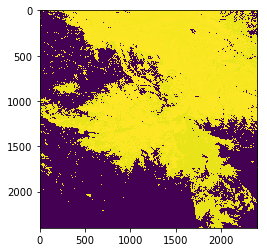

In [112]:
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(start_doy)
    plt.show()

##### Check result (The end day)

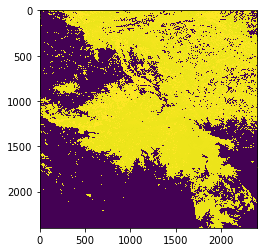

In [113]:
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(end_doy)
    plt.show()

##### Write image (Count of number of snow days during the season)

In [ ]:
message = 'Writing output images' 
ciop.log('INFO', message)

In [115]:
# used in properties file
startdate = datetime.datetime.strptime(dates[0], '%Y-%m-%d')
enddate = datetime.datetime.strptime(dates[-1], '%Y-%m-%d')

In [116]:
snow_ndays_img_name = '_'.join(['SCNDays', modis_sat, tile_id, dates[0].split('-')[0], dates[-1].split('-')[0]]) + '.tif'

snow_ndays_img_name = os.path.join(output_folder, snow_ndays_img_name)

write_output_image(snow_ndays_img_name, snow_ndays, 'GTiff', gdal.GDT_UInt16, None, projection, geotransform, no_data_value)

#wgs84_and_crop_image(snow_ndays_img_name, regionOfInterest['value'], snow_ndays_img_name)

# TEMP
wgs84_image(snow_ndays_img_name, snow_ndays_img_name)

write_properties_file(snow_ndays_img_name, startdate, enddate, regionOfInterest)


NameError: name 'snow_ndays' is not defined

##### Write image (Count of number of consecutive snow cover days)

In [ ]:
#snow_cons_ndays_img_name = '_'.join(['SCConsNDays', modis_sat, tile_id, dates[0].split('-')[0], dates[-1].split('-')[0]])  + '.tif'

#snow_cons_ndays_img_name = os.path.join(output_folder, snow_cons_ndays_img_name)

#write_output_image(snow_cons_ndays_img_name, snow_max_cons_ndays, 'GTiff', gdal.GDT_UInt16, None, projection, geotransform, no_data_value)

#wgs84_and_crop_image(snow_cons_ndays_img_name, regionOfInterest['value'], snow_cons_ndays_img_name)

# TEMP
#wgs84_image(snow_cons_ndays_img_name, snow_cons_ndays_img_name)

#write_properties_file(snow_cons_ndays_img_name, startdate, enddate, regionOfInterest)


##### Write image (The start date)

In [119]:
snow_start_date_img_name = '_'.join(['SCStartSeasonDate', modis_sat, tile_id, dates[0].split('-')[0], dates[-1].split('-')[0]]) + '.tif'

snow_start_date_img_name = os.path.join(output_folder, snow_start_date_img_name)

write_output_image(snow_start_date_img_name, start_doy, 'GTiff', gdal.GDT_Float32, None, projection, geotransform, -9999)

#wgs84_and_crop_image(snow_start_date_img_name, regionOfInterest['value'], snow_start_date_img_name)

# TEMP
wgs84_image(snow_start_date_img_name, snow_start_date_img_name)

write_properties_file(snow_start_date_img_name, startdate, enddate, regionOfInterest)

0.00413672068328
-0.00413672068328
463.312716528
-463.312716528


##### Write image (The end date)

In [120]:
snow_end_date_img_name = '_'.join(['SCEndSeasonDate', modis_sat, tile_id, dates[0].split('-')[0], dates[-1].split('-')[0]]) + '.tif'

snow_end_date_img_name = os.path.join(output_folder, snow_end_date_img_name)

write_output_image(snow_end_date_img_name, end_doy, 'GTiff', gdal.GDT_Float32, None, projection, geotransform, -9999)

#wgs84_and_crop_image(snow_end_date_img_name, regionOfInterest['value'], snow_end_date_img_name)

# TEMP
wgs84_image(snow_end_date_img_name, snow_end_date_img_name)

write_properties_file(snow_end_date_img_name, startdate, enddate, regionOfInterest)

0.00413672068328
-0.00413672068328
463.312716528
-463.312716528


#### Remove temporay files and folders

In [44]:
message = 'Removing temporary files' 
ciop.log('INFO', message)

rm_cfolder(temp_folder)
#rm_cfolder(data_folder)

os.rmdir(temp_folder)
#os.rmdir(data_folder)

reporter:status:2019-11-21T15:41:26.561708 [INFO   ] [user process] Removing temporary files
2019-11-21T15:41:26.561708 [INFO   ] [user process] Removing temporary files
